In [1]:
base_dir="/mnt/efs/shared/meg_shared_scripts/meg-kb"
data_ac="wiki-meg-ac"
data_pt="wiki-meg-pt"
yutong_base_dir="/home/ubuntu/users/yutong"

In [2]:
%cd $base_dir/src/concept_learning/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


In [3]:
from tqdm.notebook import tqdm
import argparse
import re
import numpy as np
from scipy.spatial.distance import cosine
from scipy.stats import pearsonr, entropy, gmean
import random
import torch
from transformers import AutoTokenizer, AutoModel, AutoConfig
from transformers import BertTokenizer, BertModel, BertForMaskedLM
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import json
from collections import defaultdict
import time
import importlib

import logging
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import os
import sys
import math
from annoy import AnnoyIndex
import matplotlib
from matplotlib import pyplot as plt
import networkx as nx

import spacy
from spacy.matcher import Matcher
from spacy.lang.en import English
nlp = English()
nlp.add_pipe(nlp.create_pipe('sentencizer'))
spacy_tokenizer = nlp.tokenizer


from compute_concept_clusters import knn
from compute_keyphrase_embeddings import ensure_tensor_on_device, mean_pooling

from lm_probes import LMProbe, LMProbe_GPT2, LMProbe_Joint, LMProbe_PMI, LMProbe_PMI_greedy
from utils import load_embeddings, load_seed_aligned_concepts, load_seed_aligned_relations, load_benchmark
from utils import get_masked_contexts, bert_untokenize
from utils import learn_patterns

from roberta_ses.interface import Roberta_SES_Entailment

In [4]:
import utils
importlib.reload(utils)
from utils import load_embeddings, load_seed_aligned_concepts, load_seed_aligned_relations, load_benchmark
from utils import get_masked_contexts, bert_untokenize
from utils import learn_patterns

In [5]:
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations_nodup.csv')
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')

# Data Preprocessing

In [2]:
# Input: text corpus
# step 1: extract key phrases (autophrase)
# step 2: generate embeddings

## Extract Key Phrases

In [3]:
# details here: https://github.com/rit-git/meg-kb/tree/main/src/keyword_extraction

In [5]:
#change to keyword extractor directory
%cd $base_dir/src/keyword_extraction/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/keyword_extraction


In [9]:
!chmod +x ./corpusProcess.sh

In [6]:
# select the dataset and thread no
data_ac = 'wiki-meg-ac'
data_pt = 'wiki-meg-pt'
thread = 8

In [7]:
# process corpus and generate key prhases
!./corpusProcess.sh $data_ac $thread

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/keyword_extraction
===Corpus Name: wiki-meg-ac===
===Current Path: /mnt/efs/shared/meg_shared_scripts/meg-kb/src/keyword_extraction===
===Cleaning input corpus===
===Running AutoPhrase===
make: Nothing to be done for 'all'.
===RAW_TRAIN: ../../../data/wiki-meg-ac/source/corpus.clean.txt===
auto_phrase.sh parameters: wiki-meg-ac ../../../data/wiki-meg-ac/source/corpus.clean.txt 10 data/EN/wiki_quality.txt 8
===Compilation===
===Tokenization===
Current step: Tokenizing input file...
real	0m12.875s
user	1m12.688s
sys	0m6.576s
Detected Language: EN
Current step: Tokenizing wikipedia phrases...
No provided expert labels.
===Part-Of-Speech Tagging===
===AutoPhrasing===
=== Current Settings ===
Iterations = 2
Minimum Support Threshold = 10
Maximum Length Threshold = 6
POS-Tagging Mode Disabled
Discard Ratio = 0.050000
Number of threads = 8
Labeling Method = DPDN
	Auto labels from knowledge bases
	Max Positive Samples = -1
Loading data...
# of tota

In [8]:
# copy these results to sample-meg-pt
!cp -r ../../data/$data_ac ../../data/$data_pt

## Corpus with company names

In [33]:
dataset_path = '/home/ubuntu/users/nikita/data/indeed/indeedQA/question_answers.csv'
company_path = '/home/ubuntu/users/nikita/data/indeed/indeedQA/fccid-companyName.csv'
entity_emb_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')
out_corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

In [34]:
with open(entity_emb_num_path, 'r') as f:
    entities = [l.strip().rsplit(' ', 1)[0] for l in f.readlines()]
len(entities)

8053

In [ ]:
df_dataset = pd.read_csv(dataset_path) 
df_dataset = df_dataset[df_dataset['answerContent'].notna()]
df_company = pd.read_csv(company_path)

df_merged_dataset = df_dataset.merge(df_company, how='inner', on='fccompanyId')
df_merged_dataset.head(10)

In [36]:
df_merged_dataset.shape

(307122, 11)

In [37]:
row = df_merged_dataset.iloc[1]
_d = nlp(row["answerContent"])
list(_d.sents)
list(list(_d.sents)[0])

[I, applied, online, and, submitted, all, attachments, that, I, could, .]

In [ ]:
out_corpus = []

for i, row in df_merged_dataset.iterrows():
    if i > 0 and i % 5000 == 0:
        print(f'Progress: {i} / {df_merged_dataset.shape[0]}')
    
    company = row["companyName"]
    ans = row["answerContent"]
    ans_nlp = nlp(ans)
    for sent in ans_nlp.sents:
        sent_tok_list = [str(t) for t in sent]
        _s = f' {company} : {" ".join(sent_tok_list)} '.lower()
        _ents = []
        for _e in entities:
            if f' {_e} ' in _s:
                _ents.append(_e)
        out_corpus.append({
            "tokens": sent_tok_list,
            "company": company,
            "entities": _ents,
        })

In [ ]:
len(out_corpus), out_corpus[0]

In [43]:
with open(out_corpus_path, 'w') as f:
    for d in out_corpus:
        f.write(json.dumps(d) + '\n')

In [42]:
# Use script
!python build_corpus_with_companies.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-rd /home/ubuntu/users/nikita/data/indeed/indeedQA


Processing lines: 100%|████████████████| 307122/307122 [11:51<00:00, 431.47it/s]


In [114]:
!cp $base_dir/data/$data_ac/intermediate/sentences_with_company.json $base_dir/data/$data_pt/intermediate/

# Generate Embeddings

In [465]:
# details here: https://github.com/rit-git/meg-kb/tree/main/src/concept_learning

In [11]:
#change to concept learning directory
%cd $base_dir/src/concept_learning/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


## Sentence Embedding

In [119]:
!CUDA_VISIBLE_DEVICES=3 python compute_keyphrase_embeddings.py -m bert-base-uncased -et ac -d $base_dir/data/$data_ac/intermediate -c 750

computing entity-wise embedding: 100%|██████| 8028/8028 [06:55<00:00, 19.30it/s]
Saving embedding


## Concatenated Token Embedding

In [112]:
!CUDA_VISIBLE_DEVICES=3 python compute_keyphrase_embeddings.py -m bert-base-uncased -et pt -d $base_dir/data/$data_pt/intermediate -c 750

computing entity-wise embedding: 100%|██████| 7973/7973 [07:05<00:00, 18.75it/s]
Saving embedding


## Token Embedding

In [469]:
# change directory to autophrase
%cd $base_dir/src/tools/AutoPhrase

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/tools/AutoPhrase


In [470]:
data_corel = 'sample-indeeda-corel'

In [471]:
!CUDA_VISIBLE_DEVICES=0 python extractBertEmbedding.py ../../../data/$data_corel/intermediate/ $thread

1
2021-06-18 00:36:18,384 : INFO : loading file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-vocab.txt from cache at /home/ubuntu/.cache/torch/pytorch_transformers/26bc1ad6c0ac742e9b52263248f6d0f00068293b33709fae12320c0e35ccfbbb.542ce4285a40d23a559526243235df47c5f75c197f04f37d1a0c124c32c9a084
2021-06-18 00:36:18,776 : INFO : loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-uncased-config.json from cache at /home/ubuntu/.cache/torch/pytorch_transformers/4dad0251492946e18ac39290fcfe91b89d370fee250efe9521476438fe8ca185.7156163d5fdc189c3016baca0775ffce230789d7fa2a42ef516483e4ca884517
2021-06-18 00:36:18,777 : INFO : Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embedding

## Add embeddings for seed instances

In [13]:
def get_masked_contexts_for_entities(entities, input_file):
    """Return a (list of) sentence(s) with entity replaced with MASK."""
    """YS: input should be sentences.json"""
    
    ent_freq = {ent : 0 for ent in entities}
    ent_context = {ent : [] for ent in entities}
    
    with open(input_file, "r") as fin:
        lines = fin.readlines()
        for line in tqdm(lines, total=len(lines), desc="loading corpus"):
            json_dict = json.loads(line)
            sent = ' ' + ' '.join(json_dict['tokens']).lower() + ' '
            #entities = [match.group(1) for match in re.finditer(pat, line)]
            
            for entity in entities:
                pat = f' {entity} '
                if pat not in sent:
                    continue

                context = sent.replace(pat, ' [MASK] ').strip()
                c = context.split('[MASK]')
                if len(c) != 2:  # sanity to not have too many repeating phrases in the context
                    continue

                # ignore too short contexts
                if len(context) < 15:
                    continue

                # print(entity)
                # print(context)
                
                _freq = ent_freq.get(entity, 0)
                ent_freq[entity] = _freq + 1

                context_lst = ent_context.get(entity, [])
                context_lst.append(context)
                ent_context[entity] = context_lst

    dedup_context = {}
    for e, v in ent_context.items():
        dedup_context[e] = list(set(v))
    return ent_freq, dedup_context


In [14]:
def get_avg_context_embedding_for_entities(entities, model_path, input_file, max_context_ct):
    '''
    mean pooling from sentence-transformers
    :param entity: List[str], the entities to compute embeddings for
    :param model_path:
    :param input_file:
    :return:
    '''
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    mask_token_id = tokenizer.mask_token_id

    ent_freq, ent_context = get_masked_contexts_for_entities(entities, input_file)
    
    entity_embeddings = {}
    for entity, en_context_lst in tqdm(ent_context.items(), total=len(ent_context), desc="computing entity-wise embedding"):
#     for entity, en_context_lst in ent_context.items():
        print(entity)
        en_context_lst = random.sample(en_context_lst, min(len(en_context_lst), max_context_ct))
        chunks = [en_context_lst[i:i + 100] for i in range(0, len(en_context_lst), 100)]
        # print(entity)
        # print(len(en_context_lst))
        all_context_embeddings = []
        for chunk in chunks:
            encoded_input = tokenizer.batch_encode_plus(chunk, return_token_type_ids=True, add_special_tokens=True, max_length=128, return_tensors='pt', padding=True, pad_to_max_length=True, truncation=True)
            mask = encoded_input['input_ids'] != mask_token_id
            with torch.no_grad():
                encoded_input = ensure_tensor_on_device(device, **encoded_input)
                model_output = model(**encoded_input)  # Compute token embeddings
            context_embeddings = mean_pooling(model_output, mask)  # mean pooling
            all_context_embeddings.append(context_embeddings)
            
        assert len(all_context_embeddings) > 0
            
        entity_embedding = torch.mean(torch.cat(all_context_embeddings, dim=0), dim=0).cpu().detach().numpy().tolist()
        entity_embeddings[entity] = entity_embedding
    
    return entity_embeddings, ent_freq

In [ ]:
corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences.json')
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')

orig_bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed.txt')
orig_bert_emb_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum.txt')

new_bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')
new_bert_emb_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')

orig_emb_df = load_embeddings(bert_emb_path, 768)
emb_dict = dict(zip(orig_emb_df['entity'].to_list(), orig_emb_df['embedding'].to_list()))

with open(orig_bert_emb_num_path, 'r') as f:
    lines = f.readlines()
    emb_freq_dict = dict([l.strip().rsplit(' ', 1) for l in lines])

concepts_df = load_seed_aligned_concepts(seed_aligned_concepts_path)
seed_instances_list = [inst for _, (_a_con, _u_con, _gnrl, _seed_instances) in concepts_df.iterrows()
                           for inst in _seed_instances]

## debug
seed_instances_list = seed_instances_list[::10]

print(seed_instances_list)

entity_embeddings, ent_freq = \
    get_avg_context_embedding_for_entities(entities=seed_instances_list, 
                                           model_path='bert-base-uncased',
                                           input_file=corpus_path,
                                           max_context_ct=750)

In [ ]:
for inst in seed_instances_list:
    emb = entity_embeddings[inst]
    freq = ent_freq[inst]
    if inst in emb_dict:
        print(f'Already exists: {inst}')
#         assert np.allclose(emb_dict[inst], emb)
#         assert emb_freq_dict[inst] == freq, f'{inst}: orig {emb_freq_dict[inst]} != new {freq}'
#         print(f'Check passed: {inst}')
    else:
        emb_dict[inst] = emb
        emb_freq_dict[inst] = freq

In [ ]:
entity_embeddings.keys()

In [ ]:
with open(new_bert_emb_path, 'w') as f, open(new_bert_emb_num_path, 'w') as f2:
    for inst in seed_instances_list:
        emb = emb_dict[inst]
        freq = ent_freq[inst]
        f.write("{} {}\n".format(inst, ' '.join([str(x) for x in emb])))
        f2.write("{} {}\n".format(inst, freq))


In [735]:
# Using script

!CUDA_VISIBLE_DEVICES=3 python add_seed_instances_embeddings.py -m bert-base-uncased -et ac -d $base_dir/data/$data_ac/intermediate -b $base_dir/data/indeed-benchmark -c 750

Seed instances: ['walmart', 'amazon', 'subway', 'microsoft', 'target', 'business casual', 'uniform', 'hair color', 'tattoos', 'facial hair', 'shoes', 'piercings', 'delivery driver', 'store manager', 'cashier', 'package handler', 'sales associate', 'barista', 'dishwasher', 'weekly', 'biweekly', 'friday', 'saturday', 'health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance', 'base pay', 'stock options', 'benefits', 'overtime pay', 'bonus', 'checks', 'direct deposit', 'prepaid card', 'drug test', 'criminal background check', 'employment verification', 'felons', 'criminals', 'disabled', 'drug addicts', 'high schoolers', 'misdemeanor', 'pregnant', 'students', 'seniors', 'hiring age', 'bachelors degree', 'prior experience', 'working permit', 'heavy lifting', 'night shift', 'dinner shift', 'early morning shift', '8 hour shift', 'christmas eve', 'early morning', 'hoilday', '7 days', 'saturday', 'sunday', 'weekend', 'full time', 'part time', 'seasonal', 

In [108]:
!CUDA_VISIBLE_DEVICES=3 python add_seed_instances_embeddings.py -m bert-base-uncased -et pt -d $base_dir/data/$data_pt/intermediate -b $base_dir/data/indeed-benchmark -c 750

Seed instances: ['walmart', 'amazon', 'subway', 'microsoft', 'target', 'business casual', 'uniform', 'hair color', 'tattoos', 'facial hair', 'shoes', 'piercings', 'delivery driver', 'store manager', 'cashier', 'package handler', 'sales associate', 'barista', 'dishwasher', 'weekly', 'biweekly', 'friday', 'saturday', 'health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance', 'base pay', 'stock options', 'benefits', 'overtime pay', 'bonus', 'checks', 'direct deposit', 'prepaid card', 'drug test', 'criminal background check', 'employment verification', 'felons', 'criminals', 'disabled', 'drug addicts', 'high schoolers', 'misdemeanor', 'pregnant', 'students', 'seniors', 'hiring age', 'bachelors degree', 'prior experience', 'working permit', 'heavy lifting', 'night shift', 'dinner shift', 'early morning shift', '8 hour shift', 'christmas eve', 'early morning', 'hoilday', '7 days', 'saturday', 'sunday', 'weekend', 'full time', 'part time', 'seasonal', 

## Check embeddings

In [121]:
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed.txt')

embeddings = load_embeddings(bert_emb_path, 768)
len(embeddings)

8028

In [118]:
embeddings[embeddings['entity'] == 'black shirt']

,entity,embedding


## (X) Other ways of embeddings / clustering

In [155]:
input_file_path = os.path.join(base_dir, f'data/{data_sub_dir}/intermediate/sent_segmentation.txt')
ent_freq, dedup_context = get_masked_contexts(input_file_path)
len(ent_freq), len(dedup_context)

loading corpus: 100%|██████████| 458/458 [00:00<00:00, 73813.30it/s]


(175, 175)

In [452]:
ent_freq['candy'], dedup_context['candy']

(2,
 ["we dropped by in hopes of finding atkinson 's peanut_butter bars ( we first tried them from honey salt 's [MASK] bowl ) and after searching a few minutes , we found it .",
  "if you 're searching for a [MASK] or soda_pop you grew up with and can no longer find , there 's a good chance you 'll find it here ."])

In [208]:
def get_all_context_embeddings(model_path, input_file, max_context_ct):
    '''
    Adapted from get_avg_context_embeddings()
    keep all context embeddings, using max similarity for knn
    :param model_path:
    :param input_file:
    :return:
    '''
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModel.from_pretrained(model_path)
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    mask_token_id = tokenizer.mask_token_id

    ent_freq, ent_context = get_masked_contexts(input_file)
    entity_embeddings = {}
    for entity, en_context_lst in tqdm(ent_context.items(), total=len(ent_context), desc="computing entity-wise embedding"):
        en_context_lst = random.sample(en_context_lst, min(len(en_context_lst), max_context_ct))
        chunks = [en_context_lst[i:i + 100] for i in range(0, len(en_context_lst), 100)]
        # print(entity)
        # print(len(en_context_lst))
        all_context_embeddings = []
        for chunk in chunks:
            encoded_input = tokenizer.batch_encode_plus(chunk, return_token_type_ids=True, add_special_tokens=True, max_length=128, return_tensors='pt', padding=True, pad_to_max_length=True, truncation=True)
            mask = encoded_input['input_ids'] != mask_token_id
            with torch.no_grad():
                encoded_input = ensure_tensor_on_device(device, **encoded_input)
                model_output = model(**encoded_input)  # Compute token embeddings
            context_embeddings = mean_pooling(model_output, mask)  # mean pooling
            # print(context_embeddings.size())
            all_context_embeddings.append(context_embeddings)
            
        # entity_embedding = torch.mean(torch.cat(all_context_embeddings, dim=0), dim=0).cpu().detach().numpy().tolist()
        # entity_embeddings[entity] = entity_embedding
        entity_embeddings[entity] = torch.cat(all_context_embeddings, dim=0).cpu().detach().numpy().tolist()
        
    return entity_embeddings, ent_freq

In [209]:
model_path = 'bert-base-uncased'
input_file_path = os.path.join(base_dir, f'data/{data_sub_dir}/intermediate/sent_segmentation.txt')
max_context_ct = 10

entity_embeddings, ent_freq = get_all_context_embeddings(model_path, input_file_path, max_context_ct)
len(entity_embeddings), len(ent_freq)

computing entity-wise embedding: 100%|██████████| 175/175 [00:04<00:00, 41.74it/s]


(175, 175)

In [213]:
len(entity_embeddings['candy'][0])

768

In [234]:
def _knn(entity_embeddings, embedding_dim, cluster_size, thread_ct=None, cluster_dest=None, **kwargs):
    # entity_embeddings = load_embeddings(embed_src, embedding_dim)
    
    t = AnnoyIndex(embedding_dim, 'angular')
    # entities = entity_embeddings['entity'].tolist()
    entities = [f'{entity}-{_i}' for entity, embs in entity_embeddings.items() for _i in range(len(embs))]
    # print(entities)
    # for i, row in tqdm(entity_embeddings.iterrows(), total=entity_embeddings.shape[0], desc="building entity index"):
    #     t.add_item(i, row['embedding'])
    i = 0
    for entity, embs in tqdm(entity_embeddings.items(), total=len(entity_embeddings)):
        for emb in embs:
            t.add_item(i, emb)
            i += 1
    assert i == len(entities)
    
    t.build(100)
    
    neighbors = []
    for i, entity in enumerate(tqdm(entities, desc="finding nearest neighbors by entity")):
        # print(i, entity)
        nns, dists = t.get_nns_by_item(i, cluster_size + 1, include_distances=True)
        cos_sim_scores = [(2 - d ** 2) / 2 for d in dists]  # convert angular distance to cosine similarity
        zipped = list(zip(nns, cos_sim_scores))
        sorted_nns = sorted(zipped, key=lambda x: x[1], reverse=True)
        if len(sorted_nns) > 0:
            for nn_idx, d in sorted_nns:
                neighbor_entity = entities[nn_idx]
                if neighbor_entity == entity:
                    continue
                neighbors.append({"entity": entity, "neighbor": neighbor_entity, "sim": d})
    c_df = pd.DataFrame(neighbors)
    return c_df

In [235]:
knn_results = _knn(entity_embeddings, 768, 20)

finding nearest neighbors by entity: 100%|██████████| 269/269 [00:00<00:00, 6006.44it/s]


In [ ]:
query = 'meat'

df = knn_results

n_embs = len(entity_embeddings[query])
sub_frames = []
for _i in range(n_embs):
    ent_name = f'{query}-{_i}'
    sub_frames.append(df[df['entity'] == ent_name])

pd.concat(sub_frames).sort_values('sim', ascending=False).head(10)

In [ ]:
# original avg context knn 
knn_path = os.path.join(base_dir, f'data/{data_sub_dir}/intermediate/knn_100.csv')

knn_results = pd.read_csv(knn_path)
df = knn_results

query = 'walmart'
sub_frame = df[df['entity'] == query]
sub_frame.sort_values('sim', ascending=False).head(10)

# Expand Seed Entities (clustering)

In [99]:
# details here: https://github.com/rit-git/meg-kb/tree/main/src/concept_learning

In [299]:
#change to concept learning directory
%cd ../../concept_learning/

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


## knn sentence-embedding

In [365]:
clusters = 100
output = '../../data/'+data_ac+'/intermediate/knn_'+str(clusters)+'.csv'
dim = 768

In [366]:
!python compute_concept_clusters.py -d ../../data/$data_ac/intermediate/ -ca knn -s $clusters -dim $dim -o $output

finding nearest neighbors by entity: 100%|██| 177/177 [00:00<00:00, 2001.57it/s]


## knn token concatenated

In [308]:
clusters = 20
output = '../../data/'+data_pt+'/intermediate/knn_'+str(clusters)+'.csv'
dim = 3072

In [309]:
!python compute_concept_clusters.py -d ../../data/$data_pt/intermediate/ -ca knn -s $clusters -dim $dim -o $output

finding nearest neighbors by entity: 100%|██| 177/177 [00:00<00:00, 4052.00it/s]


## knn token

In [ ]:
clusters = 20
output = '../../data/'+data_pt+'/intermediate/knn_'+str(clusters)+'.csv'
dim = 768

In [ ]:
!python compute_concept_clusters.py -d ../../data/$data_corel/intermediate/ -ca knn -s $clusters -dim $dim -o $output

## Seed instances clustering (EE-emb)
(using all seed instances of a concept to find neighbors)

In [21]:
# seed_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_concepts.csv')
# seed_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_relations.csv')

seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations.csv')

In [109]:
# def get_concept_knn(embed_src, embedding_dim, seed_aligned_concept_src, cluster_size, thread_ct, cluster_dest, kdt, **kwargs):
#     seed_concepts_df = load_seed_aligned_concepts(seed_aligned_concept_src)
    
#     entity_embeddings = load_embeddings(embed_src, embedding_dim)
#     entities = entity_embeddings['entity'].tolist()
#     embeddings = entity_embeddings['embedding'].tolist()
#     entity_emb_dict = dict(zip(entities, embeddings))

#     neighbors = []
    
#     if kdt:
#         t = AnnoyIndex(embedding_dim, 'angular')
#         for i, row in tqdm(entity_embeddings.iterrows(), total=entity_embeddings.shape[0], desc="building entity index"):
#             t.add_item(i, row['embedding'])
#         t.build(100)
#     else:
#         t = None
        
#     for i, (a_concept, u_concept, gnrl, seed_instances) in tqdm(seed_concepts_df.iterrows(), desc="finding nearest neighbors by concept"):
#         embs = []
#         for inst in seed_instances:
#             try:
#                 embs.append(entity_emb_dict[inst])
#             except KeyError:
#                 print(f"{inst} not found in entity_emb_dict??")
#                 continue
#         if len(embs) == 0:
#             continue
#         concept_emb = np.mean(embs, axis=0)

#         if kdt:
#             nns, dists = t.get_nns_by_vector(concept_emb, cluster_size + 1, include_distances=True)
#             cos_sim_scores = [(2 - d ** 2) / 2 for d in dists]  # convert angular distance to cosine similarity
#         else:
#             all_cos_sim_scores = cosine_similarity([concept_emb.tolist()], embeddings)[0]
#             _partition = np.argpartition(-all_cos_sim_scores, kth=cluster_size)
#             nns = _partition[:cluster_size]
#             cos_sim_scores = [all_cos_sim_scores[i] for i in nns]
            
#         zipped = list(zip(nns, cos_sim_scores))
#         sorted_nns = sorted(zipped, key=lambda x: x[1], reverse=True)
#         if len(sorted_nns) > 0:
#             for nn_idx, d in sorted_nns:
#                 neighbor_entity = entities[nn_idx]
#                 if neighbor_entity in seed_instances:
#                     continue
#                 neighbors.append({"concept": a_concept, "neighbor": neighbor_entity, "sim": d})
   
#     c_df = pd.DataFrame(neighbors)
#     c_df.to_csv(cluster_dest, index=None)

In [110]:
cluster_size = 100

bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')
# seed_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_concepts.csv')
# seed_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_relations.csv')
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_{cluster_size}_TEST.csv')

get_concept_knn(embed_src=bert_emb_path,
                embedding_dim=768,
                seed_aligned_concept_src=seed_aligned_concepts_path,
                cluster_size=cluster_size,
                thread_ct=1,
                kdt=True,
                cluster_dest=concept_knn_path)


In [111]:
_entity_embeddings = load_embeddings(bert_emb_path, 768)
_entities = _entity_embeddings['entity'].tolist()
_embeddings = _entity_embeddings['embedding'].tolist()
_entity_emb_dict = dict(zip(_entities, _embeddings))
len(_entity_emb_dict)

8064

In [114]:
cosine(_entity_emb_dict['401k plan'], _entity_emb_dict['401k'])

0.040605662115216434

In [24]:
%cd $base_dir/src/concept_learning

/mnt/efs/shared/meg_shared_scripts/meg-kb/src/concept_learning


In [235]:
# Use script
cluster_size = None

!python compute_concept_seeds_knn.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/ee_concept_knn_k=None.csv \
-kdt

finding nearest neighbors by concept: 14it [00:05,  2.73it/s]


In [ ]:
# check results 
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_{cluster_size}.csv')

df = pd.read_csv(concept_knn_path)
df[df['concept'] == 'company'].head(10)

In [ ]:
df = pd.read_csv(concept_knn_path)
df[df['concept'] == 'pay_schedule'].head(10)

## Contrastive EE-emb

In [251]:
def get_concept_contrastive_knn(embed_src, embedding_dim, seed_aligned_concept_src, cluster_size, cluster_dest, **kwargs):
    
    seed_concepts_df = load_seed_aligned_concepts(seed_aligned_concept_src)
    
    entity_embeddings = load_embeddings(embed_src, embedding_dim)
    entities = entity_embeddings['entity'].tolist()
    embeddings = entity_embeddings['embedding'].tolist()
    entity_emb_dict = dict(zip(entities, embeddings))

    neighbors = []
    
    concept_emb_dict = dict()
    for i, (a_concept, u_concept, gnrl, seed_instances) in tqdm(seed_concepts_df.iterrows(), desc="finding nearest neighbors by concept"):
        embs = []
        for inst in seed_instances:
            try:
                embs.append(entity_emb_dict[inst])
            except KeyError:
                print(f"{inst} not found in entity_emb_dict??")
                continue
        if len(embs) == 0:
            continue
        concept_emb = np.mean(embs, axis=0)
        concept_emb_dict[a_concept] = concept_emb
    
    concepts = list(concept_emb_dict.keys())
    concept_embs = list(concept_emb_dict.values())

    # (n_concepts, n_entities)
    cos_matrix = cosine_similarity(concept_embs, embeddings)
    
    cands_for_concepts = [[] for _ in range(len(concepts))]
    for e_id, e in enumerate(entities):
        _scores = cos_matrix[:, e_id]
        _cc_ranking = np.argsort(-_scores)
        _max_cc_id = _cc_ranking[0]
        _second_cc_id = _cc_ranking[1]
        _score = _scores[_max_cc_id]
        _2nd_score = _scores[_second_cc_id]
        _margin = _score - _2nd_score
        cands_for_concepts[_max_cc_id].append({
            'concept': concepts[_max_cc_id],
            '2nd_concept': concepts[_second_cc_id],
            'neighbor': e,
            'sim': _score,
            '2nd_sim': _2nd_score,
            'margin': _margin,
            'sim+margin': _score + _margin
        })
    
#         _partition = np.argpartition(-all_cos_sim_scores, kth=cluster_size)
#         nns = _partition[:cluster_size]
#         cos_sim_scores = [all_cos_sim_scores[i] for i in nns]
            
#         zipped = list(zip(nns, cos_sim_scores))
#         sorted_nns = sorted(zipped, key=lambda x: x[1], reverse=True)
#         if len(sorted_nns) > 0:
#             for nn_idx, d in sorted_nns:
#                 neighbor_entity = entities[nn_idx]
#                 if neighbor_entity in seed_instances:
#                     continue
#                 neighbors.append({"concept": a_concept, "neighbor": neighbor_entity, "sim": d})
   
    for cc_id, cands in enumerate(cands_for_concepts):
        cands_sorted = sorted(cands, key=lambda d: d['sim'], reverse=True)
        neighbors.extend(cands_sorted[:cluster_size])
    
    c_df = pd.DataFrame(neighbors)
    c_df.to_csv(cluster_dest, index=None)

In [156]:
cluster_size = None

bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')
# seed_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_concepts.csv')
# seed_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_relations.csv')
concept_contr_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_contr_knn_k={cluster_size}.csv')

get_concept_contrastive_knn(embed_src=bert_emb_path,
                            embedding_dim=768,
                            seed_aligned_concept_src=seed_aligned_concepts_path,
                            cluster_size=cluster_size,
                            cluster_dest=concept_contr_knn_path)

In [253]:
# Use script
cluster_size = 100

!python compute_concept_contrastive_knn.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-s 100 \
-o $base_dir/data/$data_ac/intermediate/ee_concept_contr_knn_k=100.csv

finding nearest neighbors by concept: 14it [00:00, 2789.16it/s]


## EE-LM-probe (prompt)

In [ ]:
'''
@Nikita: Here are the code blocks for exploring LM prompts for EE.

Some core code:
lm_probe = LMProbe()        // LMProbe: BERT; LMProbe_GPT2: GPT2; etc.
all_entitites = ...         // all the entities
_template = "Dress code like jeans, [MASK] and tattoos." // A string with [MASK] (LMProbe automatically takes care of all entity token lengths, so don't need to duplicate mask tokens)
_res = lm_probe.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:50]))  // Show results (rank, cand, score)

'''

In [169]:
lm_probe = LMProbe()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
lm_probe_gpt2 = LMProbe_GPT2()

In [ ]:
ee_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_100.csv')
ee_df = pd.read_csv(ee_path)
ee_df.shape

In [161]:
_r = 'has_dress_code'

_r_row = seed_relations_df[seed_relations_df['alignedRelationName'] == _r].iloc[0]
_h_type = _r_row['domain']
_t_type = _r_row['range']
print(_h_type, _t_type)

_seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _h_type]['seedInstances'].item()
_seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _t_type]['seedInstances'].item()
print(_seed_heads, _seed_tails)

_cand_heads = ee_df[ee_df['concept'] == _h_type]['neighbor'].tolist()
_cand_tails = ee_df[ee_df['concept'] == _t_type]['neighbor'].tolist()
print(len(_cand_heads), len(_cand_tails))

company dress_code
['walmart', 'amazon', 'subway', 'microsoft', 'target'] ['business casual', 'uniform', 'hair color', 'tattoos', 'facial hair', 'shoes', 'piercings']
97 94


In [163]:
emb_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')
with open(emb_num_path, 'r') as f:
    all_entities = [l.rsplit(' ', 1)[0] for l in f]
len(all_entities), all_entities[:3]

(8064, ['multiple times', 'upper', 'management'])

In [164]:
_template = 'We allow jeans, [MASK] and tattoos.'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:50]))

[(0, {'cand': 'moccasins', 'score': 0.012966644052698999}),
 (1, {'cand': 'plantar fasciitis', 'score': 0.011055307323823867}),
 (2, {'cand': 'body piercings', 'score': 0.010491419243759924}),
 (3, {'cand': 'facial piercings', 'score': 0.010034629877810949}),
 (4, {'cand': 'face piercings', 'score': 0.009526236054152915}),
 (5, {'cand': 'rheumatoid arthritis', 'score': 0.00951552640771071}),
 (6, {'cand': 'pajamas', 'score': 0.009477122792155289}),
 (7, {'cand': 'leggings', 'score': 0.009350592230433023}),
 (8, {'cand': 'piercings', 'score': 0.009299829888659331}),
 (9, {'cand': 'flip flops', 'score': 0.008907867295359917}),
 (10, {'cand': 'mannequins', 'score': 0.00890319615818204}),
 (11, {'cand': 'black leggings', 'score': 0.008793791346326064}),
 (12, {'cand': 'spandex', 'score': 0.00877137791733358}),
 (13, {'cand': 'hysterectomy', 'score': 0.008692049287385687}),
 (14, {'cand': 'drug paraphernalia', 'score': 0.008071037304557648}),
 (15, {'cand': 'brazilian jiu jitsu', 'score': 0

In [170]:
_template = 'We allow jeans, [MASK] and tattoos.'
_res = lm_probe.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:50]))

['plant', '##ar', 'fa', '##sc', '##ii', '##tis']: too many wordpieces
['work', '##man', "'", 's', 'com', '##p']: too many wordpieces
['met', '##ham', '##ph', '##eta', '##mine', '##s']: too many wordpieces
['pt', 'ang', '##kas', '##a', 'pu', '##ra', 'ii']: too many wordpieces
['d', '##3', 'dan', 's', '##1', 'se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['pen', '##di', '##di', '##kan', 'sm', '##a']: too many wordpieces
['sl', '##ta', '/', 'sm', '##k', 'minimal', '7', 'dan', 'ip', '##k']: too many wordpieces
['rude', 'and', 'di', '##sr', '##es', '##pe', '##ct', '##ful']: too many wordpieces
['ada', '##pu', '##n', 'po', '##sis', '##i', 'low', '##onga', '##n', 'ke', '##r', '##ja', 'pt', 'ang', '##kas', '##a']: too many wordpieces
['low', '##onga', '##n', 'ke', '##r', '##ja']: too many wordpieces
['se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['patient', 'protection', 'and', 'affordable', 'care', 'act']: too many wordpieces
['ta', '##hl', '##e', '##qua',

[(0, {'cand': 'shoes', 'score': 0.04184859618544578}),
 (1, {'cand': 'panties', 'score': 0.02703012898564339}),
 (2, {'cand': 'hair', 'score': 0.021639285609126088}),
 (3, {'cand': 'tattoos', 'score': 0.019144266843795776}),
 (4, {'cand': 'jeans', 'score': 0.013062405399978163}),
 (5, {'cand': 'sunglasses', 'score': 0.006786400452256205}),
 (6, {'cand': 'bra', 'score': 0.0038306557107716816}),
 (7, {'cand': 'caps', 'score': 0.0034439887385815395}),
 (8, {'cand': 'lipstick', 'score': 0.0030804190319031486}),
 (9, {'cand': 'skin', 'score': 0.0020948206074535842}),
 (10, {'cand': 'leather', 'score': 0.00207862164825201}),
 (11, {'cand': 'pajamas', 'score': 0.0015055921394377947}),
 (12, {'cand': 'cologne', 'score': 0.001362455193884671}),
 (13, {'cand': 'cigarettes', 'score': 0.0013264154549688096}),
 (14, {'cand': 'blouse', 'score': 0.0012996237492188807}),
 (15, {'cand': 'jewellery', 'score': 0.0012973581906408072}),
 (16, {'cand': 'arms', 'score': 0.0011891197646036742}),
 (17, {'cand'

In [172]:
_template = 'The company allows employees to wear jeans, [MASK] and shirts.'
_res = lm_probe.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:50]))

['plant', '##ar', 'fa', '##sc', '##ii', '##tis']: too many wordpieces
['work', '##man', "'", 's', 'com', '##p']: too many wordpieces
['met', '##ham', '##ph', '##eta', '##mine', '##s']: too many wordpieces
['pt', 'ang', '##kas', '##a', 'pu', '##ra', 'ii']: too many wordpieces
['d', '##3', 'dan', 's', '##1', 'se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['pen', '##di', '##di', '##kan', 'sm', '##a']: too many wordpieces
['sl', '##ta', '/', 'sm', '##k', 'minimal', '7', 'dan', 'ip', '##k']: too many wordpieces
['rude', 'and', 'di', '##sr', '##es', '##pe', '##ct', '##ful']: too many wordpieces
['ada', '##pu', '##n', 'po', '##sis', '##i', 'low', '##onga', '##n', 'ke', '##r', '##ja', 'pt', 'ang', '##kas', '##a']: too many wordpieces
['low', '##onga', '##n', 'ke', '##r', '##ja']: too many wordpieces
['se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['patient', 'protection', 'and', 'affordable', 'care', 'act']: too many wordpieces
['ta', '##hl', '##e', '##qua',

[(0, {'cand': 'jeans', 'score': 0.1053730323910713}),
 (1, {'cand': 'shoes', 'score': 0.08028024435043335}),
 (2, {'cand': 'sunglasses', 'score': 0.0030999192968010902}),
 (3, {'cand': 'caps', 'score': 0.0027481289580464367}),
 (4, {'cand': 'panties', 'score': 0.0017155319219455125}),
 (5, {'cand': 'denim', 'score': 0.001618258655071259}),
 (6, {'cand': 'buses', 'score': 0.0009692866588011381}),
 (7, {'cand': 'pajamas', 'score': 0.0007222475833259522}),
 (8, {'cand': 'leather', 'score': 0.0005088149337098004}),
 (9, {'cand': 'polo', 'score': 0.0004302898305468261}),
 (10, {'cand': 'tanks', 'score': 0.0003051776147913187}),
 (11, {'cand': 'cigarettes', 'score': 0.00027609075186774124}),
 (12, {'cand': 'hair', 'score': 0.00020207812485750748}),
 (13, {'cand': 'blouse', 'score': 0.0001957619679160417}),
 (14, {'cand': 'jewellery', 'score': 0.00018753786571323882}),
 (15, {'cand': 'flyers', 'score': 0.0001843944774009287}),
 (16, {'cand': 'yoga', 'score': 0.00017563693108968426}),
 (17, {'

In [173]:
_template = 'The company allows employees to have piercings, [MASK] and tattoos.'
_res = lm_probe.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:50]))

['plant', '##ar', 'fa', '##sc', '##ii', '##tis']: too many wordpieces
['work', '##man', "'", 's', 'com', '##p']: too many wordpieces
['met', '##ham', '##ph', '##eta', '##mine', '##s']: too many wordpieces
['pt', 'ang', '##kas', '##a', 'pu', '##ra', 'ii']: too many wordpieces
['d', '##3', 'dan', 's', '##1', 'se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['pen', '##di', '##di', '##kan', 'sm', '##a']: too many wordpieces
['sl', '##ta', '/', 'sm', '##k', 'minimal', '7', 'dan', 'ip', '##k']: too many wordpieces
['rude', 'and', 'di', '##sr', '##es', '##pe', '##ct', '##ful']: too many wordpieces
['ada', '##pu', '##n', 'po', '##sis', '##i', 'low', '##onga', '##n', 'ke', '##r', '##ja', 'pt', 'ang', '##kas', '##a']: too many wordpieces
['low', '##onga', '##n', 'ke', '##r', '##ja']: too many wordpieces
['se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['patient', 'protection', 'and', 'affordable', 'care', 'act']: too many wordpieces
['ta', '##hl', '##e', '##qua',

[(0, {'cand': 'tattoos', 'score': 0.6991829872131348}),
 (1, {'cand': 'hair', 'score': 0.0065090949647128565}),
 (2, {'cand': 'lipstick', 'score': 0.00543932057917118}),
 (3, {'cand': 'logos', 'score': 0.0022039660252630715}),
 (4, {'cand': 'nipples', 'score': 0.0019367007771506906}),
 (5, {'cand': 'tattoo', 'score': 0.00139555218629539}),
 (6, {'cand': 'cosmetics', 'score': 0.0007131393649615346}),
 (7, {'cand': 'surgery', 'score': 0.000528711767401546}),
 (8, {'cand': 'clothing', 'score': 0.00046022533206269134}),
 (9, {'cand': 'drugs', 'score': 0.00041217444231733664}),
 (10, {'cand': 'skin', 'score': 0.0004079583450220527}),
 (11, {'cand': 'sunglasses', 'score': 0.00033981521846726526}),
 (12, {'cand': 'jewellery', 'score': 0.0003285531711298971}),
 (13, {'cand': 'labels', 'score': 0.00029281346360221516}),
 (14, {'cand': 'ink', 'score': 0.0002547384647186845}),
 (15, {'cand': 'handcuffs', 'score': 0.0002248705568490548}),
 (16, {'cand': 'transgender', 'score': 0.000222469578147865

In [175]:
_template = 'The company requires a dress code including uniform, [MASK] and shoes.'
_res = lm_probe.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:50]))

['plant', '##ar', 'fa', '##sc', '##ii', '##tis']: too many wordpieces
['work', '##man', "'", 's', 'com', '##p']: too many wordpieces
['met', '##ham', '##ph', '##eta', '##mine', '##s']: too many wordpieces
['pt', 'ang', '##kas', '##a', 'pu', '##ra', 'ii']: too many wordpieces
['d', '##3', 'dan', 's', '##1', 'se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['pen', '##di', '##di', '##kan', 'sm', '##a']: too many wordpieces
['sl', '##ta', '/', 'sm', '##k', 'minimal', '7', 'dan', 'ip', '##k']: too many wordpieces
['rude', 'and', 'di', '##sr', '##es', '##pe', '##ct', '##ful']: too many wordpieces
['ada', '##pu', '##n', 'po', '##sis', '##i', 'low', '##onga', '##n', 'ke', '##r', '##ja', 'pt', 'ang', '##kas', '##a']: too many wordpieces
['low', '##onga', '##n', 'ke', '##r', '##ja']: too many wordpieces
['se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['patient', 'protection', 'and', 'affordable', 'care', 'act']: too many wordpieces
['ta', '##hl', '##e', '##qua',

[(0, {'cand': 'shoes', 'score': 0.12526971101760861}),
 (1, {'cand': 'clothing', 'score': 0.06428885459899901}),
 (2, {'cand': 'uniform', 'score': 0.04750930517911912}),
 (3, {'cand': 'cap', 'score': 0.016608720645308498}),
 (4, {'cand': 'caps', 'score': 0.006373641081154344}),
 (5, {'cand': 'blouse', 'score': 0.005406954325735569}),
 (6, {'cand': 'jeans', 'score': 0.004977909382432701}),
 (7, {'cand': 'jewellery', 'score': 0.004148608073592186}),
 (8, {'cand': 'logo', 'score': 0.002692297799512743}),
 (9, {'cand': 'sunglasses', 'score': 0.002085869200527669}),
 (10, {'cand': 'fashion', 'score': 0.001943003735505044}),
 (11, {'cand': 'hair', 'score': 0.0015218171756714582}),
 (12, {'cand': 'cologne', 'score': 0.0011592373484745617}),
 (13, {'cand': 'food', 'score': 0.001128159230574966}),
 (14, {'cand': 'panties', 'score': 0.0011100757401436563}),
 (15, {'cand': 'perfume', 'score': 0.0010554154869168992}),
 (16, {'cand': 'helmet', 'score': 0.0010541978990659118}),
 (17, {'cand': 'cigar

In [179]:
_template = 'The company has a dress code including jeans, [MASK], and shirts.'
_res = lm_probe.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:50]))

['plant', '##ar', 'fa', '##sc', '##ii', '##tis']: too many wordpieces
['work', '##man', "'", 's', 'com', '##p']: too many wordpieces
['met', '##ham', '##ph', '##eta', '##mine', '##s']: too many wordpieces
['pt', 'ang', '##kas', '##a', 'pu', '##ra', 'ii']: too many wordpieces
['d', '##3', 'dan', 's', '##1', 'se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['pen', '##di', '##di', '##kan', 'sm', '##a']: too many wordpieces
['sl', '##ta', '/', 'sm', '##k', 'minimal', '7', 'dan', 'ip', '##k']: too many wordpieces
['rude', 'and', 'di', '##sr', '##es', '##pe', '##ct', '##ful']: too many wordpieces
['ada', '##pu', '##n', 'po', '##sis', '##i', 'low', '##onga', '##n', 'ke', '##r', '##ja', 'pt', 'ang', '##kas', '##a']: too many wordpieces
['low', '##onga', '##n', 'ke', '##r', '##ja']: too many wordpieces
['se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['patient', 'protection', 'and', 'affordable', 'care', 'act']: too many wordpieces
['ta', '##hl', '##e', '##qua',

[(0, {'cand': 'jeans', 'score': 0.18732795119285583}),
 (1, {'cand': 'shoes', 'score': 0.04137388244271279}),
 (2, {'cand': 'denim', 'score': 0.00565440859645605}),
 (3, {'cand': 'sunglasses', 'score': 0.003932376392185689}),
 (4, {'cand': 'panties', 'score': 0.0020852549932897095}),
 (5, {'cand': 'buses', 'score': 0.0016753433737903833}),
 (6, {'cand': 'caps', 'score': 0.0011914296774193645}),
 (7, {'cand': 'leather', 'score': 0.0010424052597954867}),
 (8, {'cand': 'yoga', 'score': 0.0008445206331089139}),
 (9, {'cand': 'pajamas', 'score': 0.0006508376100100576}),
 (10, {'cand': 'tanks', 'score': 0.0004852299753110855}),
 (11, {'cand': 'polo', 'score': 0.0004803886695299296}),
 (12, {'cand': 'blouse', 'score': 0.0003862084413412959}),
 (13, {'cand': 'jewellery', 'score': 0.00033101392909884437}),
 (14, {'cand': 'hair', 'score': 0.0002776607871055606}),
 (15, {'cand': 'cigarettes', 'score': 0.00027209889958612637}),
 (16, {'cand': 'flyers', 'score': 0.00024334085173904904}),
 (17, {'ca

In [186]:
_template = 'dress code including business casual, [MASK] and uniform.'
_res = lm_probe.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:50]))

['plant', '##ar', 'fa', '##sc', '##ii', '##tis']: too many wordpieces
['work', '##man', "'", 's', 'com', '##p']: too many wordpieces
['met', '##ham', '##ph', '##eta', '##mine', '##s']: too many wordpieces
['pt', 'ang', '##kas', '##a', 'pu', '##ra', 'ii']: too many wordpieces
['d', '##3', 'dan', 's', '##1', 'se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['pen', '##di', '##di', '##kan', 'sm', '##a']: too many wordpieces
['sl', '##ta', '/', 'sm', '##k', 'minimal', '7', 'dan', 'ip', '##k']: too many wordpieces
['rude', 'and', 'di', '##sr', '##es', '##pe', '##ct', '##ful']: too many wordpieces
['ada', '##pu', '##n', 'po', '##sis', '##i', 'low', '##onga', '##n', 'ke', '##r', '##ja', 'pt', 'ang', '##kas', '##a']: too many wordpieces
['low', '##onga', '##n', 'ke', '##r', '##ja']: too many wordpieces
['se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['patient', 'protection', 'and', 'affordable', 'care', 'act']: too many wordpieces
['ta', '##hl', '##e', '##qua',

[(0, {'cand': 'uniform', 'score': 0.04455406591296197}),
 (1, {'cand': 'polo', 'score': 0.02965527400374413}),
 (2, {'cand': 'black', 'score': 0.017656834796071056}),
 (3, {'cand': 'fashion', 'score': 0.007025882601737979}),
 (4, {'cand': 'white', 'score': 0.0069195297546684725}),
 (5, {'cand': 'business', 'score': 0.006704169325530528}),
 (6, {'cand': 'sport', 'score': 0.006549005396664144}),
 (7, {'cand': 'sports', 'score': 0.006161295343190433}),
 (8, {'cand': 'blouse', 'score': 0.0048272940330207365}),
 (9, {'cand': 'professional', 'score': 0.004728434607386588}),
 (10, {'cand': 'military', 'score': 0.004313169047236442}),
 (11, {'cand': 'academic', 'score': 0.0034318733960390087}),
 (12, {'cand': 'leather', 'score': 0.003102471120655537}),
 (13, {'cand': 'conservative', 'score': 0.0030637043528258814}),
 (14, {'cand': 'jeans', 'score': 0.002665560925379397}),
 (15, {'cand': 'navy', 'score': 0.002620982471853495}),
 (16, {'cand': 'blue', 'score': 0.00248737121000886}),
 (17, {'cand

In [190]:
_template = 'dress code including business casual, uniform, hair color, tattoos, facial hair, shoes, [MASK] and piercings.'
_res = lm_probe.score_candidates(input_txt=_template, cands=all_entities)
list(enumerate(_res[:50]))

['plant', '##ar', 'fa', '##sc', '##ii', '##tis']: too many wordpieces
['work', '##man', "'", 's', 'com', '##p']: too many wordpieces
['met', '##ham', '##ph', '##eta', '##mine', '##s']: too many wordpieces
['pt', 'ang', '##kas', '##a', 'pu', '##ra', 'ii']: too many wordpieces
['d', '##3', 'dan', 's', '##1', 'se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['pen', '##di', '##di', '##kan', 'sm', '##a']: too many wordpieces
['sl', '##ta', '/', 'sm', '##k', 'minimal', '7', 'dan', 'ip', '##k']: too many wordpieces
['rude', 'and', 'di', '##sr', '##es', '##pe', '##ct', '##ful']: too many wordpieces
['ada', '##pu', '##n', 'po', '##sis', '##i', 'low', '##onga', '##n', 'ke', '##r', '##ja', 'pt', 'ang', '##kas', '##a']: too many wordpieces
['low', '##onga', '##n', 'ke', '##r', '##ja']: too many wordpieces
['se', '##mu', '##a', 'ju', '##rus', '##an']: too many wordpieces
['patient', 'protection', 'and', 'affordable', 'care', 'act']: too many wordpieces
['ta', '##hl', '##e', '##qua',

[(0, {'cand': 'tattoos', 'score': 0.4160754084587097}),
 (1, {'cand': 'hair', 'score': 0.039885014295577996}),
 (2, {'cand': 'lipstick', 'score': 0.02614353969693184}),
 (3, {'cand': 'sunglasses', 'score': 0.012342552654445166}),
 (4, {'cand': 'clothing', 'score': 0.006540362257510425}),
 (5, {'cand': 'jewellery', 'score': 0.006417935248464348}),
 (6, {'cand': 'cosmetics', 'score': 0.00435011088848114}),
 (7, {'cand': 'tattoo', 'score': 0.0035406514070928105}),
 (8, {'cand': 'shoes', 'score': 0.002573060104623437}),
 (9, {'cand': 'jeans', 'score': 0.0015570956747978924}),
 (10, {'cand': 'mascara', 'score': 0.0012895131949335337}),
 (11, {'cand': 'nipples', 'score': 0.001285086153075099}),
 (12, {'cand': 'skin', 'score': 0.0012442303122952583}),
 (13, {'cand': 'logos', 'score': 0.0007056326139718295}),
 (14, {'cand': 'ponytail', 'score': 0.0006706683780066669}),
 (15, {'cand': 'cologne', 'score': 0.0005899472744204106}),
 (16, {'cand': 'handcuffs', 'score': 0.0004861631023231892}),
 (17

In [203]:
def EE_LMProbe(seed_concepts_path,
               emb_path,
               lm_probe_type,
               concepts=None,
               embedding_dim=768,
               tmpl_agg_func=None,
               max_n_grams=5,
               topk=None,
               dest=None,
               **kwargs):
    '''
    EE using LM probing with Hearst prompts like:
    "dress code, such as jeans, [MASK] and shirts." or 
    "dress code, including jeans, [MASK] and shirts." or
    "jeans, [MASK], shirts and other dress code" or 
    '''
    
    seed_concepts_df = load_seed_aligned_concepts(seed_concepts_path)
    entity_embeddings = load_embeddings(emb_path, embedding_dim)
    all_entities = entity_embeddings['entity'].tolist()
    all_embeddings = entity_embeddings['embedding'].tolist()
    entity_emb_dict = dict(zip(all_entities, all_embeddings))
    
#     with open(templates_path, 'r') as f:
#         all_templates = json.load(f)
#     templates = all_templates[relation]
#     templates = templates['positive'] + templates['negative']
    
    probe_prompts = [
        "{0}, such as {1}, {2} and {3}.",
        "{0}, including {1}, {2} and {3}.",
        "{1}, {2}, {3} and other {0}.",
    ]

    if lm_probe_type == 'bert':
        lm_probe = LMProbe(max_n_grams=max_n_grams)
    elif lm_probe_type == 'gpt2':
        lm_probe = LMProbe_GPT2()
    elif lm_probe_type == 'joint':
        lm_probe = LMProbe_Joint(max_n_grams=max_n_grams)
#     elif lm_probe_type == 'pmi':
#         lm_probe = LMProbe_PMI()
#     elif lm_probe_type == 'pmi_greedy':
#         lm_probe = LMProbe_PMI_greedy()
    else:
        raise NotImplementedError(f"lm_probe_type = {lm_probe_type}")
    
    if lm_probe_type in ['bert', 'joint']:
        all_cand_entities = [e for e in all_entities if len(lm_probe.tokenizer.tokenize(e)) <= max_n_grams]
    else:
        all_cand_entities = all_entities
    all_cand_entities = list(set(all_cand_entities))
    
    if tmpl_agg_func is None:
        tmpl_agg_func = max
    
    seed_instances_dict = dict(zip(
        seed_concepts_df['alignedCategoryName'].tolist(),
        seed_concepts_df['seedInstances'].tolist()
    ))
    
    if concepts is None:
        concepts = seed_concepts_df['alignedCategoryName'].tolist()
    
    all_extraction_results = []
    for cc in tqdm(concepts):
        # c_head_tokenized = lm_probe.tokenizer.tokenize(c_head)
        seeds = seed_instances_dict[cc]
        cc_phrase = ' '.join(cc.split('_'))

        extraction_results = []
        cand_scores = []  # List[Dict["cand", "score"]], for each "cand" the average score 
        
        if lm_probe_type in ['bert', 'gpt2', 'joint']:
            # Score: prob
            cand_scores_per_template = []
            for template in probe_prompts:
                # template: {0} = concept, {1-3} = instances
                _input_txt = template.format(cc_phrase, ', '.join(seeds[:-1]), '[MASK]', seeds[-1])
                # print(_input_txt)
                _cand_scores = lm_probe.score_candidates(_input_txt, all_cand_entities)
                _cand_scores.sort(key=lambda d : d["cand"])
                # List[Dict["cand", "score"]]
                cand_scores_per_template.append(_cand_scores)

            for _cand_score_lst in zip(*cand_scores_per_template):
                # _cand_score_lst: List[Dict["cand", "score"]], for the same "cand" and different template 
                _cand = _cand_score_lst[0]["cand"]
                assert all(d["cand"] == _cand for d in _cand_score_lst), _cand_score_lst
                _score = tmpl_agg_func([d["score"] for d in _cand_score_lst])
                # _score = np.log(_score)
                cand_scores.append({"cand": _cand, "score": _score})
        elif lm_probe_type in ['pmi', 'pmi_greedy']:
            # Score: PMI 
            raise NotImplementedError
            

        for d in cand_scores:
            e = d["cand"]
            if e in seeds:
                continue

            lm_score = d["score"]
            extraction_results.append({'concept': cc,
                                       'neighbor': e,
                                       'lm_score': lm_score
                                      })
        
        extraction_results.sort(key=lambda d : d['lm_score'], reverse=True)
        all_extraction_results.extend(extraction_results[:topk])

#     all_extraction_results.sort(key=lambda d : d['overall_score'], reverse=True)
#     all_extraction_results = all_extraction_results[:topk]

    results_df = pd.DataFrame(all_extraction_results)
    if dest is not None:
        results_df.to_csv(dest, index=None)
    return results_df


In [204]:
emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')

topk = 100
ee_output_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_k={topk}.csv')

EE_LMProbe(seed_concepts_path=seed_aligned_concepts_path,
           emb_path=emb_path,
           lm_probe_type='bert',
           concepts=None,
           embedding_dim=768,
           tmpl_agg_func=None,
           max_n_grams=5,
           topk=topk,
           dest=ee_output_path)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


,concept,neighbor,lm_score
0,company,nike,0.073686
1,company,apple,0.053486
2,company,ibm,0.047059
3,company,sears,0.043689
4,company,starbucks,0.026793
...,...,...,...
1395,onboarding_steps,job performance,0.001784
1396,onboarding_steps,school,0.001783
1397,onboarding_steps,staff members,0.001776
1398,onboarding_steps,gym,0.001750


In [256]:
# Use scripts 
!python compute_EE_LM_probe.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-lm bert \
-topk 200 \
-o $base_dir/data/$data_ac/intermediate/ee_LM_bert_k=200.csv


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|███████████████████████████████████████████| 14/14 [00:52<00:00,  3.76s/it]


## Visualizing Clustering Results

In [107]:
#Visit here: /meg_shared_scripts/meg-kb/src/analysis/concept_learning-test.ipynb

In [71]:
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations.csv')

concept_knn_path = concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_100.csv')

In [72]:
entity_embeddings = load_embeddings(bert_emb_path, 768)
entity_emb_dict = dict(zip(entity_embeddings['entity'].tolist(), entity_embeddings['embedding'].tolist()))

seed_concepts_df = load_seed_aligned_concepts(seed_aligned_concepts_path)

concepts_knn_df = pd.read_csv(concept_knn_path)

In [73]:
vis_records = []
# record item: List[
#     (con_name, con_emb),
#     List[(seed_name, seed_emb)],
#     List[(inst_name, inst_emb)],
# ]

for i, (a_concept, u_concept, gnrl, _seed_instances) in seed_concepts_df.iterrows():
    _seed_embs = []
    for inst in _seed_instances:
        try:
            _emb = entity_emb_dict[inst]
            _seed_embs.append(_emb)
        except KeyError:
            print(f"{inst} not found in entity_emb_dict??")
            continue
    if len(_seed_embs) == 0:
        continue
    _concept_emb = np.mean(_seed_embs, axis=0)
    
    _concept_knns = concepts_knn_df[concepts_knn_df['concept'] == a_concept]['neighbor'].tolist()
    _concept_knn_embs = [entity_emb_dict[inst] for inst in _concept_knns]
    
    _record = [(a_concept, _concept_emb),
       list(zip(seed_instances, _seed_embs)),
       list(zip(_concept_knns, _concept_knn_embs))
    ]
    
    vis_records.append(_record)

In [146]:
_label_list = []
_raw_emb_list = []
_size_list = []   # knn = 1, seed = 2, concept = 3 
_color_id_list = []

_CONCEPT_SIZE = 100
_SEED_SIZE = 30
_CAND_SIZE = 1

for c_id, ((_con, _con_emb), _seeds, _knns) in enumerate(vis_records):
    _label_list.append(_con)
    _raw_emb_list.append(_con_emb)
    _size_list.append(_CONCEPT_SIZE)
    _color_id_list.append(c_id)
    for _seed, _seed_emb in _seeds:
        _label_list.append(_seed)
        _raw_emb_list.append(_seed_emb)
        _size_list.append(_SEED_SIZE)
        _color_id_list.append(c_id)
    for _inst, _inst_emb in _knns:
        _label_list.append(_inst)
        _raw_emb_list.append(_inst_emb)
        _size_list.append(_CAND_SIZE)
        _color_id_list.append(c_id)

In [84]:
len(_raw_emb_list)

1432

In [78]:
tsne = TSNE()
_tsne_emb_list = tsne.fit_transform(_raw_emb_list).tolist()

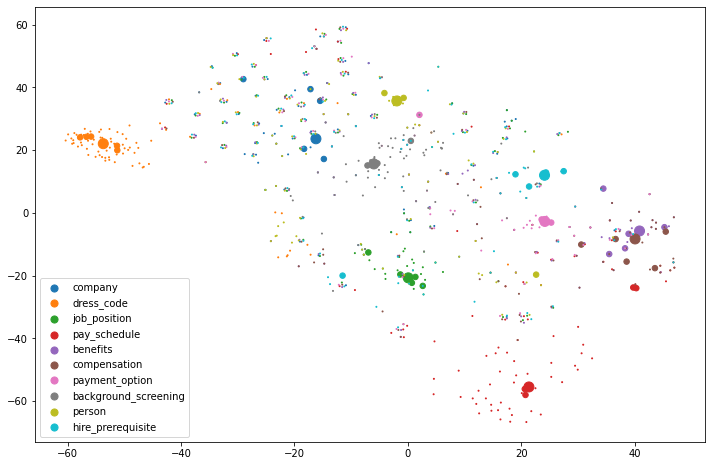

In [147]:
_tsne_x, _tsne_y = list(zip(*_tsne_emb_list))

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

# _scatter = ax.scatter(_tsne_x, _tsne_y, s=_size_list, c=_color_id_list)

cmap = plt.get_cmap(name='viridis')

for c_id, _record in enumerate(vis_records[:10]):
    _data_ids = [i for i, c in enumerate(_color_id_list) if c == c_id]
    _x = [_tsne_x[i] for i in _data_ids]
    _y = [_tsne_y[i] for i in _data_ids]
    _s = [_size_list[i] for i in _data_ids]
#     _c = [c_id for i in _data_ids]
#     _c = matplotlib.colors.rgb2hex(cmap(1.0 * c_id / len(vis_records)))
    ax.scatter(_x, _y, s=_s, label=_record[0][0])

ax.legend()
fig.show()

In [ ]:
# legend1 = ax.legend(*_scatter.legend_elements(), title="Classes")
# # ax.add_artist(legend1)
# fig.show()

In [ ]:
# matplotlib.colors.rgb2hex(cmap(0.9))

## Checking recall

In [205]:
ee_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_k=None.csv')
ee_df = pd.read_csv(ee_path)
ee_df.shape

(112515, 3)

In [206]:
_cc = 'benefits'
_cc_df = ee_df[ee_df['concept'] == _cc]
_cc_cands = _cc_df['neighbor'].tolist()
len(_cc_cands)

8036

In [209]:
# Some correct: higher pay, pay increase, aids, small raise, etc,

_cc_cands[1000:1100]

['corporate offices',
 'limited availability',
 'intelligence',
 'history',
 'pay increase',
 '24 hrs',
 'drivers license',
 'higher pay',
 'costumer service',
 'television',
 'contact number',
 'online courses',
 'pay grade',
 'email address',
 'criminal back ground',
 'lease',
 'rest breaks',
 '48 hrs',
 'pre hire',
 'pre hire',
 'previous jobs',
 'airline',
 'record report',
 'incident management',
 'low pay',
 'sexual orientation',
 'electric chair',
 'guard card',
 'career path',
 'final interview',
 'legal issues',
 'climate',
 'set schedule',
 'phone interviews',
 'pre screening',
 '$ 1 . 50',
 'air conditioner',
 'new jersey',
 'prepaid card',
 'lifeguard',
 'sleep deprivation',
 'brown or black',
 'aids',
 'fourty hours',
 'retail sales',
 'debit card',
 'pharmacy department',
 'basic english',
 'seasonal workers',
 'grade point average',
 'contract',
 'prep food',
 'company policies',
 'wind',
 'customer engagement',
 'online application',
 'general warehouse',
 'fertility',


In [210]:
# Some correct: stipend

_cc_cands[3000:3100]

['toleration',
 'jury duty',
 'vultures',
 'central california',
 'es muy',
 'assistant manger',
 'lemont illinois',
 'guam',
 'pre screen',
 'crew members',
 'store brand',
 'independent contractor',
 'park city',
 'wide variety',
 'union',
 'olympia',
 'door greeters',
 'safeway',
 'class b',
 'west palm beach florida',
 'hardware store',
 'assembly line',
 'diamond',
 'tipped out',
 'web browser',
 'green polo',
 'seatbelt',
 'police officer',
 'stipend',
 'assist customers',
 'nonprofit',
 'pepsi center',
 'best bet',
 'felony friendly',
 'ralphs',
 'team lead',
 'halter',
 'store owner',
 'coney island',
 'longmont colorado',
 'unions',
 'juice',
 'perris california',
 'manoa',
 '6 months',
 'cultural',
 'american airlines',
 'saturday sunday',
 'monday sunday',
 'camera',
 'rivets',
 'hybrid',
 'sunday saturday',
 'restoration',
 'grand island nebraska',
 'lead',
 'dialysis',
 'team effort',
 'washington state',
 'billerica',
 'phoenix arizona',
 'tj maxx',
 'neckline',
 'florida

In [211]:
_cc = 'company'
_cc_df = ee_df[ee_df['concept'] == _cc]
_cc_cands = _cc_df['neighbor'].tolist()
len(_cc_cands)

8037

In [212]:
# Some correct: panda express, little rock?, fedex express, blizzard?, macy's, etc.

_cc_cands[1000:1100]

['meeting new people',
 'panda express',
 'corporate offices',
 'wv',
 'casual clothing',
 'seat belt',
 'burlington',
 'pc',
 'tort',
 'rogers arkansas',
 'east point georgia',
 'marketing',
 'miller county',
 'montebello',
 'store mgr',
 'tampa international airport',
 'chick fil',
 'home shopping',
 'quest diagnostics',
 'orange shirt',
 'cram school',
 'overnight stockers',
 'carriage house',
 'new hire packet',
 'attorney general',
 'sapphire',
 'track records',
 'field tech',
 'panama city beach',
 'friendswood texas',
 'skylight',
 'memphis tn',
 'battery',
 'medical history',
 'tobacco smoking',
 'great deal',
 'black khaki',
 'sams',
 'deep learning',
 'ocean city',
 'red polo shirt',
 'cps',
 'dna',
 'finance',
 'push ups',
 'personal development',
 'plum',
 'mobile device',
 'email',
 'a 10',
 'american eagle outfitters',
 'ram',
 "doctor ' s note",
 'biggie',
 'npc',
 'innovation',
 'sweet tea',
 'cpi',
 'owl',
 'cambridge ohio',
 'thomas circle',
 'jsa',
 'capital',
 'seco

In [213]:
# Some correct: disneyland? (many unsure...)

_cc_cands[3000:3100]

['pepperoni',
 'ma',
 'osmosis',
 'winston salem',
 'prestige',
 'christian values',
 'citrus heights',
 'hourly guarantee',
 'calendar year',
 'food allergy',
 'west mifflin',
 'disneyland',
 'topeka',
 'inventory control',
 'angry customer',
 'torrance',
 'heraclitus',
 'electricity',
 'americus',
 'huntingdon',
 'bubble gum',
 'bartlesville',
 'pays bi weekly',
 'shotguns',
 'clovis',
 'suicide note',
 'santa monica california',
 'cronyism',
 'ted nugent',
 'patent',
 'holiday inn express',
 'lead',
 'magnet',
 'downers grove',
 'barbiturate',
 'el paso tx',
 'phone numbers',
 'los angeles ca',
 'newspaper',
 'holiday clerk',
 'jasmine',
 'blue jacket',
 'mass number',
 'high school',
 'cafeteria',
 'toxic work environment',
 'lol',
 'leaf',
 'capri',
 'heart failure',
 'missoula county',
 'pedi',
 'marsh',
 'tivo',
 'burrow',
 'cohasset',
 'funland',
 'sauna',
 'ship',
 'athens ga',
 'enforcement agency',
 'tangerang',
 'seafood',
 'mesa',
 'drug related crime',
 'abilene kansas',


In [226]:
ee_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_knn_k=None.csv')
ee_df = pd.read_csv(ee_path)
ee_df.shape

(111941, 3)

In [227]:
_cc = 'benefits'
_cc_df = ee_df[ee_df['concept'] == _cc]
_cc_cands = _cc_df['neighbor'].tolist()
len(_cc_cands)

7995

In [228]:
# Some correct: not found 

_cc_cands[1000:1100]

['senior citizens',
 'chick fil',
 'operating hours',
 'florida',
 'fbi',
 'pending charges',
 'store mgr',
 'job fairs',
 'taco',
 'rotating schedule',
 'orientation date',
 'night stocker',
 'friendly',
 'starting wage',
 'lod',
 'hard worker',
 'drama',
 'pop',
 'sms',
 'reliable transportation',
 'christmas',
 'hiring list',
 '15 minute break',
 'equal opportunity',
 'next step',
 'fl',
 'dental and vision',
 'career opportunities',
 'washington dc',
 'personal information',
 'hostile work environment',
 'chicken',
 'scheduling system',
 'customer base',
 'seafood',
 'md',
 'salaried managers',
 'alaska',
 'coffee',
 'hostile environment',
 'performance review',
 'basic knowledge',
 'dish washer',
 'legal age',
 'oregon',
 'cultural',
 'scrubs',
 'gps',
 'ss card',
 'personal issues',
 'drugs tests',
 'big deal',
 'louisiana',
 'selection list',
 'bakery department',
 'hygiene',
 'philadelphia',
 'different kinds',
 'cobra',
 'smoke breaks',
 'alabama',
 'low paying',
 'taste',
 'n

In [229]:
# Some correct: not found 

_cc_cands[3000:3100]

['my worst enemy',
 'saint',
 'bentonville',
 'sit down',
 'radar',
 'tennis',
 'food quality',
 'tsa',
 'civilian',
 'toed shoes',
 'leather',
 'two face',
 'ro',
 'pmr',
 'minute breaks',
 'financial services',
 'dv',
 'closed toe',
 'decatur',
 'refrigeration',
 '10 pm 7 am',
 'kool aid',
 'charleston',
 'liberal',
 'macon ga',
 'assembler',
 'velcro',
 'bean',
 'maintenance workers',
 'goat',
 'non compete clause',
 'southern illinois',
 'sponge',
 'black',
 'hard copy',
 'mountains',
 'stimulant',
 'rock',
 'car wash',
 'open toe',
 'atlantic',
 'ugg boots',
 'non slip',
 'probability',
 'poster',
 'magazine',
 'voice mail',
 'logic',
 'vista',
 'independently owned',
 'ocala',
 'butter',
 'windsor',
 'edwardsville',
 'reconstruction',
 'farce',
 'painting',
 'absolute garbage',
 'negligence',
 'rat',
 'festival',
 'bpo',
 'wallingford',
 'sexuality',
 'mobile phones',
 'solid color',
 'black t shirt',
 'resistance shoes',
 'detective',
 'class action lawsuit',
 'pharmacy school',

In [230]:
_cc = 'company'
_cc_df = ee_df[ee_df['concept'] == _cc]
_cc_cands = _cc_df['neighbor'].tolist()
len(_cc_cands)

7996

In [231]:
# Some correct: not found 

_cc_cands[1000:1100]

['owner operator',
 'grocery stores',
 'lafayette',
 'sam walton',
 'peers',
 'met team',
 'indianapolis',
 'extensive background checks',
 'higher level',
 'lawyer',
 'couple months',
 'sms',
 'cleveland',
 'primark',
 'solution',
 'togo',
 'tv',
 'common practice',
 'fork lift',
 'door greeter',
 'taste',
 'hard worker',
 'motivation',
 'appeal',
 'min wage',
 'forest',
 'strict policy',
 'test results',
 'medical marijuana card',
 'lower management',
 'nashville',
 'professional',
 'starting point',
 'bonus structure',
 'facial hair',
 'purple hair',
 '1st interview',
 'shift leads',
 'colored hair',
 'hire date',
 'direct deposits',
 'social security',
 'starter job',
 'light',
 'guide lines',
 'toy',
 'turnover rate',
 'hr dept',
 'mc',
 'annual review',
 'oklahoma city',
 'payment card',
 'home jobs',
 '3rd shift',
 'bare minimum',
 'own vehicle',
 'career employee',
 'pet care',
 'maine',
 'cart pusher',
 'clean driving record',
 'team effort',
 'hair color',
 'universal',
 'ene

In [232]:
# Some correct: not found 

_cc_cands[3000:3100]

['business card',
 'bar code',
 'pedophiles',
 'fried chicken',
 'protected',
 'parents permission',
 'steel toed',
 'directed',
 'atlanta ga',
 'hot mess',
 'tina',
 'designated hitter',
 'invoice',
 'dv',
 'vista',
 'ugg boots',
 'cuba',
 'pump',
 'buckeye warehouse',
 'lab coat',
 'salt',
 'denton',
 'collard shirts',
 'magazine',
 'indians',
 'larceny',
 'job titles',
 'petersburg',
 'job satisfaction',
 'case basis',
 'hillsboro',
 'tractors',
 'rat',
 'management trainee',
 'shorter than',
 'west mifflin',
 'wells fargo bank',
 'russia',
 'merrillville',
 'judge',
 'palm',
 'tulsa oklahoma',
 'proper steps',
 'clarksville',
 'velcro',
 'kuwait city',
 'automation',
 'dearborn',
 'guru',
 'plymouth',
 'team leads',
 'red',
 'marine',
 'rays',
 'pajamas',
 'portage',
 'noc',
 'austin tx',
 'congress',
 'jeans',
 'ato',
 'salary based',
 'chattanooga',
 'shark',
 'switcher',
 'multiple choice',
 'ares',
 'pretty fast',
 'bird',
 'high schools',
 'ocala',
 't shirt',
 'atlantic',
 't

In [257]:
ee_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_contr_knn_k=None.csv')
ee_df = pd.read_csv(ee_path)
ee_df.shape

(8064, 7)

In [265]:
_cc = 'dress_code'
_cc_df = ee_df[(ee_df['concept'] != _cc) & (ee_df['2nd_concept'] != _cc)]
_cc_cands = _cc_df['neighbor'].tolist()
len(_cc_cands)

7580

In [266]:
# correct: not found 
random.sample(_cc_cands, k=100)

['coppell',
 'healthcare',
 'attendance policy',
 'full service shoppers',
 'etl',
 'reverse discrimination',
 'medical marijuana card',
 'death star',
 'southern california',
 'etcs',
 'dinner rush',
 'recidivism',
 'chelmsford',
 'lgbt',
 'hard workers',
 'fannie mae',
 'paid 15 minute breaks',
 'northern virginia',
 'extremely low',
 'mass hysteria',
 'my worst enemy',
 'public relations',
 'biddeford maine',
 'kitchener',
 'bucks',
 'easter seals',
 'sponge',
 'national guard',
 'vcs',
 'tms',
 'potatoes',
 'salary cap',
 'jackson michigan',
 'kidney disease',
 'chauffeur',
 'stimulant',
 'big smile',
 'japan',
 'ghost',
 'laboratory school',
 'first advantage',
 'legal age',
 'moral turpitude',
 'school district',
 'teaching experience',
 'charleston west virginia',
 'darden restaurants',
 'pension',
 'urine',
 'fresno ca',
 'super bowl',
 'fraud',
 'whitewater',
 'torrance',
 "hawai'i",
 'ua',
 'telegraph',
 'akron',
 'age limit',
 'mc',
 'dobbs ferry',
 'application entry',
 'au

## Different methods overlapping

In [91]:
ee_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_knn_k=None.csv')
ee_contr_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_contr_knn_k=None.csv')
ee_LM_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_k=None.csv')

ee_labels_path = os.path.join(base_dir, f'data/indeed-benchmark/ee-labels.csv')

In [92]:
def load_EE_labels(ee_labels_path):
    ee_labels_df = pd.read_csv(ee_labels_path)
    concept_list = list(set(ee_labels_df['concept'].tolist()))

    ee_labels_dict = dict()
    for _cc in concept_list:
        ee_labels_dict[_cc] = ee_labels_df[ee_labels_df['concept'] == _cc]['neighbor'].tolist()

    return ee_labels_dict

In [97]:
ee_labels_dict = load_EE_labels(ee_labels_path)
concept_list = sorted(list(ee_labels_dict.keys()))

In [ ]:
for _cc, _e_list in ee_labels_dict.items():
    print(_cc, len(_e_list))

In [98]:
_concept = 'dress_code'
ee_contr_emb_df = pd.read_csv(ee_contr_emb_path)
ee_LM_df = pd.read_csv(ee_LM_path)

ee_contr_emb_list = ee_contr_emb_df[ee_contr_emb_df['concept'] == _concept]['neighbor'].tolist()
ee_LM_list = ee_LM_df[ee_LM_df['concept'] == _concept]['neighbor'].tolist()
ee_contr_emb_list[:5], ee_LM_list[:5]

(['hair', 'uniform', 'clothing', 'facial piercings', 'piercings'],
 ['hair', 'body piercings', 'lipstick', 'ear piercings', 'face piercings'])

In [99]:
for K in [5, 10, 20, 50, 100, 300, 1000]:
    _s1 = set(ee_contr_emb_list[:K])
    _s2 = set(ee_LM_list[:K])
    
    _s1_corr = [_e for _e in _s1 if _e in ee_labels_dict[_concept]]
    _s2_corr = [_e for _e in _s2 if _e in ee_labels_dict[_concept]]

    _ints = _s1 & _s2
    _ints_corr = [_e for _e in _ints if _e in ee_labels_dict[_concept]]
    
    _union = _s1 | _s2
    _union_corr = [_e for _e in _union if _e in ee_labels_dict[_concept]]
    
    print(f"K = {K:<4d} Emb = {len(_s1)}({len(_s1_corr)})\
    LM = {len(_s2)}({len(_s2_corr)})\
    Intersect = {len(_ints)}({len(_ints_corr)})\
    Union = {len(_union)}({len(_union_corr)})")

K = 5    Emb = 5(5)    LM = 5(5)    Intersect = 1(1)    Union = 9(9)
K = 10   Emb = 10(9)    LM = 10(10)    Intersect = 2(2)    Union = 18(17)
K = 20   Emb = 20(19)    LM = 20(20)    Intersect = 3(3)    Union = 37(36)
K = 50   Emb = 50(43)    LM = 50(48)    Intersect = 15(15)    Union = 85(76)
K = 100  Emb = 100(80)    LM = 100(88)    Intersect = 26(26)    Union = 174(142)
K = 300  Emb = 300(233)    LM = 298(145)    Intersect = 129(117)    Union = 469(261)
K = 1000 Emb = 397(245)    LM = 996(197)    Intersect = 237(181)    Union = 1156(261)


In [100]:
for _cc in sorted(concept_list):
    print(f'Concept: {_cc}({len(ee_labels_dict[_cc])})')
    _ee_contr_emb_list = ee_contr_emb_df[ee_contr_emb_df['concept'] == _cc]['neighbor'].tolist()
    _ee_LM_list = ee_LM_df[ee_LM_df['concept'] == _cc]['neighbor'].tolist()
    
    for K in [5, 10, 20, 50, 100, 300, 1000]:
        _s1 = set(_ee_contr_emb_list[:K])
        _s2 = set(_ee_LM_list[:K])

        _s1_corr = [_e for _e in _s1 if _e in ee_labels_dict[_cc]]
        _s2_corr = [_e for _e in _s2 if _e in ee_labels_dict[_cc]]

        _ints = _s1 & _s2
        _ints_corr = [_e for _e in _ints if _e in ee_labels_dict[_cc]]

        _union = _s1 | _s2
        _union_corr = [_e for _e in _union if _e in ee_labels_dict[_cc]]

        print(f"K = {K:<4d} Emb = {len(_s1)}({len(_s1_corr)})    " + \
            f"LM = {len(_s2)}({len(_s2_corr)})    " + \
            f"Intersect = {len(_ints)}({len(_ints_corr)})    " + \
            f"Union = {len(_union)}({len(_union_corr)})")
    print()

Concept: background_screening(84)
K = 5    Emb = 5(4)    LM = 5(5)    Intersect = 2(2)    Union = 8(7)
K = 10   Emb = 10(6)    LM = 10(10)    Intersect = 2(2)    Union = 18(14)
K = 20   Emb = 20(11)    LM = 20(16)    Intersect = 4(3)    Union = 36(24)
K = 50   Emb = 50(29)    LM = 50(33)    Intersect = 6(5)    Union = 94(57)
K = 100  Emb = 100(39)    LM = 100(56)    Intersect = 15(11)    Union = 185(84)
K = 300  Emb = 300(46)    LM = 300(64)    Intersect = 55(26)    Union = 545(84)
K = 1000 Emb = 885(49)    LM = 999(75)    Intersect = 188(40)    Union = 1696(84)

Concept: benefits(91)
K = 5    Emb = 5(5)    LM = 5(5)    Intersect = 1(1)    Union = 9(9)
K = 10   Emb = 10(10)    LM = 10(10)    Intersect = 2(2)    Union = 18(18)
K = 20   Emb = 20(18)    LM = 20(20)    Intersect = 7(7)    Union = 33(31)
K = 50   Emb = 50(33)    LM = 50(42)    Intersect = 17(14)    Union = 83(61)
K = 100  Emb = 100(48)    LM = 100(66)    Intersect = 29(25)    Union = 171(89)
K = 300  Emb = 105(50)    LM = 3

In [101]:
## Using MRR to combine ranking 

ee_mrr_combine_list = []

for _cc in sorted(concept_list):
#     print(f'Concept: {_cc}({len(ee_labels_dict[_cc])})')
    _ce_df = ee_contr_emb_df[ee_contr_emb_df['concept'] == _cc].sort_values(by='sim+margin', ascending=False)
    _ee_contr_emb_list = _ce_df['neighbor'].tolist()
    
    _ee_LM_list = ee_LM_df[ee_LM_df['concept'] == _cc]['neighbor'].tolist()
    
#     _all_entities = set(_ee_contr_emb_list) & set(_ee_LM_list)
    
    _all_entities_mrr = defaultdict(float)
    for i, _e in enumerate(_ee_contr_emb_list):
        _all_entities_mrr[_e] += 1.0 / (i+1)
    for i, _e in enumerate(_ee_LM_list):
        _all_entities_mrr[_e] += 1.0 / (i+1)

    _all_entities_mrr_list = sorted(list(_all_entities_mrr.items()), key=lambda p: p[-1], reverse=True)
    
    for _e, _mrr in _all_entities_mrr_list:
        ee_mrr_combine_list.append((_cc, _e, _mrr))

len(ee_mrr_combine_list)

112322

In [102]:
ee_mrr_combine_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_mrr_combine_k=None.csv')
pd.DataFrame(ee_mrr_combine_list, columns=['concept', 'neighbor', 'MRR']).to_csv(ee_mrr_combine_path, index=None)

In [ ]:
_ce_df.sort_values(by='sim+margin', ascending=False).head(20)

## Sub-clusters analysis

In [6]:
ee_LM_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_k=None.csv')

In [14]:
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')

_entity_embeddings = load_embeddings(bert_emb_path, 768)
_entity_emb_dict = dict(zip(_entity_embeddings['entity'].tolist(),
                            _entity_embeddings['embedding'].tolist()))
len(_entity_emb_dict)

8064

In [9]:
_concept = 'benefits'
ee_LM_df = pd.read_csv(ee_LM_path)
ee_LM_list = ee_LM_df[ee_LM_df['concept'] == _concept]['neighbor'].tolist()
len(ee_LM_list)

8036

In [ ]:
K = 100
_entities = ee_LM_list[:K]
_feats_arr = [_entity_emb_dict[_e] for _e in _entities]

In [33]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='euclidean')
_cls_res = A_cls.fit_predict(_feats_arr)

In [34]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(K) if _cls_res[j] == i))

CLUSTER 0:
property insurance | home care | medical billing
CLUSTER 1:
disability insurance | health savings account | parental leave | dental / vision
CLUSTER 2:
dental insurance | medical insurance | dental vision | health dental | health | medical dental | health care insurance | life insurance | health care | medical | retirement age | dental and vision | legal age | medical / dental
CLUSTER 3:
unemployment benefits | vehicle insurance | unemployment compensation | child support | income tax | hearing impairment | electricity
CLUSTER 4:
dental assistant
CLUSTER 5:
health benefits | physical disability | tax credit | mortgage loan | student loan | medical emergency | business card | social services | divorce
CLUSTER 6:
medical history
CLUSTER 7:
cough
CLUSTER 8:
disability | pension | medicare | dental benefits | unemployment | insurance | education | car insurance | employment | hair | employee benefits | safety | benefits | medical card | mental health | life | food safety | child

In [35]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='l2', linkage='complete')
_cls_res = A_cls.fit_predict(_feats_arr)

In [36]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(K) if _cls_res[j] == i))

CLUSTER 0:
unemployment benefits | vehicle insurance | unemployment compensation | mortgage loan | child support | social services | income tax | hearing impairment | electricity
CLUSTER 1:
health dental | medical dental | property insurance | medical billing
CLUSTER 2:
dental assistant
CLUSTER 3:
dental insurance | medical insurance | disability insurance | dental vision | health | life insurance | health care | medical | dental and vision | parental leave | continuing education | dental / vision | medical / dental
CLUSTER 4:
disability | pension | medicare | dental benefits | unemployment | health care insurance | health benefits | insurance | physical disability | education | car insurance | employment | hair | employee benefits | safety | benefits | medical card | mental health | life | food safety | child care | employee assistance program | diabetes | dentist | job security | tax credit | social security card | college education | social security | maternity leave | student loan 

In [37]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='cosine', linkage='complete')
_cls_res = A_cls.fit_predict(_feats_arr)

In [38]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(K) if _cls_res[j] == i))

CLUSTER 0:
offer health insurance | tax exemption
CLUSTER 1:
disability insurance | dental vision | health dental | property insurance | parental leave | dental / vision
CLUSTER 2:
dental assistant
CLUSTER 3:
unemployment benefits | vehicle insurance | unemployment compensation | mortgage loan | child support | income tax | hearing impairment | electricity
CLUSTER 4:
social services
CLUSTER 5:
health savings account
CLUSTER 6:
medical diagnosis
CLUSTER 7:
disability | pension | dental insurance | medicare | medical insurance | dental benefits | health | unemployment | medical dental | health care insurance | health benefits | insurance | physical disability | life insurance | education | car insurance | health care | employment | hair | employee benefits | medical | safety | benefits | medical card | mental health | life | food safety | child care | employee assistance program | diabetes | dentist | job security | tax credit | social security card | college education | social security 

In [109]:
bert_emb_path = os.path.join(base_dir, f'data/{data_pt}/intermediate/BERTembed+seeds.txt')

_entity_embeddings = load_embeddings(bert_emb_path, 3072)
_entity_emb_dict = dict(zip(_entity_embeddings['entity'].tolist(),
                            _entity_embeddings['embedding'].tolist()))
len(_entity_emb_dict)

8009

In [131]:
K = 100
_entities = sorted(ee_LM_list[:K])
_feats_arr = [_entity_emb_dict[_e] for _e in _entities if _e in _entity_emb_dict]

In [132]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='euclidean')
_cls_res = A_cls.fit_predict(_feats_arr)

In [133]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(len(_feats_arr)) if _cls_res[j] == i))

CLUSTER 0:
blue collar | brown shoes | casual clothes | casual clothing | collar shirts | colorful hair | dress attire | food handlers | fragrances | jeans | jewellery | red hair | scrubs | tan or black pants | televisions
CLUSTER 1:
athletic shoes | black dress pants | black jeans | black polo shirt | brown or black | brown pants | clothing | collar shirt | color hair | colored hair | colored pants | cosmetics | dress clothes | dress pants | dress shirt | dress shirts | dress shoes | hand tattoos | jean pants | laptops | mascara | nose rings | purple hair | sports equipment | sweat pants | tattoo | visible piercings
CLUSTER 2:
black dress | black tie | body piercings | sunglasses | uniform shirts
CLUSTER 3:
dark pants | microphones
CLUSTER 4:
tan pants
CLUSTER 5:
cologne | colored shirt | dentists | gis | leggings | lip ring | name badge | nose piercing | nose ring | polo shirt | ponytail | red shirt | tan or black
CLUSTER 6:
black pants | dress slacks | sports bra
CLUSTER 7:
smartpho

In [134]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='l2', linkage='complete')
_cls_res = A_cls.fit_predict(_feats_arr)

In [135]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(len(_feats_arr)) if _cls_res[j] == i))

CLUSTER 0:
blue collar | blue scrubs | brown shoes | casual clothes | casual clothing | collar shirts | cologne | color shirt | colored shirt | colored shoes | colorful hair | dentists | dress attire | dress uniform | dyes | ear piercings | etcs | face piercings | face tattoos | facial jewelry | facial piercing | food handlers | fragrances | gis | hair | hair spray | jeans | jewellery | leggings | lip ring | longhorns | name badge | natural hair | nose piercing | nose piercings | nose ring | polo shirt | ponytail | red hair | red shirt | tan or black | tan or black pants | televisions | trademarks | uniform shirt
CLUSTER 1:
athletic shoes | black dress pants | black jeans | black polo shirt | brown or black | brown pants | clothing | collar shirt | color hair | colored hair | colored pants | cosmetics | dress clothes | dress pants | dress shirt | dress shirts | dress shoes | hand tattoos | jean pants | laptops | mascara | nose rings | purple hair | sports equipment | sweat pants | tatt

In [136]:
C = 20
A_cls = AgglomerativeClustering(n_clusters=C, affinity='cosine', linkage='complete')
_cls_res = A_cls.fit_predict(_feats_arr)

In [137]:
for i in range(C):
    print(f'CLUSTER {i}:')
    print(' | '.join(_entities[j] for j in range(len(_feats_arr)) if _cls_res[j] == i))

CLUSTER 0:
blue collar | blue scrubs | brown shoes | casual clothes | casual clothing | collar shirts | cologne | color shirt | colored shirt | colored shoes | colorful hair | dentists | dress attire | dress uniform | dyes | ear piercings | etcs | face piercings | face tattoos | facial jewelry | facial piercing | food handlers | gis | hair | hair spray | jeans | jewellery | leggings | lip ring | longhorns | name badge | natural hair | nose piercing | nose piercings | nose ring | polo shirt | ponytail | red hair | red shirt | tan or black | tan or black pants | televisions | trademarks | uniform shirt
CLUSTER 1:
athletic shoes | black dress pants | black jeans | black polo shirt | brown or black | brown pants | clothing | collar shirt | color hair | colored pants | cosmetics | dress clothes | dress pants | dress shirt | dress shirts | dress shoes | hand tattoos | jean pants | laptops | mascara | nose rings | purple hair | sports equipment | sweat pants | tattoo | visible piercings
CLUST

## Entities context analysis

In [39]:
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')
embed_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')
corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

ee_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_concept_knn_k=None.csv')
ee_LM_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/ee_LM_bert_k=None.csv')


In [40]:
all_benchmark_instances, _ = load_benchmark(benchmark_path,
                                            seed_aligned_concepts_path,
                                            seed_aligned_relations_path)
all_benchmark_instances.keys()

dict_keys(['company', 'shifts', 'benefits', 'background_screening', 'dress_code', 'hire_prerequisite', 'compensation', 'pay_schedule', 'job_position', 'payment_option', 'schedule', 'person', 'employee_type', 'onboarding_steps'])

In [41]:
embed_num_dict = dict()
with open(embed_num_path, 'r') as f:
    for l in f:
        _e, _cnt = l.strip().rsplit(' ', 1)
        embed_num_dict[_e] = int(_cnt)
len(embed_num_dict)

8064

In [42]:
with open(corpus_path, 'r') as f:
    sent_dicts = [json.loads(l) for l in tqdm(f.readlines())]
len(sent_dicts)

413232

### company

In [27]:
_company_freqs = []
for _e in all_benchmark_instances['company']:
    try:
        _freq = embed_num_dict[_e]
        _company_freqs.append((_e, _freq))
    except:
        continue
_company_freqs.sort(key=lambda p: p[-1])

In [72]:
_company_freqs

[('barnes & noble', 4),
 ('american eagle outfitters', 12),
 ('chipotle mexican grill', 15),
 ('costco wholesale', 19),
 ('primark', 22),
 ('cvs health', 30),
 ('united states postal service', 37),
 ('tim hortons', 47),
 ('foot locker', 50),
 ('frito lay', 67),
 ('dd', 68),
 ('goodwill industries', 69),
 ('tj maxx', 88),
 ('chilis', 94),
 ('pepsico', 101),
 ('mcdonald', 109),
 ('geico', 112),
 ('sitel', 114),
 ('marshalls', 127),
 ('pepsi', 144),
 ('planet fitness', 146),
 ('menards', 154),
 ('jcpenney', 158),
 ('dunkin donuts', 162),
 ('hobby lobby', 164),
 ('panera bread', 165),
 ('little caesars', 170),
 ('g4s', 171),
 ('ihop', 176),
 ('cracker barrel', 190),
 ('olive garden', 194),
 ('spectrum', 230),
 ('old navy', 284),
 ('best buy', 285),
 ('petsmart', 297),
 ('kfc', 302),
 ('costco', 346),
 ('safeway', 380),
 ('chipotle', 404),
 ('cvs', 435),
 ('publix', 451),
 ('verizon', 477),
 ('pizza hut', 478),
 ('wells fargo', 495),
 ('at&t', 499),
 ('family dollar', 527),
 ('dollar tree',

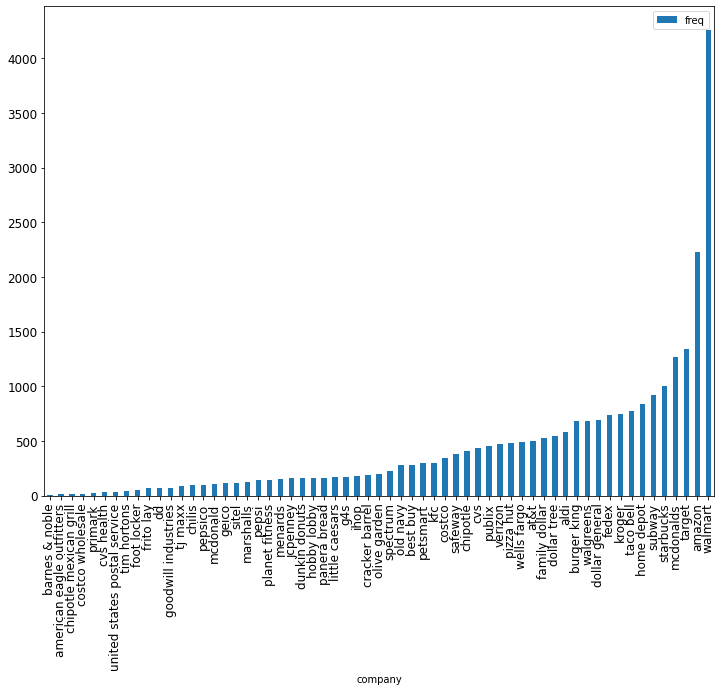

In [89]:
_company_freqs_df = pd.DataFrame(_company_freqs[:-1], columns=['company', 'freq'])
_company_freqs_df.plot.bar(x='company', y='freq', rot=90, fontsize=12, figsize=(12,9))

In [56]:
ee_emb_df = pd.read_csv(ee_emb_path)
_emb_company_df = ee_emb_df[ee_emb_df['concept'] == 'company']
_emb_company_list = _emb_company_df['neighbor'].tolist()

ee_lm_df = pd.read_csv(ee_LM_path)
_lm_company_df = ee_lm_df[ee_lm_df['concept'] == 'company']
_lm_company_list = _lm_company_df['neighbor'].tolist()

len(_emb_company_list), len(_lm_company_list)

(8059, 8037)

In [101]:
for _e, _cnt in _company_freqs:
    print(f'{_e:24s}',
          _cnt,
          _emb_company_list.index(_e) if _e in _emb_company_list else -1,
          _lm_company_list.index(_e) if _e in _lm_company_list else -1)

barnes & noble           4 3865 150
american eagle outfitters 12 3212 1050
chipotle mexican grill   15 2000 1490
costco wholesale         19 847 705
primark                  22 1013 996
cvs health               30 1937 205
united states postal service 37 399 1793
tim hortons              47 221 448
foot locker              50 171 4058
frito lay                67 32 4141
dd                       68 83 1615
goodwill industries      69 147 323
tj maxx                  88 48 403
chilis                   94 312 1573
pepsico                  101 52 41
mcdonald                 109 249 308
geico                    112 29 67
sitel                    114 41 2410
marshalls                127 34 161
pepsi                    144 38 8
planet fitness           146 64 454
menards                  154 23 6720
jcpenney                 158 20 2679
dunkin donuts            162 42 4135
hobby lobby              164 72 1344
panera bread             165 10 1208
little caesars           170 73 461
g4s         

In [61]:
_entity = 'barnes & noble'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

In my experience , booksellers at Barnes & Noble are not the cream of the crop employees , despite the company 's pretentious attitude towards applicants .

Working hours at Barnes & Noble are not great unless you are a manager .

The best age to work at Barnes & Noble is in your early 20 's , especially while going to school .

ask each customer to make a charitable donation of a book to a Barnes & Noble designated charity -- on and on --- overall , they just want to suck as much money out of each customer as possible .

I have never work at Barnes & Noble before , I would like to work there , Because I Love the books .

It is rather simple and easy to apply online , on the Barnes & Noble website .

Barnes & Noble is a very sales - driven environment where your ability to sell memberships and upsell Café items is paramount .

I always regret I could'nt find a career with Barnes & Noble , but it was not in the cards .

They took over the Barnes & Noble contract from Control Security an

In [63]:
_entity = 'american eagle outfitters'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

It took American Eagle Outfitters less than a week to schedule my training day after getting the position .

No orientation is not paid for at American Eagle Outfitters

No you do not have to be a certain height to work at American Eagle Outfitters .

In able to work at American Eagle Outfitters , you have to be at least the age of seventeen .

Working at American Eagle Outfitters on Sunday , you get time and a half .

No , they did not drug test at American Eagle Outfitters .



In [64]:
_entity = 'chipotle mexican grill'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

I got my first interview at Chipotle Mexican Grill after I applied online .

Chipotle mexican grill is a worldwide company and we have locations in Germany , London , and Canada .

I really would not mind working at a new location for Chipotle Mexican Grill , but I would have to think twice about it .

I applied for chipotle Mexican grill they never called me

Chipotle Mexican Grill terminated me as an employee .

Chipotle Mexican Grill pays bi weekly .

  I do Hope Chipotle Mexican Grill so they can fix there management .

You must be 16 years of age in order to work a Chipotle Mexican Grill .



In [65]:
_entity = 'costco wholesale'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

The overall work environment at Costco Wholesale was very strenuous .

Costco Wholesale is a great company with great benefits .

Never work at Costco wholesale

Looking to seek Employee with Costco Wholesale

References within Costco Wholesale whom are employed already .

Yes Costco Wholesale does through and complete background checks on all prospective hires .

You have to be 18 or older to work for Costco wholesale pretty sure a HS deploma or GED was required

I was hired to work at Costco Wholesale in May of 2016 .

Hi , My Costco wholesale is the very .

Good managed company by it 's CA , we are the most interested to work with the Costco wholesale .



In [66]:
_entity = 'chilis'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

A necessary qualification of a chilis restaurant manager would be respect .

You must be 16 or older to work at chilis .

At the Chilis I work at you can have dark colors nothing bright

They will usually train you or start you off ad a host then move you up from there depending on what your chilis does .

Chilis pays 2.13 .

No , because the schedule would be confusing and if you are already employed at a chilis you can only transfer to another one .

Chef 's pants hat and shirt made by chilis

Do i qualify to work with chilis

What is Chilis music policy

I have never felt more unhappy in a work place than I did working at this Chilis .

.unfortunately had to transfer to the chili 's in galveston tx ... i had the notion that all chilis would be like my home store .. boy was i ever wrong .. the store was ran so poorly that i caught myself saying , " i ca nt wait to get off so i can leave this place" .. i never felt so unappreciated or tooken advantage of by their management staff ... 

In [85]:
_entity = 'retail'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

STANDARD INTERVIEW QUESTIONS FOR RETAIL POSITIONS .

Why I was interested in retail ?

Very friendly , they just want to get to know you and see how much experience you have with retail .

I am sure there is always a need for   employees and quite honestly you can find a positon that fits you because the is a huge volume   of everything in the clothing , retail , cashier gift cards and have ahuge parking lot close to condominuim and several offices .

Yes , they 're always looking for new employees to help out during the holidays and its a great place to start work in retail .

this is retail store so this is ok

This only applies to the retail side of Marshall 's .

It is retail so my schedule is different every week .

I did n't mind it at first for a part time job to have me do something while I was in community college , but now that I left I 'd say that this is a great first job if you 're wanting to experience what retail is like .

This was a training position that focused train

  Then I worked my 3rd and 4th days on a clearance sale .... with a new key holder .. who had zero retail or managerial experience .

Dollar General is just like every other retail employer .

Management is just as sketchy as at any other retail company .


 You could tell the store manager had no experience in retail .

This is a warning for anyone enrty level or advanced in retail DO NOT WORK FOR DOLLAR GENERAL ! ! ! !

Bi weekly , maybe a year , if you like retail you 'll fit in just fine .

I have lots of retail and customer service experience and management experience

I have a retail fraud   misdemeanor   it was 8 years ago do u think dollar general will hold that against me

This is retail not warehouse .

Retail experience

Plus it does n't hurt if you are young and / or a sketchy character .. a retail employers delight .

You will not be hired for a retail position if you have a theft charge .

This goes for most if not all retail jobs .

It 's a typical retail job .

Theft an

  I found one of the MOST DIFFICULT parts of my job was being an INTERIOR DESIGNER IN A RETAIL ENVIRONMENTAL .



 The store manager sets the culture and our store 's manager came from a VP Operations position ( when his layer of mgmt was eliminated ) , with apparently little front line retail experience , resulting in poor accountability for co - workers .

if you 've worked in retail , you 'll make more than the base pay . )

Because it is retail and not many people can maneuver their lives to fit their job .

If I remember correctly , no experience was required to work there , but it definitely would n't hurt to have a little retail and customer service experience if possible .

I have a retail 8 yrs ago will it show up om back ground



 
  Though my experience has been in construction , retail , automotive , 
 and gas sales , in operating my own businesses I have acquired the ability 
 to adjust and conform to all and any business environments .

It Is Retail .

Yes , this is the 

In [74]:
_entity = 'career'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(d['company'], ':', _sent)
        print()

Marshalls : I graduated college and wanted to pursue a career in the field I studied for .

Marshalls : If an associate shows high level of responsibility and works hard , she / he can rise in their career and get higher position

AT&T : Your expereince and future career goals .

AT&T : My career path is not oriented to Sales .

AT&T : Career Development

AT&T : I left to make career moves .

AT&T : Career change

AT&T : Wanted career advancement

AT&T : Wanted career advancement .

AT&T : I expend my career

AT&T : Career bildup

AT&T : On the sideline side the managers are career blockers .

AT&T : Pay more , look for people to grow and develop and help them move in their career path .

AT&T : Better career opportunity

AT&T : Not many career opportunities of advancement

AT&T : More work life balance 
 Career advancement 
 More income

AT&T : I started right out of high school and had been my only career , but the last three to four years has been the ultimate worst side of our comp


Burger King : Present motivating career opportunities to their employees

Burger King : For a lack of career opportunity

Burger King : I left my job at Burger King because I was looking to get my foot in the door of a lifelong career .

Burger King : Good company to work starting a fresh career

Burger King : Not sure , was not part of my career when I worked there .

Burger King : N / A , I put N / A because I do n't know what Tri City Foods is , but I want to do more with my life then just cleaning and taking orders , I wanna make it a career and have fun .

Burger King : This is a good job to have as a stepping stone to a career .

T-Mobile :   The Customers Depend on the Service provider for Timely , Accurate Friendly and Considerate   assistance - the service provider depends on you to excel in your training and to care enuff about your Job to show up On Time - EVERYTIME - do this and you will be on your way to a long career , if you so choose .

T-Mobile : I have been in IT for

United States Postal Service : If you 're a career employee you can but if you 're a casual , PSE or MHA you will have to reapply since under your contract the postal service does n't hold you 're employment spot as they do career employees

United States Postal Service : Not really : I 've retired after a forty year career .

United States Postal Service : There is so much expected of you whether you are career or not .

United States Postal Service : No work / life balance , can take years if ever to become a career employee .

United States Postal Service : They will not make it a career position

United States Postal Service :   Also they told us that it would take about 4 to 5 years to become a full time ( career ) carrier .

United States Postal Service :   Tried to make a career but got a lifelong injury and terminated instead .

United States Postal Service : After being a rca for a year i thought the job was mine after the career carrier quit .

United States Postal Service : 


Costco Wholesale :   I 've worked in the same location my entire career .

Costco Wholesale : $ 11.50 , probably $ 13.50 now , but it was like my third job in my whole career and I was a student at the time so it satisfied my needs as a teen .

Frito-Lay : Thank you for your interest and when you feel that the opportunity with having a career with Frito Lay you are welcome to apply .

Frito-Lay : To advance in my career .

Whataburger : They are also generally put on a faster track of career advancement , making it less advantageous for staff to remain there for long .

Menards : You have to go to Menards.com and click on career opportunities .

Menards : Too bad the lazy career welfare people could n't do the same .

Menards : I decided to take a different career path and I thank the people of Menards for allowing me to work with them .

Menards : If its management and career advancement look out for yourself , and know what you want ie department manager , store manager ... and know

### benefits

In [90]:
_benefits_freqs = []
for _e in all_benchmark_instances['benefits']:
    try:
        _freq = embed_num_dict[_e]
        _benefits_freqs.append((_e, _freq))
    except:
        continue
_benefits_freqs.sort(key=lambda p: p[-1])

In [91]:
_benefits_freqs

[('health benefits', 4),
 ('tuition assistance', 20),
 ('monthly bonus', 23),
 ('retirement plan', 32),
 ('paid vacations', 36),
 ('prescription drugs', 46),
 ('401k plan', 50),
 ('pension', 51),
 ('401 k', 71),
 ('sick leave', 133),
 ('life insurance', 183),
 ('health care', 222),
 ('healthcare', 233),
 ('sick days', 248),
 ('401k', 640),
 ('health insurance', 782),
 ('health', 1294)]

In [94]:
_benefits_freqs_df = pd.DataFrame(_benefits_freqs, columns=['benefits', 'freq'])

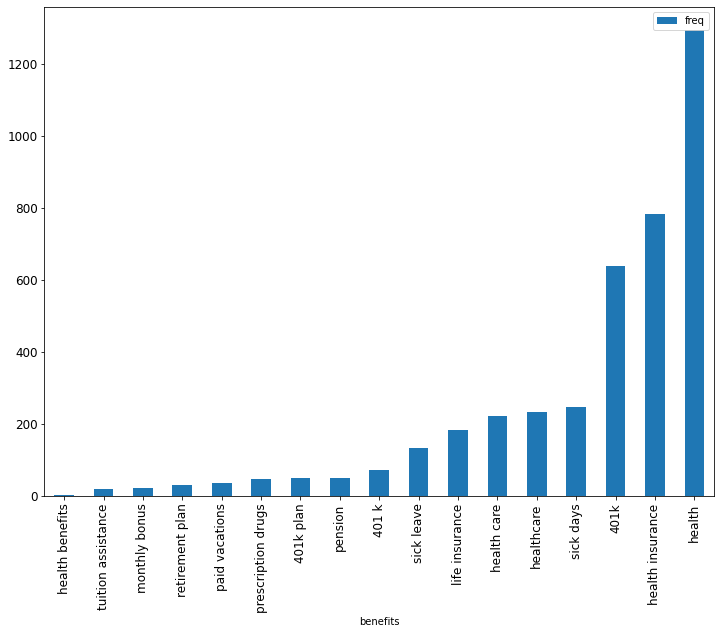

In [95]:
_benefits_freqs_df.plot.bar(x='benefits', y='freq', rot=90, fontsize=12, figsize=(12,9))

In [97]:
ee_emb_df = pd.read_csv(ee_emb_path)
_emb_benefits_df = ee_emb_df[ee_emb_df['concept'] == 'benefits']
_emb_benefits_list = _emb_benefits_df['neighbor'].tolist()

ee_lm_df = pd.read_csv(ee_LM_path)
_lm_benefits_df = ee_lm_df[ee_lm_df['concept'] == 'benefits']
_lm_benefits_list = _lm_benefits_df['neighbor'].tolist()

len(_emb_benefits_list), len(_lm_benefits_list)

(8058, 8036)

In [99]:
for _e, _cnt in _benefits_freqs:
    print(f'{_e:24s}',
          _cnt,
          _emb_benefits_list.index(_e) if _e in _emb_benefits_list else -1,
          _lm_benefits_list.index(_e) if _e in _lm_benefits_list else -1)

health benefits          4 3255 13
tuition assistance       20 944 125
monthly bonus            23 809 142
retirement plan          32 73 124
paid vacations           36 64 70
prescription drugs       46 570 322
401k plan                50 326 672
pension                  51 62 1
401 k                    71 302 3307
sick leave               133 -1 -1
life insurance           183 7 16
health care              222 1 22
healthcare               233 0 101
sick days                248 9 494
401k                     640 -1 -1
health insurance         782 -1 -1
health                   1294 6 9


In [102]:
_entity = 'tuition assistance'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

The tuition assistance is TRASH ! !

No amazon do not have tuition assistance for part time employees .

Tuition assistance is provided based on the program and school you choose , and is available for consideration after one consecutive year of work with the company .

As soon as you get through your trial period you can apply for the tuition assistance .

They offer medical plans , tuition assistance , sick days(in small increments based on time worked ) , paid time off(again in small increments . ) ,

After one year of working for Chipotle , students are offered tuition assistance if they are not offered federal financial assistance .

Yes you need to work there for a year to sign up for tuition assistance .

Lots of training opportunities and Tuition Assistance .

Yes $ 6000 of tuition assistance .

  Tuition assistance is available the very first day you start .

There is also , tuition assistance program for promotion within the company .

No , however , they do offer tuition ass

In [103]:
_entity = '401k plan'

for d in sent_dicts:
    _sent = ' '.join(d['tokens'])
    if f' {_entity} ' in f' {_sent} '.lower():
        print(_sent)
        print()

401k Plan medical and dental paid vacation raise after 90 days

There is a 401k plan , but I ca n't remember if it 's 3 months or 1 year after being with them .

They paid me once a week which was great , they have a good 401k plan and good health benefits

The Starbucks was inside of Kroger so you receive Kroger benefits as well such as 401k plan

The company benefits are full benefits , 401k plan , PTO , Bonuses , Company Perks

Heath care 
 dental 
 vision 
 awesome 401k plan

Standard health benefits , school reimbursement , 401k plan

1 year in order to get tuition for school and i believe the 401k plan is instant .

They do not have a 401k plan

I do not have a 401k plan

No I do not have a 401k plan .

No i do not have 401k plan

No I do n't have a 401k plan but I do know it is a option .

Yes wlgreens does offer you a 401k plan .

401k plan after 6 months or 1 year .

After a year you can start a 401k plan , get health and dental , along with buying stocks .

Wal - mart 's bene

## Relational context analysis

In [130]:
def get_masked_contexts_for_entities_with_rels(entities,
                                               input_corpus,
                                               with_entities):
    """Return a (list of) sentence(s) with entity replaced with MASK."""
    """YS: input should be sentences_with_company.json"""
    
    ent_freq = {ent : 0 for ent in entities}
    ent_context = {ent : [] for ent in entities}
    
#     with open(input_file, "r") as fin:
#         lines = fin.readlines()
#     for line in tqdm(lines, total=len(lines), desc="loading corpus"):
#         json_dict = json.loads(line)
    for json_dict in input_corpus:
        sent = ' ' + ' '.join(json_dict['tokens']).lower() + ' '
        #entities = [match.group(1) for match in re.finditer(pat, line)]

        if not any([f' {_e} ' in sent for _e in with_entities]):
            # not including with_entities
            continue

        for entity in entities:
            pat = f' {entity} '
            if pat not in sent:
                continue

            context = sent.replace(pat, ' [MASK] ').strip()
            c = context.split('[MASK]')
            if len(c) != 2:  # sanity to not have too many repeating phrases in the context
                continue

            # ignore too short contexts
            if len(context) < 15:
                continue

            # print(entity)
            # print(context)

            _freq = ent_freq.get(entity, 0)
            ent_freq[entity] = _freq + 1

            context_lst = ent_context.get(entity, [])
            context_lst.append(context)
            ent_context[entity] = context_lst

    dedup_context = {}
    for e, v in ent_context.items():
        dedup_context[e] = list(set(v))
    return ent_freq, dedup_context


In [131]:
corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

In [133]:
get_masked_contexts_for_entities_with_rels(entities=["home depot", "subway", "starbucks", "mcdonalds"],
    input_corpus=sent_dicts,
    with_entities=["health insurance", "flexible schedule", "401k", "paid vacation", "sick leave", "vision insurance"])

({'home depot': 1, 'subway': 0, 'starbucks': 4, 'mcdonalds': 4},
 {'home depot': ['no , since obama care [MASK] dropped health insurance for part time employees'],
  'subway': [],
  'starbucks': ['the [MASK] was inside of kroger so you receive kroger benefits as well such as 401k plan',
   'you have to work a full 32 + hours a week to get health insurance in [MASK] .',
   'yes , 401k , and 30 % off items for [MASK] .',
   'yes , all [MASK] partners averaging 20 hours or more per work week are eligible for medical benefits , 401k , and stock options .'],
  'mcdonalds': ['the reason for leaving [MASK] was due to the flexible schedule',
   'i was offered 401k with [MASK] .',
   'do [MASK] pay you on sick leave to',
   'no managers at this [MASK] receive health insurance of any kind .']})

### All companies, all benefits

In [134]:
concepts_df = load_seed_aligned_concepts(seed_aligned_concepts_path)
seed_instances_dict = dict(zip(concepts_df['alignedCategoryName'], concepts_df['seedInstances']))

_collected_company = list(all_benchmark_instances['company'] | set(seed_instances_dict['company']))
_collected_benefits = list(all_benchmark_instances['benefits'] | set(seed_instances_dict['benefits']))

In [136]:
_company_cnt, _company_contexts = get_masked_contexts_for_entities_with_rels(
    entities=_collected_company,
    input_corpus=sent_dicts,
    with_entities=_collected_benefits
)

In [137]:
_company_cnt_list = sorted(_company_cnt.items(), key=lambda p: p[1])
_company_cnt_list

[('frito-lay', 0),
 ('spectrum', 0),
 ('allied universal security services, systems and solutions', 0),
 ('t-mobile', 0),
 ('marriott international, inc.', 0),
 ("dick's sporting goods", 0),
 ('alorica', 0),
 ("macy's", 0),
 ("kohl's", 0),
 ('ross dress for less', 0),
 ('microsoft', 0),
 ('geico', 0),
 ('olive garden', 0),
 ("mcdonald's", 0),
 ('electric', 0),
 ('ulta', 0),
 ("chili's", 0),
 ('concentrix', 0),
 ("dunkin' donuts", 0),
 ("lowe's", 0),
 ("domino's", 0),
 ('kroger stores', 0),
 ('sonic drive-in', 0),
 ('subways', 0),
 ('costco wholesale', 0),
 ('chipotle mexican grill', 0),
 ('chick-fil-a', 0),
 ("victoria's secret", 0),
 ('goodwill industries', 0),
 ('quiktrip', 0),
 ('barnes & noble', 0),
 ('american eagle outfitters', 0),
 ("the wendy's company", 0),
 ('teleperformance', 0),
 ('united states postal service', 0),
 ('dunkin donuts', 0),
 ('tim hortons', 0),
 ('frito lay', 0),
 ('t.j. maxx', 0),
 ("sam's club", 0),
 ("applebee's", 0),
 ('burlington stores', 0),
 ('chilis',

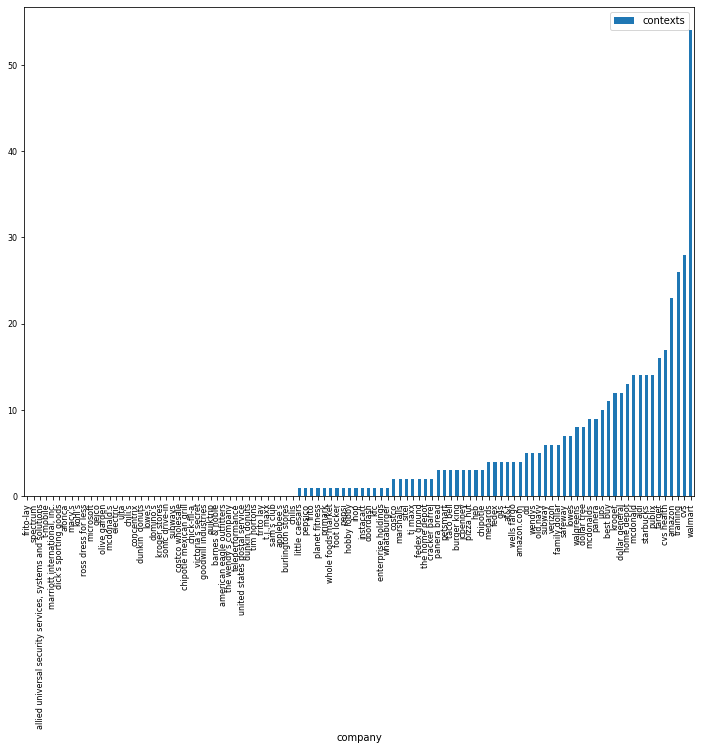

In [138]:
_company_cnt_df = pd.DataFrame(_company_cnt_list, columns=['company', 'contexts'])
_company_cnt_df.plot.bar(x='company', y='contexts', rot=90, fontsize=8, figsize=(12,9))

### Single companies, all concepts, embedding t-SNE

In [127]:
bert_tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased')
bert_model = AutoModel.from_pretrained('bert-base-uncased')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model.to(device)
bert_model.eval()

mask_token_id = bert_tokenizer.mask_token_id

In [139]:
_company = 'walmart'

cc_embeddings = dict()
for _cc, _seeds in seed_instances_dict.items():
    if _cc == 'company':
        continue
    
    _collected_cc_entities = list(all_benchmark_instances[_cc] | set(_seeds))
    print(_cc, _collected_cc_entities)
    
    # Get masked contexts
    _, _contexts = get_masked_contexts_for_entities_with_rels(
        entities=[_company],
        input_corpus=sent_dicts,
        with_entities=_collected_cc_entities
    )
    _contexts = _contexts[_company]
    if len(_contexts) == 0:
        continue
    
    # Compute context embedding 
    en_context_lst = _contexts
    chunks = [en_context_lst[i:i + 100] for i in range(0, len(en_context_lst), 100)]
    # print(entity)
    # print(len(en_context_lst))
    _all_context_embeddings = []
    for chunk in chunks:
        _encoded_input = bert_tokenizer.batch_encode_plus(chunk, return_token_type_ids=True, add_special_tokens=True, max_length=128, return_tensors='pt', padding=True, pad_to_max_length=True, truncation=True)
        _mask = _encoded_input['input_ids'] != mask_token_id
        with torch.no_grad():
            _encoded_input = ensure_tensor_on_device(device, **_encoded_input)
            _model_output = bert_model(**_encoded_input)  # Compute token embeddings
        _context_embeddings = mean_pooling(_model_output, _mask)  # mean pooling
        _all_context_embeddings.append(_context_embeddings)

    assert len(_all_context_embeddings) > 0

    _entity_embedding = torch.mean(torch.cat(_all_context_embeddings, dim=0), dim=0).cpu().detach().numpy().tolist()
    cc_embeddings[_cc] = _entity_embedding
    

dress_code ['wear fake nails', 'fake nails', 'jewelry', 'tattoos', 'shirt', 'brown pants', 'color hair', 'pants', 'black slacks', 'dress pants', 'lab coats', 'black jeans', 'shirts', 'facial piercings', 'uniform', 'face tattoos', 'strict dress code', 'polo shirts', 'hairnets', 'hair net', 'mustaches', 'natural colors', 'red shirts', 'resistant shoes', 'hair color', 'shoes', 'wear jeans', 'wear shorts', 'casual dress code', 'casual', 'hat', 'non slip shoes', 'unnatural hair color', 'piercings', 'unnatural hair colors', 'professional', 'unnatural colored hair', 'hats', 'nose rings', 'colorful hair', 'skirts', 'scrubs', 'dress shirts', 'attire', 'jeans', 'uniforms', 'uniform policy', 'natural colored hair', 'blue collar', 'business casual', 'uniform shirts', 'facial hair', 'ponytail', 'black pants', 'shorts', 'hair colors']
job_position ['sales associate', 'barista', 'delivery driver', 'servers', 'shift leader', 'cashier', 'store manager', 'dishwasher', 'package handler', 'truck drivers',

In [140]:
len(cc_embeddings)

13

In [144]:
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')
embeddings_df = load_embeddings(bert_emb_path, 768)
_company_embedding_all = embeddings_df[embeddings_df['entity'] == _company]['embedding'].item()
cc_embeddings['all'] = _company_embedding_all

In [150]:
tsne = TSNE()
_concepts, _raw_embs = zip(*cc_embeddings.items())
_tsne_embs = tsne.fit_transform(_raw_embs).tolist()

In [151]:
list(zip(_concepts, _tsne_embs))

[('dress_code', [-145.94862365722656, 57.3772087097168]),
 ('job_position', [-39.565086364746094, -108.43943786621094]),
 ('pay_schedule', [152.2614288330078, -63.55064010620117]),
 ('benefits', [-43.94044494628906, 73.60016632080078]),
 ('compensation', [2.41005277633667, -4.917022228240967]),
 ('payment_option', [90.35870361328125, 19.138399124145508]),
 ('background_screening', [192.3670196533203, 35.36241912841797]),
 ('person', [57.58891296386719, -88.47061920166016]),
 ('hire_prerequisite', [-11.17064094543457, 181.2088165283203]),
 ('shifts', [-95.37789154052734, -26.44676971435547]),
 ('schedule', [85.98265838623047, 201.17864990234375]),
 ('employee_type', [-105.84320068359375, 156.29014587402344]),
 ('onboarding_steps', [44.008026123046875, 97.65530395507812]),
 ('all', [141.7953643798828, 119.18583679199219])]

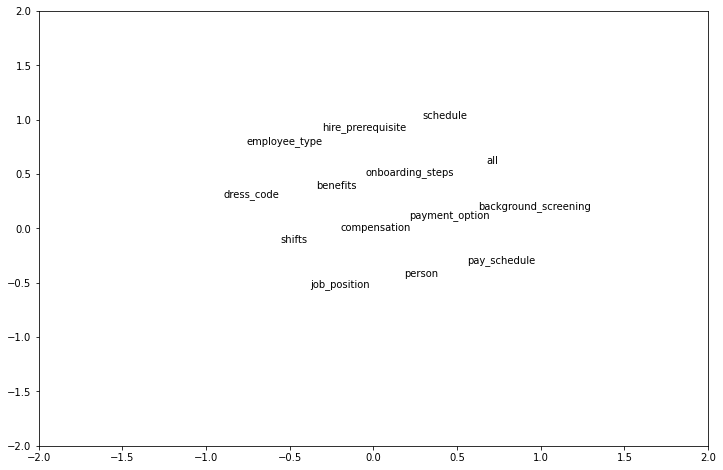

In [165]:
_tsne_x, _tsne_y = list(zip(*_tsne_embs))

fig = plt.figure(figsize=(12, 8))
ax = fig.gca()

for _cc, _emb in list(zip(_concepts, _tsne_embs)):
    ax.text(x=_emb[0]/200, y=_emb[1]/200, s=_cc, ha='center')

# ax.legend()
ax.set_xlim((-2, 2))
ax.set_ylim((-2, 2))
fig.show()

## EE labels preprocessing

In [75]:
raw_EE_emb_labeling_file = os.path.join(base_dir, f'data/indeed-benchmark/ee-emb-labels.csv')
raw_EE_LM_labeling_file = os.path.join(base_dir, f'data/indeed-benchmark/ee-lm-labels.csv')

out_EE_label_file = os.path.join(base_dir, f'data/indeed-benchmark/ee-labels.csv')

In [76]:
_raw_emb = pd.read_csv(raw_EE_emb_labeling_file)
_raw_lm = pd.read_csv(raw_EE_LM_labeling_file)

_raw_emb_gold = _raw_emb[_raw_emb['Majority'] == 1].to_dict('records')
_raw_lm_gold = _raw_lm[_raw_lm['Majority'] == 1].to_dict('records')
len(_raw_emb_gold), len(_raw_lm_gold)

(623, 676)

In [77]:
gold_labels_dict = dict()
for d in _raw_emb_gold + _raw_lm_gold:
    _cc = d['concept']
    _e = d['neighbor']
    gold_labels_dict[_cc] = gold_labels_dict.get(_cc, []) + [_e]

for _cc, _e_list in gold_labels_dict.items():
    gold_labels_dict[_cc] = list(set(_e_list))

In [78]:
for _cc, _e_list in gold_labels_dict.items():
    print(f'{_cc}: {len(_e_list)}')

company: 119
dress_code: 261
job_position: 127
pay_schedule: 37
benefits: 91
compensation: 42
payment_option: 30
background_screening: 84
person: 42
hire_prerequisite: 109
shifts: 70
schedule: 62
employee_type: 25
onboarding_steps: 20


In [79]:
gold_labels_list = []
for _cc, _e_list in gold_labels_dict.items():
    for _e in _e_list:
        gold_labels_list.append((_cc, _e))
pd.DataFrame(gold_labels_list, columns=['concept', 'neighbor']).to_csv(out_EE_label_file, index=False)

## Entity expansion evaluation
Now using benchmark entities, mean reciprocal rank

In [129]:
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations.csv')
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_1000.csv')

seed_aligned_concepts = load_seed_aligned_concepts(seed_aligned_concepts_path)
seed_aligned_relations = load_seed_aligned_relations(seed_aligned_relations_path)
benchmark = pd.read_csv(benchmark_path)
concept_knn = pd.read_csv(concept_knn_path)

print(seed_aligned_concepts['alignedCategoryName'].tolist())
print(seed_aligned_relations['alignedRelationName'].tolist())
print(set(concept_knn['concept'].tolist()))
print(benchmark.shape)

['company', 'dress_code', 'job_position', 'pay_schedule', 'benefits', 'compensation', 'payment_option', 'background_screening', 'person', 'hire_prerequisite', 'shifts', 'schedule', 'employee_type', 'onboarding_steps']
['has_pay_schedule', 'has_pay_schedule', 'has_dress_code', 'has_dress_code', 'has_background_screening', 'has_benefits', 'has_benefits', 'hires_person', 'has_compensation', 'has_compensation', 'has_hire_prerequisite', 'operates_on', 'hires_employee_type', 'has_onboarding_steps', 'has_shifts', 'has_shifts', 'has_job_position', 'has_hiring_policy', 'has_payment_option']
{'onboarding_steps', 'pay_schedule', 'shifts', 'schedule', 'company', 'job_position', 'hire_prerequisite', 'payment_option', 'benefits', 'background_screening', 'person', 'employee_type', 'dress_code', 'compensation'}
(706, 17)


In [62]:
def evaluate_EE(predictions_path,
                seed_concepts_path,
                seed_relations_path,
                benchmark_path):
    '''Format of prediction file: CSV, with column "concept" and "neighbor"(entity) '''
    preds_df = pd.read_csv(predictions_path)
    
    all_benchmark_instances, _ = load_benchmark(benchmark_path, seed_concepts_path, seed_relations_path)
    seed_aligned_concepts = load_seed_aligned_concepts(seed_concepts_path)
    
    mrr_dict = dict()
    for i, d in seed_aligned_concepts.iterrows():
        a_concept = d["alignedCategoryName"]
        u_concept = d["unalignedCategoryName"]
        seed_instances = d["seedInstances"]

#         concept_knn_instances = concept_knn[concept_knn["concept"] == a_concept]["neighbor"].to_list()
        pred_instances = preds_df[preds_df["concept"] == a_concept]["neighbor"].to_list()

#         _b_head_instances = benchmark[benchmark["n_head_category"] == a_concept]["n_head"].to_list()
#         _b_tail_instances = benchmark[benchmark["n_tail_category"] == a_concept]["n_tail"].to_list()
#         benchmark_instances = list(set(_b_head_instances + _b_tail_instances))
        benchmark_instances = all_benchmark_instances[a_concept]

        print(f'Concept: {a_concept} / {u_concept}')
        print(f'seeds: {seed_instances}')
        b_inst_ranks = dict()
        recip_ranks = []
        for _inst in benchmark_instances:
            if _inst in seed_instances:
                b_inst_ranks[_inst] = -1
            elif _inst in pred_instances:
                _rank = pred_instances.index(_inst) + 1
                b_inst_ranks[_inst] = _rank
                recip_ranks.append(1.0 / _rank)
            else:
                b_inst_ranks[_inst] = float('nan')
                recip_ranks.append(0.0)
                
        mrr = np.mean(recip_ranks) if len(recip_ranks) > 0 else 0.0
        mrr_dict[a_concept] = mrr
        print(json.dumps(b_inst_ranks, indent=4))
        print('MRR:', mrr)
        print()

    print('--- Summary ---')
    print(json.dumps(mrr_dict, indent=2))

In [ ]:
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations_nodup.csv')
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_1000.csv')

evaluate_EE(predictions_path=concept_knn_path,
            seed_concepts_path=seed_aligned_concepts_path,
            seed_relations_path=seed_aligned_relations_path,
            benchmark_path=benchmark_path)

In [ ]:
# Use script
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_concept_corr_k=100.csv \
# -rank sim+margin \
# -rev

In [81]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_concept_knn_k=None.csv \
-rank sim \
-rev

--- Summary ---
Concept                   MRR    P@100   R@100    P@1k    R@1k  
company                  0.0403  0.5800  0.5043  0.0650  0.5652 
dress_code               0.0178  0.5400  0.2126  0.1240  0.4882 
job_position             0.0269  0.2500  0.2083  0.0740  0.6167 
pay_schedule             0.0565  0.0500  0.1471  0.0140  0.4118 
benefits                 0.0347  0.1500  0.1744  0.0370  0.4302 
compensation             0.0170  0.1100  0.2821  0.0260  0.6667 
payment_option           0.0860  0.1200  0.4444  0.0190  0.7037 
background_screening     0.0344  0.2300  0.2805  0.0590  0.7195 
person                   0.0062  0.0700  0.2059  0.0170  0.5000 
hire_prerequisite        0.0180  0.1400  0.1333  0.0480  0.4571 
shifts                   0.0548  0.3600  0.5143  0.0480  0.6857 
schedule                 0.0269  0.1100  0.1964  0.0280  0.5000 
employee_type            0.0297  0.0700  0.3182  0.0170  0.7727 
onboarding_steps         0.0790  0.0400  0.2000  0.0110  0.5500 



In [82]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_concept_contr_knn_k=None.csv \
-rank sim \
-rev

--- Summary ---
Concept                   MRR    P@100   R@100    P@1k    R@1k  
company                  0.0342  0.5800  0.5043  0.0690  0.6000 
dress_code               0.0175  0.7300  0.2874  0.5995  0.9370 
job_position             0.0168  0.4100  0.3417  0.2368  0.6333 
pay_schedule             0.0145  0.1600  0.1176  0.1600  0.1176 
benefits                 0.0322  0.4300  0.5000  0.4286  0.5233 
compensation             0.0288  0.2200  0.5641  0.1667  0.6410 
payment_option           0.0879  0.1900  0.7037  0.1187  0.7037 
background_screening     0.0397  0.3700  0.4512  0.0531  0.5732 
person                   0.0176  0.1100  0.3235  0.0462  0.6176 
hire_prerequisite        0.0309  0.4400  0.4190  0.2685  0.5524 
shifts                   0.0178  0.1100  0.1571  0.0228  0.2143 
schedule                 0.0101  0.2000  0.3571  0.1390  0.4643 
employee_type            0.0338  0.0700  0.3182  0.0714  0.3636 
onboarding_steps         0.0829  0.0700  0.3500  0.0100  0.5000 



In [83]:
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_concept_contr_knn_k=None.csv \
-rank sim+margin \
-rev

--- Summary ---
Concept                   MRR    P@100   R@100    P@1k    R@1k  
company                  0.0369  0.6200  0.5391  0.0690  0.6000 
dress_code               0.0209  0.8700  0.3425  0.5995  0.9370 
job_position             0.0184  0.4600  0.3833  0.2368  0.6333 
pay_schedule             0.0171  0.1600  0.1176  0.1600  0.1176 
benefits                 0.0404  0.4300  0.5000  0.4286  0.5233 
compensation             0.0379  0.2300  0.5897  0.1667  0.6410 
payment_option           0.0755  0.1900  0.7037  0.1187  0.7037 
background_screening     0.0279  0.3700  0.4512  0.0531  0.5732 
person                   0.0385  0.1100  0.3235  0.0462  0.6176 
hire_prerequisite        0.0280  0.4700  0.4476  0.2685  0.5524 
shifts                   0.0183  0.1000  0.1429  0.0228  0.2143 
schedule                 0.0124  0.2200  0.3929  0.1390  0.4643 
employee_type            0.0345  0.0700  0.3182  0.0714  0.3636 
onboarding_steps         0.0659  0.0700  0.3500  0.0100  0.5000 



In [84]:
# Use script
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_LM_bert_k=None.csv


--- Summary ---
Concept                   MRR    P@100   R@100    P@1k    R@1k  
company                  0.0402  0.6000  0.5217  0.0820  0.7130 
dress_code               0.0214  0.8800  0.3465  0.1970  0.7756 
job_position             0.0400  0.8600  0.7167  0.1120  0.9333 
pay_schedule             0.1089  0.3200  0.9412  0.0340  1.0000 
benefits                 0.0540  0.6600  0.7674  0.0770  0.8953 
compensation             0.0663  0.3000  0.7692  0.0380  0.9744 
payment_option           0.1080  0.2100  0.7778  0.0220  0.8148 
background_screening     0.0516  0.5600  0.6829  0.0750  0.9146 
person                   0.1001  0.2800  0.8235  0.0300  0.8824 
hire_prerequisite        0.0348  0.5800  0.5524  0.0850  0.8095 
shifts                   0.0645  0.6300  0.9000  0.0680  0.9714 
schedule                 0.0673  0.5100  0.9107  0.0530  0.9464 
employee_type            0.1302  0.1800  0.8182  0.0220  1.0000 
onboarding_steps         0.1167  0.1900  0.9500  0.0200  1.0000 



In [103]:
# Use script
!python eval_entities.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/ee_mrr_combine_k=None.csv


--- Summary ---
Concept                   MRR    P@100   R@100    P@1k    R@1k  
company                  0.0435  0.8400  0.7304  0.1150  1.0000 
dress_code               0.0224  0.9100  0.3583  0.2540  1.0000 
job_position             0.0322  0.7600  0.6333  0.1200  1.0000 
pay_schedule             0.0676  0.3300  0.9706  0.0340  1.0000 
benefits                 0.0519  0.6500  0.7558  0.0860  1.0000 
compensation             0.0640  0.3300  0.8462  0.0390  1.0000 
payment_option           0.1078  0.2700  1.0000  0.0270  1.0000 
background_screening     0.0457  0.5500  0.6707  0.0820  1.0000 
person                   0.0840  0.2800  0.8235  0.0340  1.0000 
hire_prerequisite        0.0364  0.5700  0.5429  0.1050  1.0000 
shifts                   0.0484  0.5200  0.7429  0.0690  0.9857 
schedule                 0.0504  0.4400  0.7857  0.0560  1.0000 
employee_type            0.1023  0.2000  0.9091  0.0220  1.0000 
onboarding_steps         0.1137  0.1700  0.8500  0.0200  1.0000 



# LM probes

## Probability-based

In [37]:
lm_probe_gpt2 = LMProbe_GPT2()

In [38]:
ee_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_100.csv')
ee_df = pd.read_csv(ee_path)
ee_df.shape

(1356, 3)

### has_dress_code

In [39]:
_r = 'has_dress_code'

_r_row = seed_relations_df[seed_relations_df['alignedRelationName'] == _r].iloc[0]
_h_type = _r_row['domain']
_t_type = _r_row['range']
print(_h_type, _t_type)

company dress_code


In [40]:
_seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _h_type]['seedInstances'].item()
_seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _t_type]['seedInstances'].item()
_seed_heads, _seed_tails

(['walmart', 'amazon', 'subway', 'microsoft', 'target'],
 ['business casual',
  'uniform',
  'hair color',
  'tattoos',
  'facial hair',
  'shoes',
  'piercings'])

In [42]:
_cand_heads = ee_df[ee_df['concept'] == _h_type]['neighbor'].tolist()
_cand_tails = ee_df[ee_df['concept'] == _t_type]['neighbor'].tolist()
len(_cand_heads), len(_cand_tails)

(97, 94)

In [63]:
_template = 'walmart allows [MASK].'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

[(0, {'cand': 'body piercings', 'score': 0.002457509326813575}),
 (1, {'cand': 'facial piercings', 'score': 0.0021192399895008725}),
 (2, {'cand': 'ear piercings', 'score': 0.0019278434892669512}),
 (3, {'cand': 'face piercings', 'score': 0.0017361913249576018}),
 (4, {'cand': 'nose piercings', 'score': 0.0017143651784431442}),
 (5, {'cand': 'visible piercings', 'score': 0.0012390717683459865}),
 (6, {'cand': 'leggings', 'score': 0.0011862801946265714}),
 (7, {'cand': 'flip flops', 'score': 0.0011396856372157989}),
 (8, {'cand': 'chilis', 'score': 0.001127743414615599}),
 (9, {'cand': 'little caesars', 'score': 0.0008004799350692819}),
 (10, {'cand': 'common sense', 'score': 0.0007569520623752813}),
 (11, {'cand': 'kroger', 'score': 0.0007509511175223724}),
 (12, {'cand': 'strict dress code', 'score': 0.0007379959875833076}),
 (13, {'cand': 'publix', 'score': 0.0006212025041699539}),
 (14, {'cand': 'casual wear', 'score': 0.0005990662535303998}),
 (15, {'cand': 'cell phones', 'score': 

In [68]:
_template = 'walmart allows [MASK] and jeans.'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

[(0, {'cand': 'leggings', 'score': 0.0026494025030625867}),
 (1, {'cand': 'body piercings', 'score': 0.002413165540068098}),
 (2, {'cand': 'facial piercings', 'score': 0.002037490574634625}),
 (3, {'cand': 'ear piercings', 'score': 0.0019686087207748102}),
 (4, {'cand': 'face piercings', 'score': 0.0017579750998315724}),
 (5, {'cand': 'skinny jeans', 'score': 0.0017518271213956627}),
 (6, {'cand': 'nose piercings', 'score': 0.0017098611068448854}),
 (7, {'cand': 'chilis', 'score': 0.0014580513443831775}),
 (8, {'cand': 't shirts', 'score': 0.001452686930789666}),
 (9, {'cand': 'ripped jeans', 'score': 0.001436489871252126}),
 (10, {'cand': 'flip flops', 'score': 0.0013027341342922597}),
 (11, {'cand': 'visible piercings', 'score': 0.0012349110164999871}),
 (12, {'cand': 'clean shaven', 'score': 0.0011952109489552396}),
 (13, {'cand': 'casual dress', 'score': 0.0010492319432645972}),
 (14, {'cand': 'strict dress code', 'score': 0.0010215963984162532}),
 (15, {'cand': 'little caesars', '

In [70]:
_template = 'walmart allows jeans, [MASK] and shirts.'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

[(0, {'cand': 'leggings', 'score': 0.007950546441326894}),
 (1, {'cand': 'flip flops', 'score': 0.007075774192646608}),
 (2, {'cand': 'body piercings', 'score': 0.004914083630190951}),
 (3, {'cand': 'facial piercings', 'score': 0.004597808759751709}),
 (4, {'cand': 'face piercings', 'score': 0.0043870840422136044}),
 (5, {'cand': 'ear piercings', 'score': 0.0041138407839033326}),
 (6, {'cand': 'nose piercings', 'score': 0.00399272590388933}),
 (7, {'cand': 'skinny jeans', 'score': 0.0034459863528698465}),
 (8, {'cand': 'chilis', 'score': 0.0031630352135805905}),
 (9, {'cand': 't shirts', 'score': 0.002985829794833979}),
 (10, {'cand': 'clean shaven', 'score': 0.0029825413102062613}),
 (11, {'cand': 'casual wear', 'score': 0.002949264294126706}),
 (12, {'cand': 'casual clothes', 'score': 0.002920548747288794}),
 (13, {'cand': 'scrubs', 'score': 0.002811236868204438}),
 (14, {'cand': 'casual clothing', 'score': 0.0026647520828171887}),
 (15, {'cand': 'ripped jeans', 'score': 0.0026136734

In [66]:
_template = 'walmart allows [MASK] dress code.'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

[(0, {'cand': 'strict dress code', 'score': 0.001481640258458578}),
 (1, {'cand': 'dress code', 'score': 0.0014614049244089245}),
 (2, {'cand': 'body piercings', 'score': 0.0012826025523101547}),
 (3, {'cand': 'facial piercings', 'score': 0.001111195240394938}),
 (4, {'cand': 'chilis', 'score': 0.0010555130843792743}),
 (5, {'cand': 'face piercings', 'score': 0.0010318043150511994}),
 (6, {'cand': 'ear piercings', 'score': 0.0010116660144114564}),
 (7, {'cand': 'clean shaven', 'score': 0.0009866746238043995}),
 (8, {'cand': 'leggings', 'score': 0.000976672849359097}),
 (9, {'cand': 'pretty much', 'score': 0.0009054636827680127}),
 (10, {'cand': 'nose piercings', 'score': 0.000851258895619425}),
 (11, {'cand': 'kroger', 'score': 0.0008211024331508483}),
 (12, {'cand': 'common sense', 'score': 0.0008111552234457245}),
 (13, {'cand': "mcdonald 's", 'score': 0.0007937432171385823}),
 (14, {'cand': 'casual wear', 'score': 0.0007158583567161564}),
 (15, {'cand': 'visible piercings', 'score':

In [67]:
_template = 'walmart allows dress code [MASK].'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

[(0, {'cand': 'facial piercings', 'score': 0.0024681891038005298}),
 (1, {'cand': 'leggings', 'score': 0.0024557826536680217}),
 (2, {'cand': 'body piercings', 'score': 0.0023139781380786006}),
 (3, {'cand': 'ear piercings', 'score': 0.0020149633466706694}),
 (4, {'cand': 'dress codes', 'score': 0.0018968910464227896}),
 (5, {'cand': 'face piercings', 'score': 0.0017684080012686362}),
 (6, {'cand': 'nose piercings', 'score': 0.0015449002044813037}),
 (7, {'cand': 'dress code', 'score': 0.0014614049244089245}),
 (8, {'cand': 'flip flops', 'score': 0.0013433120763974267}),
 (9, {'cand': 'visible piercings', 'score': 0.0012572251272025877}),
 (10, {'cand': 'chilis', 'score': 0.0011977886276130956}),
 (11, {'cand': 'strict dress code', 'score': 0.0010226954789166708}),
 (12, {'cand': 'casual wear', 'score': 0.0009943724307336559}),
 (13, {'cand': 'kroger', 'score': 0.0009048788386481821}),
 (14, {'cand': 'uniform policy', 'score': 0.0008681796947668647}),
 (15, {'cand': 't shirts', 'score'

In [71]:
_template = 'walmart allows wearing [MASK].'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

[(0, {'cand': 'ear piercings', 'score': 0.0028285219463860057}),
 (1, {'cand': 'facial piercings', 'score': 0.002760509035081923}),
 (2, {'cand': 'body piercings', 'score': 0.002678974198245505}),
 (3, {'cand': 'leggings', 'score': 0.0026481382079254147}),
 (4, {'cand': 'flip flops', 'score': 0.0023722809729632035}),
 (5, {'cand': 'face piercings', 'score': 0.0022416971554271286}),
 (6, {'cand': 'visible piercings', 'score': 0.0020508082141699894}),
 (7, {'cand': 'nose piercings', 'score': 0.0018044117899724422}),
 (8, {'cand': 'chilis', 'score': 0.0011598017129516335}),
 (9, {'cand': 'strict dress code', 'score': 0.0009696177402124964}),
 (10, {'cand': 'skinny jeans', 'score': 0.0008879986995992568}),
 (11, {'cand': 'cell phones', 'score': 0.0008738993766711747}),
 (12, {'cand': 'little caesars', 'score': 0.0008699902601876318}),
 (13, {'cand': 'casual clothes', 'score': 0.0008195209935461452}),
 (14, {'cand': 'casual clothing', 'score': 0.000776383193831136}),
 (15, {'cand': 'nail po

In [81]:
# Microsoft 
_template = 'microsoft allows [MASK].'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

[(0, {'cand': 'facial piercings', 'score': 0.005131491638383358}),
 (1, {'cand': 'ear piercings', 'score': 0.004585294029525217}),
 (2, {'cand': 'body piercings', 'score': 0.003921686298146271}),
 (3, {'cand': 'face piercings', 'score': 0.0031354570810024963}),
 (4, {'cand': 'nose piercings', 'score': 0.0027180962206184954}),
 (5, {'cand': 'visible piercings', 'score': 0.0024973917008433094}),
 (6, {'cand': 'flip flops', 'score': 0.002464597392923424}),
 (7, {'cand': 'leggings', 'score': 0.002399294901892428}),
 (8, {'cand': 'common sense', 'score': 0.0023571218728802986}),
 (9, {'cand': 'kroger', 'score': 0.002186137623079781}),
 (10, {'cand': 'chilis', 'score': 0.00146357862761529}),
 (11, {'cand': 'walgreens', 'score': 0.001443502549508646}),
 (12, {'cand': 'cell phones', 'score': 0.0014306609753049991}),
 (13, {'cand': 'little caesars', 'score': 0.0011527207685542477}),
 (14, {'cand': 'pretty much', 'score': 0.001133674745327496}),
 (15, {'cand': 'dress codes', 'score': 0.001070258

In [82]:
_template = 'microsoft allows jeans, [MASK] and shirts.'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

[(0, {'cand': 'leggings', 'score': 0.011639003395122744}),
 (1, {'cand': 'flip flops', 'score': 0.010187015990838816}),
 (2, {'cand': 'body piercings', 'score': 0.006771256912652817}),
 (3, {'cand': 'facial piercings', 'score': 0.006146955837318614}),
 (4, {'cand': 'face piercings', 'score': 0.005689742589356696}),
 (5, {'cand': 'ear piercings', 'score': 0.005570401935557938}),
 (6, {'cand': 'nose piercings', 'score': 0.005167720282261649}),
 (7, {'cand': 'skinny jeans', 'score': 0.0046533507278853185}),
 (8, {'cand': 't shirts', 'score': 0.004396851636340999}),
 (9, {'cand': 'scrubs', 'score': 0.004259382685681133}),
 (10, {'cand': 'casual wear', 'score': 0.0040216165931792796}),
 (11, {'cand': 'casual clothes', 'score': 0.004000789351740254}),
 (12, {'cand': 'chilis', 'score': 0.003826438920917085}),
 (13, {'cand': 'clean shaven', 'score': 0.0037780096027934633}),
 (14, {'cand': 'casual clothing', 'score': 0.003673589683874928}),
 (15, {'cand': 'ripped jeans', 'score': 0.003457362711

### has_background_screening

In [88]:
_r = 'has_background_screening'

_r_row = seed_relations_df[seed_relations_df['alignedRelationName'] == _r].iloc[0]
_h_type = _r_row['domain']
_t_type = _r_row['range']
print(_h_type, _t_type)

_seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _h_type]['seedInstances'].item()
_seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _t_type]['seedInstances'].item()
print(_seed_heads, _seed_tails)

_cand_heads = ee_df[ee_df['concept'] == _h_type]['neighbor'].tolist()
_cand_tails = ee_df[ee_df['concept'] == _t_type]['neighbor'].tolist()
print(len(_cand_heads), len(_cand_tails))

company background_screening
['walmart', 'amazon', 'subway', 'microsoft', 'target'] ['drug test', 'criminal background check', 'employment verification']
97 98


In [89]:
# Microsoft 
_template = 'microsoft checks for [MASK].'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

[(0, {'cand': 'social security number', 'score': 0.00967370585243785}),
 (1, {'cand': 'social media', 'score': 0.006814719668781803}),
 (2, {'cand': '3rd party', 'score': 0.005623028742419336}),
 (3, {'cand': 'medical marijuana', 'score': 0.005576631489645706}),
 (4, {'cand': 'security', 'score': 0.005313690267456273}),
 (5, {'cand': 'pepsi', 'score': 0.004624428986203844}),
 (6, {'cand': 'dmv', 'score': 0.004621810069762703}),
 (7, {'cand': 'criminal history', 'score': 0.004327335073637574}),
 (8, {'cand': 'prescription drugs', 'score': 0.004281529567134396}),
 (9, {'cand': 'credit history', 'score': 0.004206326165478303}),
 (10, {'cand': 'background check', 'score': 0.0037203841976300744}),
 (11, {'cand': 'information', 'score': 0.003274573554407912}),
 (12, {'cand': 'criminal record', 'score': 0.003207046246963472}),
 (13, {'cand': 'driving records', 'score': 0.0031807310871282118}),
 (14, {'cand': 'red flag', 'score': 0.0031463603404955375}),
 (15, {'cand': 'results', 'score': 0.00

In [90]:
_template = 'microsoft checks for drugs, [MASK] and felonies.'
_res = lm_probe_gpt2.score_candidates(input_txt=_template, cands=_cand_tails)
list(enumerate(_res))

[(0, {'cand': 'felonies', 'score': 0.01516646935956221}),
 (1, {'cand': 'prescription drugs', 'score': 0.011885881149477627}),
 (2, {'cand': 'medical marijuana', 'score': 0.010467892956586459}),
 (3, {'cand': 'driving records', 'score': 0.010466824834294093}),
 (4, {'cand': 'criminal history', 'score': 0.009802336845795}),
 (5, {'cand': 'urinalysis', 'score': 0.00935846962827782}),
 (6, {'cand': 'social media', 'score': 0.00902758474867163}),
 (7, {'cand': 'random drug tests', 'score': 0.008979560701904594}),
 (8, {'cand': 'theft', 'score': 0.008648832614668301}),
 (9, {'cand': 'social security number', 'score': 0.008124969683677905}),
 (10, {'cand': 'drugs', 'score': 0.007956045460315156}),
 (11, {'cand': 'driving record', 'score': 0.007886045868525577}),
 (12, {'cand': 'criminal record', 'score': 0.00782942356684066}),
 (13, {'cand': 'drug tests', 'score': 0.007756816207904721}),
 (14, {'cand': 'background check', 'score': 0.007601147598827872}),
 (15, {'cand': 'police', 'score': 0.0

## PMI-based

In [73]:
lm_probe_pmi = LMProbe_PMI()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### has_dress_code

In [77]:
_template = '[HEAD] allows [TAIL].'
_res = []
for _t in _cand_tails:
    _pmi = lm_probe_pmi.score_candidate_pair(input_txt=_template, head='walmart', tail=_t)
    _res.append((_t, _pmi))
_res.sort(key=lambda p: p[1], reverse=True)
list(enumerate(_res))

[(0, ('skinny jeans', 1.7007861824747987)),
 (1, ('ripped jeans', 1.6993845223320854)),
 (2, ('toe shoes', 1.6054258767986518)),
 (3, ('footwear', 1.5746784908726603)),
 (4, ('walgreens', 1.2629208308137088)),
 (5, ('clothing', 1.1406507913653137)),
 (6, ('food', 1.0607585856806026)),
 (7, ('chilis', 1.0425372959880317)),
 (8, ('cotton', 1.0241613351869407)),
 (9, ('kroger', 0.9855455156929835)),
 (10, ('drugs', 0.9373130204554361)),
 (11, ('t shirts', 0.8552137597299598)),
 (12, ('logos', 0.8480405204208097)),
 (13, ('flip flops', 0.8030754786973962)),
 (14, ('body piercings', 0.7505834320845839)),
 (15, ('cell phones', 0.7472124673710514)),
 (16, ('menards', 0.7390790543684655)),
 (17, ("mcdonald 's", 0.6566597240635872)),
 (18, ('casual clothing', 0.6487234682393588)),
 (19, ('clean shaven', 0.6099347481461752)),
 (20, ('facial piercings', 0.6082469269685653)),
 (21, ('casual clothes', 0.5855459290520759)),
 (22, ('nonslip shoes', 0.5829083852322086)),
 (23, ('logo', 0.5687275217164

In [78]:
_template = '[HEAD] allows dress code [TAIL].'
_res = []
for _t in _cand_tails:
    _pmi = lm_probe_pmi.score_candidate_pair(input_txt=_template, head='walmart', tail=_t)
    _res.append((_t, _pmi))
_res.sort(key=lambda p: p[1], reverse=True)
list(enumerate(_res))

[(0, ('clothing', 2.839382282949322)),
 (1, ('casual clothing', 2.7114202058740293)),
 (2, ('skinny jeans', 2.6998737773366663)),
 (3, ('t shirts', 2.4980212564410333)),
 (4, ('casual clothes', 2.348157078772047)),
 (5, ('footwear', 2.247782385738841)),
 (6, ('ripped jeans', 2.0088285198090468)),
 (7, ('facial jewelry', 1.9817987887398303)),
 (8, ('brand', 1.9788341990932885)),
 (9, ('casual wear', 1.950882851612361)),
 (10, ('food', 1.913408348501651)),
 (11, ('weather', 1.8836279328446537)),
 (12, ('cotton', 1.8032085420055193)),
 (13, ('casual dress', 1.7832829068012988)),
 (14, ('bright colors', 1.7270256765349714)),
 (15, ('regular clothes', 1.6546217254208457)),
 (16, ('colored hair', 1.642594930169631)),
 (17, ('dyed hair', 1.5812794404145674)),
 (18, ('natural colors', 1.5811907154970974)),
 (19, ('dress codes', 1.56775725985516)),
 (20, ('watch', 1.526584788796617)),
 (21, ('color hair', 1.5223552029821104)),
 (22, ('logos', 1.5118594931207578)),
 (23, ('drugs', 1.482095781640

In [80]:
_template = '[HEAD] allows [TAIL].'
_res = []
for _t in _cand_tails:
    _pmi = lm_probe_pmi.score_candidate_pair(input_txt=_template, head='microsoft', tail=_t)
    _res.append((_t, _pmi))
_res.sort(key=lambda p: p[1], reverse=True)
list(enumerate(_res))

[(0, ('cap', 1.8354876631325787)),
 (1, ('caps', 1.707747239455344)),
 (2, ('publix', 1.6758239729029611)),
 (3, ('logos', 1.668547425072024)),
 (4, ('logo', 1.666601080505222)),
 (5, ('flip flops', 1.3733281777299897)),
 (6, ('walgreens', 1.3654359143761834)),
 (7, ('kroger', 1.256029700606529)),
 (8, ('chipotle', 1.23321206797557)),
 (9, ('cvs', 1.1247991124453485)),
 (10, ('clean shaven', 0.9918629326613946)),
 (11, ('t shirts', 0.9024144092564246)),
 (12, ('dd', 0.8902223730000021)),
 (13, ("mcdonald 's", 0.8179853290218908)),
 (14, ('pharmacist', 0.8069473747021867)),
 (15, ('strict dress code', 0.803854084518866)),
 (16, ('scrubs', 0.7737434868954356)),
 (17, ('leggings', 0.7088003146637458)),
 (18, ('chilis', 0.6796830440020738)),
 (19, ('nonslip shoes', 0.6422482602655784)),
 (20, ('cracker barrel', 0.4757341749201007)),
 (21, ('face piercings', 0.38605877757896856)),
 (22, ('acrylic nails', 0.3774815865780621)),
 (23, ('american eagle', 0.3289561379208763)),
 (24, ('body pierc

In [79]:
_template = '[HEAD] allows dress code [TAIL].'
_res = []
for _t in _cand_tails:
    _pmi = lm_probe_pmi.score_candidate_pair(input_txt=_template, head='microsoft', tail=_t)
    _res.append((_t, _pmi))
_res.sort(key=lambda p: p[1], reverse=True)
list(enumerate(_res))

[(0, ('brand', 3.3570923076434482)),
 (1, ('weather', 2.5939279146985488)),
 (2, ('professional', 1.8889908937316182)),
 (3, ('security', 1.819708254432995)),
 (4, ('dd', 1.5471662294419346)),
 (5, ('pretty much', 1.4610388439833581)),
 (6, ('cell phones', 1.4162957518953014)),
 (7, ('logo', 1.4054664955015994)),
 (8, ('cargo', 1.3759941875578487)),
 (9, ('bright colors', 1.2964571219129954)),
 (10, ('chipotle', 1.229967249658598)),
 (11, ('watch', 1.1556858305979514)),
 (12, ('nice', 1.062043640044811)),
 (13, ('logos', 1.0234360949811077)),
 (14, ('polish', 0.9666419124743548)),
 (15, ('natural colors', 0.8952257936140668)),
 (16, ('kroger', 0.8834695666335985)),
 (17, ('flip flops', 0.8453092605796702)),
 (18, ('cvs', 0.8054650053453969)),
 (19, ('pizza hut', 0.753401510947791)),
 (20, ('language', 0.6543601791398963)),
 (21, ('band', 0.6068158272919639)),
 (22, ('t shirts', 0.5511307777824772)),
 (23, ('walgreens', 0.5000878910095068)),
 (24, ('facial jewelry', 0.49054453303066303)

In [84]:
# To generate prompts? (not working: high-PMI prompts not ruling out "close" wrong entities)

_template = 'microsoft allows [HEAD] [TAIL].'
_res = []

for _t in _cand_tails:
    _pmi = lm_probe_pmi.score_candidate_pair(input_txt=_template, head='jeans', tail=_t)
    _res.append((_t, _pmi))
_res.sort(key=lambda p: p[1], reverse=True)
list(enumerate(_res))

[(0, ('brand', 2.836499242328607)),
 (1, ('gym', 2.0836396393135566)),
 (2, ('clothing', 1.989636515387236)),
 (3, ('polish', 1.4944544274602016)),
 (4, ('logos', 1.1038919461611947)),
 (5, ('ripped jeans', 0.7089294700635325)),
 (6, ('food', 0.6784839985753788)),
 (7, ('dyed hair', 0.6750289119839437)),
 (8, ('logo', 0.6096959703662908)),
 (9, ('professional', 0.6000085476653769)),
 (10, ('skinny jeans', 0.554691466100742)),
 (11, ('cotton', 0.5087695812951498)),
 (12, ('long', 0.4946422066865832)),
 (13, ('toe shoes', 0.4897722315410675)),
 (14, ('watch', 0.4710102486487546)),
 (15, ('pretty much', 0.4091548613211806)),
 (16, ('nice', 0.36440043935617794)),
 (17, ('casual wear', 0.3626817908491802)),
 (18, ('ankle', 0.311855853140921)),
 (19, ('skin', 0.2848392226589773)),
 (20, ('t shirts', 0.2535049107879921)),
 (21, ('tattoo', 0.24953514533054566)),
 (22, ('casual clothing', 0.20594327763005538)),
 (23, ('casual dress', 0.14932458134851956)),
 (24, ('band', 0.14142856476581223)),


In [85]:
_template = 'microsoft allows [HEAD] [TAIL].'
_res = []

for _t in _cand_tails:
    _pmi = lm_probe_pmi.score_candidate_pair(input_txt=_template, head='business casual', tail=_t)
    _res.append((_t, _pmi))
_res.sort(key=lambda p: p[1], reverse=True)
list(enumerate(_res))

[(0, ('casual wear', 1.674703276385717)),
 (1, ('casual dress', 1.5428160622004299)),
 (2, ('casual clothing', 1.4830445215717383)),
 (3, ('casual clothes', 1.3942031134928747)),
 (4, ('nice', 1.0670218352365133)),
 (5, ('professional', 0.6009544473080837)),
 (6, ('sports', 0.5757313147716605)),
 (7, ('clothing', 0.49017770176774)),
 (8, ('brand', 0.32945999320439157)),
 (9, ('watch', -0.3176078460514322)),
 (10, ('logos', -0.31877757536699747)),
 (11, ('long', -0.36164522460447657)),
 (12, ('uniform policy', -0.3968619276385592)),
 (13, ('pretty much', -0.4295946856411206)),
 (14, ('cvs', -0.8067561968759858)),
 (15, ('clean cut', -0.9098555061384843)),
 (16, ('skin', -0.9939743048209415)),
 (17, ('gym', -1.0554833061261242)),
 (18, ('american eagle', -1.0584207603115594)),
 (19, ('drugs', -1.1603808805664215)),
 (20, ('cotton', -1.1689905805022232)),
 (21, ('ripped jeans', -1.2244442556977617)),
 (22, ('nonslip shoes', -1.2359739874603903)),
 (23, ('menards', -1.2372464260858855)),
 

In [86]:
_template = '[HEAD] allows [TAIL] clothing.'
_res = []
for _t in _cand_tails:
    _pmi = lm_probe_pmi.score_candidate_pair(input_txt=_template, head='microsoft', tail=_t)
    _res.append((_t, _pmi))
_res.sort(key=lambda p: p[1], reverse=True)
list(enumerate(_res))

[(0, ('dd', 3.4354041911906847)),
 (1, ('logo', 3.218013248069047)),
 (2, ('cell phones', 3.0525003706881026)),
 (3, ('tattoo', 2.866432679182555)),
 (4, ('logos', 2.774819810578707)),
 (5, ('brand', 2.638744791655915)),
 (6, ('publix', 2.572774862079383)),
 (7, ('kroger', 2.5235999124554507)),
 (8, ('chipotle', 2.4866423469629577)),
 (9, ('walgreens', 2.460500894906213)),
 (10, ('flip flops', 2.3273731935258937)),
 (11, ('casual clothing', 2.1134527127540164)),
 (12, ('fake nails', 1.9733734444249844)),
 (13, ('band', 1.9603933558273994)),
 (14, ('facial jewelry', 1.9083648274721394)),
 (15, ('facial piercings', 1.8699574963509278)),
 (16, ('face piercings', 1.858510538621287)),
 (17, ('strict dress code', 1.8192156140435465)),
 (18, ('visible tattoos', 1.8170276819736113)),
 (19, ('pizza hut', 1.8047631043589938)),
 (20, ('skinny jeans', 1.7926869884214334)),
 (21, ('natural colors', 1.7770176991835456)),
 (22, ('body piercings', 1.7397680559165103)),
 (23, ('casual wear', 1.68517716

## LM correlation-based

### BERT

In [226]:
# corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

# with open(corpus_path, 'r') as f:
#     sent_dicts = [json.loads(l) for l in f]

In [227]:
lm_probe = LMProbe()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [228]:
# input_file_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sent_segmentation.txt')
# ent_freq, dedup_context = get_masked_contexts(input_file_path)

corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')
embed_num_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembednum+seeds.txt')

entities, dedup_context = get_masked_contexts(corpus_path, embed_num_path)

In [229]:
len(entities), len(set(entities)), len(dedup_context)

(8064, 8064, 7921)

In [230]:
all_ents_tokenized = [tuple(lm_probe.tokenizer.tokenize(e)) for e in entities]
all_ents_tokenized = list(set(all_ents_tokenized))
[sum([len(e_t) == _l for e_t in all_ents_tokenized]) for _l in (1,2,3,4,5)]

[2372, 4132, 1144, 314, 55]

In [247]:
## TODO: keep rank in output

def entity_expansion_corr(seed_concepts_path=seed_aligned_concepts_path,
                          all_contexts=dedup_context, 
                          all_ents_tokenized=all_ents_tokenized, 
                          lm_probe=lm_probe,
                          max_allowed_ngrams=3,
                          max_contexts=50,
                          top_k=100):
    if lm_probe is None:
        lm_probe = LMProbe()
        
    seed_concepts_df = load_seed_aligned_concepts(seed_concepts_path)
    
#     if contexts is None:
#         try:
#             contexts = dedup_context[entity]
#         except KeyError:
#             print(f'"{entity}" not an extracted entity!')
#             return None

    _out_records = []

    for i, (a_concept, u_concept, gnrl, seed_instances) in tqdm(seed_concepts_df.iterrows(), total=seed_concepts_df.shape[0]):
        _expand_set = set()
        _expand_records = []
        
        for _inst in seed_instances:
            print(f'{a_concept} :: {_inst}')
            try:
                contexts = all_contexts[_inst]
            except KeyError:
                print(f'"{_inst}" not an extracted entity!')
                continue
            if len(contexts) < 2:
                print(f'"{_inst}" only have {len(contexts)} context')
                continue

            _entity_pieces = lm_probe.tokenizer.tokenize(_inst)
            if len(_entity_pieces) > max_allowed_ngrams:
                print(f'{_entity_pieces} too many word pieces (max {max_allowed_ngrams})')
                continue

            entity2probs = defaultdict(list)

            for _context in contexts[:max_contexts]:
                for n_grams in range(1, max_allowed_ngrams+1):
                    _ctxt = _context.replace('[MASK]', '[MASK]' + ' [MASK]' * (n_grams-1))
                    _ctxt = '[CLS] ' + _ctxt + ' [SEP]'
                    _cands = [e_t for e_t in all_ents_tokenized if len(e_t) == n_grams]
                    _cand_scores = lm_probe.score_candidates(_ctxt, _cands)

                    for _d in _cand_scores:
                        _c = ' '.join(_d['cand']).replace(' ##', '')
                        _s = _d['score']
                        entity2probs[_c].append(_s)

        #     print('entity2probs:', len(entity2probs), len(entity2probs[entity]))
            for _e, _ss in entity2probs.items():
                assert len(_ss) == len(entity2probs[_inst]), \
                    f'entity: {_e} | {lm_probe.tokenizer.tokenize(_e)}\n\
                    len(_ss) = {len(_ss)}\n\
                    len(entity2probs["{entity}"]) = {len(entity2probs[entity])}'

            _target_ss = entity2probs[_inst]
            _target_ss = _target_ss / np.sum(_target_ss)

        #     print(_target_ss.shape, _target_ss)

            mean_l = [(_e, np.mean(_ss)) for _e, _ss in entity2probs.items()]
            mean_l.sort(key=lambda p : p[-1], reverse=True)
            kl_l = [(_e, entropy(_target_ss, _ss)) for _e, _ss in entity2probs.items()]
            kl_l.sort(key=lambda p : p[-1], reverse=False)
            pearson_l = [(_e, pearsonr(_target_ss, _ss)[0]) for _e, _ss in entity2probs.items()]
            pearson_l.sort(key=lambda p : p[-1], reverse=True)

            entity2ranks = defaultdict(list)
            entity2scores = defaultdict(dict)
            for i, (_e, _s) in enumerate(mean_l):
                entity2ranks[_e].append(i)
                entity2scores[_e]["mean"] = _s
            for i, (_e, _s) in enumerate(kl_l):
                entity2ranks[_e].append(i)
                entity2scores[_e]["kl"] = _s
            for i, (_e, _s) in enumerate(pearson_l):
                entity2ranks[_e].append(i)
                entity2scores[_e]["pearson"] = _s
            # To simile top-k set intersection, keep the highest rank of _e among each criteria
            entity_overall_ranks = [(_e, max(_ranks)) for _e, _ranks in entity2ranks.items()]
            entity_overall_ranks.sort(key=lambda p : p[-1])
            entity_overall_ranks_dict = dict(entity_overall_ranks)
#             # Now, the top-k is for the final selection, not for each criteria
            sel_entities = [_e for _e, _ in entity_overall_ranks[:top_k]]

#             ints_mean_l = [p for p in mean_l if p[0] in sel_entities]
#             ints_kl_l = [p for p in kl_l if p[0] in sel_entities]
#             ints_pearson_l = [p for p in pearson_l if p[0] in sel_entities]

#             return {
#                 "entity2probs": entity2probs,
#                 "mean_l": mean_l,
#                 "kl_l": kl_l,
#                 "pearson_l": pearson_l,
#                 "sel_entities": sel_entities,
#                 "ints_mean_l": ints_mean_l,
#                 "ints_kl_l": ints_kl_l,
#                 "ints_pearson_l": ints_pearson_l,
#             }

            for _e in sel_entities:
                if (_e in _expand_set) or (_e in seed_instances):
                    continue
                _expand_set.add(_e)
                _d = dict(entity2scores[_e])
                _d['max_rank'] = entity_overall_ranks_dict[_e]
                _expand_records.append((_e, _d))

#         for _inst in seed_instances:
#             _expand_set.discard(_inst)

        for _e, _d in _expand_records:
            _out_d = dict(_d)
            _out_d['concept'] = a_concept
            _out_d['neighbor'] = _e
            _out_records.append(_out_d)

    return _out_records

#### full run & save

In [248]:
corr_expansion_out_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_corr_100.csv')

In [ ]:
entity_expansion_corr(max_contexts=5)

In [263]:
# Use scripts
!python compute_EE_corr.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/concept_corr_100.csv \
-ng 3 \
-ct 50 \
-top_k 100

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
  0%|                                                    | 0/14 [00:00<?, ?it/s]company :: walmart
company :: amazon
company :: subway
company :: microsoft
company :: target
  7%|███▏                                        | 1/14 [01:13<16:01, 73.94s/it]dress_code :: business casual
dress_code :: uniform
dress_code :: hair color
dress_code :: tattoos
dress_code :: 

#### observations

In [20]:
_entity = 'health insurance'
_results = entity_expansion_multiways(_entity)

In [216]:
len(_results['sel_entities'])

20

In [217]:
_results['sel_entities']

['insurance',
 'health insurance',
 'life insurance',
 'property insurance',
 'disability insurance',
 'health care insurance',
 'personal life',
 'car insurance',
 'offer health insurance',
 'vision insurance',
 'medical insurance',
 'dental insurance',
 'social life',
 'healthcare',
 'vehicle insurance',
 'health care',
 'social services',
 'financial services',
 'personal property',
 'insurance company']

In [218]:
_entity = 'paid vacation'
_results = entity_expansion_multiways(_entity)

In [219]:
len(_results['sel_entities']), _results['sel_entities']

(20,
 ['paid vacation',
  'free food',
  'extra hours',
  'personal life',
  'additional training',
  'pay rent',
  'extra cash',
  'employment',
  'extra money',
  'regular employee',
  'actual training',
  'free market',
  'home office',
  'paid weekly',
  'lunch break',
  'employment contract',
  'paid vacations',
  'starting pay',
  'training class',
  'cash office'])

In [220]:
_results['ints_mean_l']

[('paid vacation', 0.0044874584203954135),
 ('free food', 0.0030260901631086125),
 ('employment', 0.0026738146242238693),
 ('additional training', 0.002321403750532552),
 ('pay rent', 0.0016830003481619713),
 ('extra money', 0.0012204012291167322),
 ('extra hours', 0.0012082061174470255),
 ('paid vacations', 0.00120581120557009),
 ('personal life', 0.001053836581509607),
 ('extra cash', 0.0009903957854880568),
 ('free market', 0.0007903035967739137),
 ('employment contract', 0.0007457378170482977),
 ('regular employee', 0.0007120051084749063),
 ('actual training', 0.0006806927853699615),
 ('home office', 0.0006772145559134888),
 ('paid weekly', 0.0006510896439229592),
 ('lunch break', 0.0006262294878335945),
 ('starting pay', 0.0005959591850205348),
 ('training class', 0.0005751933163302262),
 ('cash office', 0.0005385432788353982)]

In [222]:
_results['ints_kl_l']

[('paid vacation', 0.0),
 ('paid weekly', 0.3553680094673442),
 ('regular employee', 0.5651236328627899),
 ('starting pay', 0.6403464447016876),
 ('home office', 0.702709761379911),
 ('extra hours', 0.7882322979791239),
 ('cash office', 0.8216374067668454),
 ('additional training', 0.8231515801756707),
 ('free food', 0.8235410993620799),
 ('extra cash', 0.8406818348940776),
 ('lunch break', 0.8554870473017729),
 ('extra money', 0.8671142026312799),
 ('actual training', 0.8861361628894645),
 ('free market', 0.8934745945926472),
 ('personal life', 0.905080634158609),
 ('pay rent', 0.9191154476332102),
 ('training class', 0.9618010548607787),
 ('employment', 1.0064966364964134),
 ('employment contract', 1.0666759660272174),
 ('paid vacations', 1.07702367185203)]

In [221]:
_results['ints_pearson_l']

[('paid vacation', 1.0),
 ('paid weekly', 0.6898791401226259),
 ('personal life', 0.6470476793642793),
 ('home office', 0.6137368598658344),
 ('employment', 0.5939260343586834),
 ('regular employee', 0.5934659341843702),
 ('free food', 0.5814593375358278),
 ('actual training', 0.5171393046252428),
 ('extra hours', 0.48931553441132725),
 ('cash office', 0.4649905535739707),
 ('training class', 0.45922641771917155),
 ('additional training', 0.453205530878079),
 ('starting pay', 0.4452037644119071),
 ('employment contract', 0.439553353761904),
 ('pay rent', 0.4366836227238857),
 ('lunch break', 0.43380180618257874),
 ('extra cash', 0.4258937516890552),
 ('extra money', 0.4070871841193142),
 ('paid vacations', 0.4019298655642553),
 ('free market', 0.40088368759801624)]

In [223]:
entity2probs = _results['entity2probs']
_ser1 = entity2probs['paid vacation']
_ser2 = entity2probs['training class']
_ser3 = entity2probs['cash office']

_ser1 = (_ser1 - min(_ser1)) / (max(_ser1) - min(_ser1))
_ser2 = (_ser2 - min(_ser2)) / (max(_ser2) - min(_ser2))
_ser3 = (_ser3 - min(_ser3)) / (max(_ser3) - min(_ser3))

list(zip(dedup_context['paid vacation'], _ser1, _ser2, _ser3))

[('Both medical and dental insurance is provided as well as [MASK]',
  6.578818802360679e-06,
  0.00015682175491799882,
  0.0018069056141044838),
 ('No the [MASK] tome will be put on your final pay check',
  9.477934070825445e-05,
  0.00179112735515401,
  0.01783658171282455),
 ("A new policy came out apparently saying that you do n't get a week of [MASK] in the first year , if you start after June 1st .",
  0.4888658700418125,
  1.0,
  0.08162912113546698),
 ('It is very true that dollar tree do nt pay out your owed [MASK] when you are no longer working for them .',
  0.0022030048390930365,
  0.0038430425562789427,
  0.6893102387382053),
 ('But they offer no [MASK] and no sick leave .',
  0.026742685344147428,
  0.05176876375876567,
  0.25499081609946683),
 ('They give [MASK] and sick time , health and dental insurance , 401k , life insurance',
  0.9423141194865929,
  0.027970293703116284,
  0.8023113287226477),
 ('only assistant managers and general managers received [MASK] pay and s

In [ ]:
_entity = 'flexible schedule'
_results = entity_expansion_multiways(_entity)

In [ ]:
len(_results['mean_set'] & _results['kl_set'] & _results['pearson_set']), \
_results['mean_set'] & _results['kl_set'] & _results['pearson_set']

In [ ]:
_results['ints_mean_l']

In [ ]:
_results['ints_pearson_l']

In [ ]:
entity2probs = _results['entity2probs']
_ser1 = entity2probs['flexible schedule']
_ser2 = entity2probs['model']
_ser3 = entity2probs['low level']

_ser1 = (_ser1 - min(_ser1)) / (max(_ser1) - min(_ser1))
_ser2 = (_ser2 - min(_ser2)) / (max(_ser2) - min(_ser2))
_ser3 = (_ser3 - min(_ser3)) / (max(_ser3) - min(_ser3))

list(zip(dedup_context['flexible schedule'], _ser1, _ser2, _ser3))

In [ ]:
lm_probe.fill_multi_mask("[CLS] They have a very [MASK] [MASK] for most departments and if your schedule does n't fit , you 'll more than likely just be moved . [SEP]", topk=20)

In [ ]:
_entity = 'black jeans'
mean_set, kl_set, pearson_set = entity_expansion_multiways(_entity)

In [ ]:
len(mean_set & kl_set & pearson_set), mean_set & kl_set & pearson_set

In [ ]:
_entity = 'walmart'
mean_set, kl_set, pearson_set = entity_expansion_multiways(_entity)

In [ ]:
len(mean_set & kl_set & pearson_set), mean_set & kl_set & pearson_set

### GPT2

In [10]:
lm_probe_gpt2 = LMProbe_GPT2()

In [13]:
def entity_expansion_multiways_GPT2(entity, 
                                    contexts=None, 
                                    entities=entities, 
                                    lm_probe=lm_probe_gpt2, 
                                    top_k=20):
    if lm_probe is None:
        lm_probe = LMProbe_GPT2()
    if contexts is None:
        contexts = dedup_context[entity]
    
    # test: speed up x100
    entities = entities[::100]
    
    entity2probs = defaultdict(list)

    for _context in tqdm(contexts[:50]):
        _cand_scores = lm_probe.score_candidates(_context, entities)

        for _d in _cand_scores:
            _c = _d['cand']
            _s = _d['score']
            entity2probs[_c].append(_s)
    
#     print('entity2probs:', len(entity2probs), len(entity2probs[entity]))
    for _e, _ss in entity2probs.items():
        assert len(_ss) == len(entity2probs[entity]), \
            f'entity: {_e} | {lm_probe.tokenizer.tokenize(_e)}; len(_ss): {len(_ss)}'
    
    _target_ss = entity2probs[entity]
    _target_ss = _target_ss / np.sum(_target_ss)
    
    mean_l = [(_e, np.mean(_ss)) for _e, _ss in entity2probs.items()]
    mean_l.sort(key=lambda p : p[-1], reverse=True)
    kl_l = [(_e, entropy(_target_ss, _ss)) for _e, _ss in entity2probs.items()]
    kl_l.sort(key=lambda p : p[-1], reverse=False)
    pearson_l = [(_e, pearsonr(_target_ss, _ss)[0]) for _e, _ss in entity2probs.items()]
    pearson_l.sort(key=lambda p : p[-1], reverse=True)
    
    entity2ranks = defaultdict(list)
    for i, (_e, _s) in enumerate(mean_l):
        entity2ranks[_e].append(i)
    for i, (_e, _s) in enumerate(kl_l):
        entity2ranks[_e].append(i)
    for i, (_e, _s) in enumerate(pearson_l):
        entity2ranks[_e].append(i)
    # To simile top-k set intersection, keep the highest rank of _e among each criteria
    entity_overall_ranks = [(_e, max(_ranks)) for _e, _ranks in entity2ranks.items()]
    entity_overall_ranks.sort(key=lambda p : p[-1])
    # Now, the top-k is for the final selection, not for each criteria
    sel_entities = [_e for _e, _ in entity_overall_ranks[:top_k]]
    
#     mean_set = set([_e for _e, _s in mean_l[:top_k]])
#     kl_set = set([_e for _e, _s in kl_l[:top_k]])
#     pearson_set = set([_e for _e, _s in pearson_l[:top_k]])
    
#     sel_entities = mean_set & kl_set & pearson_set
    ints_mean_l = [p for p in mean_l if p[0] in sel_entities]
    ints_kl_l = [p for p in kl_l if p[0] in sel_entities]
    ints_pearson_l = [p for p in pearson_l if p[0] in sel_entities]
    
    return {
        "entity2probs": entity2probs,
        "mean_l": mean_l,
        "kl_l": kl_l,
        "pearson_l": pearson_l,
#         "mean_set": mean_set,
#         "kl_set": kl_set,
#         "pearson_set": pearson_set,
        "sel_entities": sel_entities,
        "ints_mean_l": ints_mean_l,
        "ints_kl_l": ints_kl_l,
        "ints_pearson_l": ints_pearson_l,
    }
    

In [ ]:
_entity = 'health insurance'
_results = entity_expansion_multiways_GPT2(_entity)

## BERT greedy-filling

In [380]:
class LMProbe_PMI(object):
    def __init__(self, model_name='bert-base-uncased', use_gpu=False):
        self.device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForMaskedLM.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()

        self.mask_token = self.tokenizer.mask_token

    def fill_multi_mask(self, input_txt, topk=3):
        raise NotImplementedError
    
    def score_tail(self, input_txt, tail, head=None, head_len=None, head_first=True):
        # input_txt: str, with [HEAD] for head and [TAIL] for tail 
        # tail: str, the tail entity 
        # head: str, the head entity 
        # head_len: int, the length of head entity
        # Should only give head or head_len 
        # head_first: bool, whether the first [MASK] is the head 
        
        assert (head is None) + (head_len is None) == 1, \
            f"head = {head}, head_len = {head_len}"
        assert input_txt.count("[HEAD]") == input_txt.count("[TAIL]") == 1, \
            f"Input string must have [HEAD] and [TAIL], got {input_txt}"
        
        
        tail_toks = self.tokenizer.tokenize(tail)
        tail_len = len(tail_toks)
        input_txt = input_txt.replace('[TAIL]', '[MASK]' + ' [MASK]' * (tail_len-1))
        
        if head is not None:
            head_toks = self.tokenizer.tokenize(head)
            head_len = len(head_toks)
            print(head_toks, head_len)
            input_txt = input_txt.replace('[HEAD]', head)
        else:
            input_txt = input_txt.replace('[HEAD]', '[MASK]' + ' [MASK]' * (head_len-1))
        
        tokenized_txt = self.tokenizer.tokenize(input_txt)
        tokenized_txt = ['[CLS]'] + tokenized_txt + ['[SEP]']

        indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_txt)
        tokens_tensor = torch.tensor([indexed_tokens])
        mask_indices = [i for i, x in enumerate(tokenized_txt) if x == "[MASK]"]
        if head is not None:
            # head is not [MASK] 
            tail_indices = mask_indices
        elif head_first:
            # head is [MASK] and first 
            tail_indices = mask_indices[head_len:]
        else:
            # head is [MASK] and second 
            tail_indices = mask_indices[:tail_len]
        print(tokenized_txt, tail_indices)
        
        segment_idx = tokens_tensor * 0
        tokens_tensor = tokens_tensor.to(self.device)
        segments_tensors = segment_idx.to(self.device)

        with torch.no_grad():
            outputs = self.model(tokens_tensor, token_type_ids=segments_tensors)
            predictions = outputs[0]

        probs = torch.softmax(predictions, dim=-1)[0]
        probs = probs.detach().cpu().numpy()
        
        _scores = []
        tail_tok_ids = self.tokenizer.convert_tokens_to_ids(tail_toks)
        for i, token_id in zip(tail_indices, tail_tok_ids):
            _scores.append(probs[i, token_id].item())
        score = gmean(_scores)

        return score

In [381]:
class LMProbe_PMI_greedy(object):
    def __init__(self, model_name='bert-base-uncased', use_gpu=False):
        self.device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertForMaskedLM.from_pretrained(model_name)
        self.model.to(self.device)
        self.model.eval()

        self.mask_token = self.tokenizer.mask_token

    def fill_multi_mask(self, input_txt, topk=3):
        raise NotImplementedError
    
    def score_tail(self, input_txt, tail, head=None, head_len=None, head_first=True):
        # input_txt: str, with [HEAD] for head and [TAIL] for tail 
        # tail: str, the tail entity 
        # head: str, the head entity 
        # head_len: int, the length of head entity
        # Should only give head or head_len 
        # head_first: bool, whether the first [MASK] is the head 
        
        assert (head is None) + (head_len is None) == 1, \
            f"head = {head}, head_len = {head_len}"
        assert input_txt.count("[HEAD]") == input_txt.count("[TAIL]") == 1, \
            f"Input string must have [HEAD] and [TAIL], got {input_txt}"
                
        tail_toks = self.tokenizer.tokenize(tail)
        tail_len = len(tail_toks)
        input_txt = input_txt.replace('[TAIL]', '[MASK]' + ' [MASK]' * (tail_len-1))
        
        if head is not None:
            head_toks = self.tokenizer.tokenize(head)
            head_len = len(head_toks)
            print(head_toks, head_len)
            input_txt = input_txt.replace('[HEAD]', head)
        else:
            input_txt = input_txt.replace('[HEAD]', '[MASK]' + ' [MASK]' * (head_len-1))
        
        tokenized_txt = self.tokenizer.tokenize(input_txt)
        tokenized_txt = ['[CLS]'] + tokenized_txt + ['[SEP]']
        mask_indices = [i for i, x in enumerate(tokenized_txt) if x == "[MASK]"]

        if head is not None:
            # head is not [MASK] 
            tail_indices = mask_indices
        elif head_first:
            # head is [MASK] and first 
            tail_indices = mask_indices[head_len:]
        else:
            # head is [MASK] and second 
            tail_indices = mask_indices[:tail_len]
        
        # Greedy filling 
        unfilled_indices = list(tail_indices)
        scores = []
        while len(unfilled_indices) > 0:
            print(tokenized_txt, unfilled_indices)
            
            indexed_tokens = self.tokenizer.convert_tokens_to_ids(tokenized_txt)
            tokens_tensor = torch.tensor([indexed_tokens])
            
            segment_idx = tokens_tensor * 0
            tokens_tensor = tokens_tensor.to(self.device)
            segments_tensors = segment_idx.to(self.device)

            with torch.no_grad():
                outputs = self.model(tokens_tensor, token_type_ids=segments_tensors)
                predictions = outputs[0]

            probs = torch.softmax(predictions, dim=-1)[0]
            probs = probs.detach().cpu().numpy()

            _tok_scores = []
            tail_tok_ids = self.tokenizer.convert_tokens_to_ids(tail_toks)
            for i, token_id in zip(tail_indices, tail_tok_ids):
                if i not in unfilled_indices:
                    continue
                _score = probs[i, token_id].item()
                _tok_scores.append((i, token_id, _score))
                
            _tok_scores.sort(key=lambda p : p[1], reverse=True)
            _fill_idx, _fill_tok, _score = _tok_scores[0]
            unfilled_indices.remove(_fill_idx)
            scores.append(_score)
            tokenized_txt[_fill_idx] = self.tokenizer.convert_ids_to_tokens(_fill_tok)
        
        return np.prod(scores)
        

In [382]:
lm_probe_greedy = LMProbe_PMI_greedy()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [386]:
_sent = '[HEAD] hires [TAIL] .'

lm_probe_greedy.score_tail(_sent, tail='software engineers', head='microsoft', head_first=True)

['microsoft'] 1
['[CLS]', 'microsoft', 'hires', '[MASK]', '[MASK]', '.', '[SEP]'] [3, 4]
['[CLS]', 'microsoft', 'hires', '[MASK]', 'engineers', '.', '[SEP]'] [3]


0.0002394940119523417

In [387]:
lm_probe_greedy.score_tail(_sent, tail='software engineers', head='target', head_first=True)

['target'] 1
['[CLS]', 'target', 'hires', '[MASK]', '[MASK]', '.', '[SEP]'] [3, 4]
['[CLS]', 'target', 'hires', '[MASK]', 'engineers', '.', '[SEP]'] [3]


5.490697362450423e-06

In [388]:
lm_probe_greedy.score_tail(_sent, tail='software engineers', head_len=1, head_first=True)

['[CLS]', '[MASK]', 'hires', '[MASK]', '[MASK]', '.', '[SEP]'] [3, 4]
['[CLS]', '[MASK]', 'hires', '[MASK]', 'engineers', '.', '[SEP]'] [3]


8.044167127037733e-07

# Relation Extraction Baselines
Currently only for single relation. TODO: include all relations

## Null baseline - Cartesian product

In [200]:
def full_Cartesian_RE(seed_concepts_path,
                      seed_relations_path,
                      concept_knn_path,
                      relation,
                      topk=None,
                      dest=None,
                      **kwargs):
    
    seed_concepts_df = load_seed_aligned_concepts(seed_concepts_path)
    seed_relations_df = pd.read_csv(seed_relations_path)
    relation_row = seed_relations_df[seed_relations_df['alignedRelationName'] == relation].iloc[0]
    concept_knn_results = pd.read_csv(concept_knn_path)
    
    head_type = relation_row['domain']
    tail_type = relation_row['range']
    print(head_type, '\t', tail_type)
    seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == head_type]['seedInstances'].item()
#     seed_heads = eval(list(seed_heads)[0])
    seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == tail_type]['seedInstances'].item()
#     seed_tails = eval(list(seed_tails)[0])
    print('seed_heads:', seed_heads)
    print('seed_tails:', seed_tails)

    # Candidate heads / tails from concept knn 
    cand_heads_df = concept_knn_results[concept_knn_results['concept'] == head_type]
    cand_tails_df = concept_knn_results[concept_knn_results['concept'] == tail_type]
    cand_heads = [(_h, 1.0) for _h in seed_heads] + \
        list(zip(cand_heads_df['neighbor'].tolist(), cand_heads_df['sim'].tolist()))
    cand_tails = [(_t, 1.0) for _t in seed_tails] + \
        list(zip(cand_tails_df['neighbor'].tolist(), cand_tails_df['sim'].tolist()))

    if topk is not None:
        cand_heads = cand_heads[:topk]
        cand_tails = cand_tails[:topk]
        
    print('cand_heads:', list(zip(*cand_heads))[0])
    print('cand_tails:', list(zip(*cand_tails))[0])
    
    out_rels = []
    for _h, _hs in cand_heads:
        for _t, _ts in cand_tails:
            out_rels.append({
                'head': _h, 'relation': relation, 'tail': _t,
                'overall_score': _hs * _ts
            })
    out_rels.sort(key=lambda d : d['overall_score'], reverse=True)
    
    out_rels_df = pd.DataFrame(out_rels)
    if dest is not None:
        out_rels_df.to_csv(dest, index=False)
    return out_rels_df

In [226]:
seed_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_concepts.csv')
seed_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_relations.csv')
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations_nodup.csv')
# knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/knn_{cluster_size}.csv')
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_1000.csv')

relation = 'has_benefits'
cartesian_re_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_cartesian-{relation}.csv')

In [227]:
full_Cartesian_RE(seed_concepts_path=seed_aligned_concepts_path,
                  seed_relations_path=seed_aligned_relations_path,
                  concept_knn_path=concept_knn_path,
                  relation=relation,
                  topk=60,
                  dest=cartesian_re_path)
print('done.')

company 	 benefits
seed_heads: ['walmart', 'amazon', 'subway', 'microsoft', 'target']
seed_tails: ['health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance']
cand_heads: ('walmart', 'amazon', 'subway', 'microsoft', 'target', 'wal mart', 'costco', 'publix', 'walgreens', 'kroger', 'home depot', "sam 's club", 'dollar general', 'family dollar', 'jcpenney', 'pizza hut', 'starbucks', 'apple', 'kfc', 'dollar tree', 'panera bread', 'safeway', 'hobby lobby', 'cracker barrel', 'spectrum', 'menards', 'chick fil a', 'old navy', 'mcdonalds', 'taco bell', 'marshalls', 'burlington', 'olive garden', 'cvs', 'pepsico', 'sitel', 'burger king', 'petsmart', 'jcp', 'pepsi', "macy 's", 'geico', 'whole foods', 'ihop', 'fedex', 'best buy', 'frito lay', 'dunkin donuts', 'chipotle', 'tj maxx', 'verizon', 't mobile', 'g4s', 'usps', 'jc penney', 'at&t', 'planet fitness', 'little caesars', 'company', 'mcdonald')
cand_tails: ('health insurance', 'flexible schedule', '401k', 

In [64]:
# Use script 
!python relation_extraction_cartesian.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-EE=emb_100-RE=Ct.csv \
-r has_benefits \
-cknn $base_dir/data/$data_ac/intermediate/concept_knn_100.csv \
-topk 60

company 	 benefits
seed_heads: ['walmart', 'amazon', 'subway', 'microsoft', 'target']
seed_tails: ['health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance']
cand_heads: ('walmart', 'amazon', 'subway', 'microsoft', 'target', 'wal mart', 'costco', 'publix', 'walgreens', 'kroger', 'home depot', "sam 's club", 'dollar general', 'family dollar', 'jcpenney', 'pizza hut', 'starbucks', 'apple', 'kfc', 'dollar tree', 'panera bread', 'safeway', 'hobby lobby', 'cracker barrel', 'spectrum', 'menards', 'chick fil a', 'old navy', 'mcdonalds', 'taco bell', 'marshalls', 'burlington', 'olive garden', 'cvs', 'pepsico', 'sitel', 'burger king', 'petsmart', 'jcp', 'pepsi', "macy 's", 'geico', 'whole foods', 'ihop', 'fedex', 'best buy', 'frito lay', 'dunkin donuts', 'chipotle', 'tj maxx', 'verizon', 't mobile', 'g4s', 'usps', 'jc penney', 'at&t', 'planet fitness', 'little caesars', 'company', 'mcdonald')
cand_tails: ('health insurance', 'flexible schedule', '401k', 

## Relation Extraction - GPT2 scores (analysis)

In [ ]:
'''
@Nikita: Here are code blocks for directly checking GPT2 scores, without using any LMProbe objects.

Basically just call:
gpt2_score(sentence)

I believe the score is the averaged NLL of all tokens except for the first one.
'''

In [47]:
# observation 

gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2', return_dict=True)

In [48]:
def gpt2_score(sentence):
    tokenized_input = gpt2_tokenizer(sentence, return_tensors="pt")
    with torch.no_grad():
        model_outputs = gpt2_model(**tokenized_input, labels=tokenized_input["input_ids"])
    score = model_outputs.loss.item()
    return score

In [56]:
gpt2_score('walmart requires dress code dress code dress code.')

5.463441848754883

In [351]:
_sent_template = '{0} offers {1}'
_heads = ['company', 'walmart', 'google', 'california']
_tails = ['benefits', '401k plan', 'paid vacation', 'family']

_print_msg = f"{'(NLL) ' + _sent_template.format('X', 'Y'):24s}"
_print_msg += '\t' + '\t'.join([f"{_t:8s}" for _t in _tails]) + '\n'
for _h in _heads:
    _print_msg += f"{_h:24s}"
    for _t in _tails:
        _sent = _sent_template.format(_h, _t)
        _score = gpt2_score(_sent)
#         print(f"(NLL = {_score:.6f}) {_sent}")
        _print_msg += f"\t{_score:.6f}"
    _print_msg += "\n"

print(_print_msg)

(NLL) X offers Y        	benefits	401k plan	paid vacation	family  
company                 	8.153534	6.109497	6.707372	8.615242
walmart                 	9.049321	6.962499	8.100282	8.999038
google                  	8.491952	6.307848	7.430027	9.093484
california              	6.713108	5.849362	6.076878	6.828558



In [350]:
_sent_template = '{0} allows {1}'
_heads = ['company', 'walmart', 'google', 'california']
_tails = ['dress code', 'jeans', 'tattoos', 'drugs']

_print_msg = f"{'(NLL) ' + _sent_template.format('X', 'Y'):24s}"
_print_msg += '\t' + '\t'.join([f"{_t:8s}" for _t in _tails]) + '\n'
for _h in _heads:
    _print_msg += f"{_h:24s}"
    for _t in _tails:
        _sent = _sent_template.format(_h, _t)
        _score = gpt2_score(_sent)
#         print(f"(NLL = {_score:.6f}) {_sent}")
        _print_msg += f"\t{_score:.6f}"
    _print_msg += "\n"

print(_print_msg)

(NLL) X allows Y        	dress code	jeans   	tattoos 	drugs   
company                 	7.646885	11.025874	10.445228	9.259410
walmart                 	8.517221	10.956227	10.929914	10.295705
google                  	8.461215	12.038675	12.965143	10.222376
california              	6.353935	7.937030	7.359611	6.910169



In [352]:
_sent_template = '{0} pays {1}'
_heads = ['company', 'walmart', 'google', 'california']
_tails = ['schedule', 'weekly', 'every friday', 'minimum wage']

_print_msg = f"{'(NLL) ' + _sent_template.format('X', 'Y'):24s}"
_print_msg += '\t' + '\t'.join([f"{_t:8s}" for _t in _tails]) + '\n'
for _h in _heads:
    _print_msg += f"{_h:24s}"
    for _t in _tails:
        _sent = _sent_template.format(_h, _t)
        _score = gpt2_score(_sent)
#         print(f"(NLL = {_score:.6f}) {_sent}")
        _print_msg += f"\t{_score:.6f}"
    _print_msg += "\n"

print(_print_msg)

(NLL) X pays Y          	schedule	weekly  	every friday	minimum wage
company                 	11.049671	9.899395	7.250698	6.185252
walmart                 	11.554404	10.105996	7.789978	7.334626
google                  	11.968147	10.422943	7.292716	7.170493
california              	8.314291	7.803281	6.406629	5.754911



## Relation Extraction - scores weighted average

In [ ]:
lm_probe = LMProbe()

In [ ]:
def get_direct_probing_candidates(templates,
                                  lm_probe=None,
                                  head_entity=None,
                                  tail_entity=None,
                                  context=None,
                                  topk=10):
    '''
    Direct probing: let BERT propose possible entities  
    :param templates: List[str]: each have 2 slots, {0} for head, {1} for tail 
    :return: Dict[str, float]: proposed entities and scores 
    '''
    
    # ensure given one and propose one 
    assert (head_entity is None) != (tail_entity is None), f'{head_entity} {tail_entity}'

    if lm_probe is None:
        lm_probe = LMProbe()
    
    names_scores = {}
    for template in templates:
        if head_entity is not None:
            # head -> tail 
            _unigram_template = template.format(head_entity, '[MASK]')
            _bigram_template = template.format(head_entity, '[MASK] [MASK]')
        else:
            # tail -> head 
            _unigram_template = template.format('[MASK]', tail_entity)
            _bigram_template = template.format('[MASK] [MASK]', tail_entity)
        
        for _template in [_unigram_template, _bigram_template]:
            if context:
                query = '[CLS] ' + _template + '[SEP]' + context + '[SEP]'
            else:
                query = '[CLS] ' + _template + '[SEP]'
            preds = lm_probe.fill_multi_mask(query, topk=topk)
            for pred in preds:
                name = ' '.join([p['token_str'] for p in pred])
                name = name.replace(' ##', '')
                score = np.prod([p['prob'] for p in pred])
                scores = names_scores.get(name, [])
                scores.append(score)
                names_scores[name] = scores
                
    names_avg_scores = {k: float(sum(v))/ len(v) for k,v in names_scores.items()}
    names_avg_scores = {k: v for k, v in sorted(names_avg_scores.items(), reverse=True, key=lambda item: item[1])[:topk]}
    return names_avg_scores

In [52]:
def direct_probing_RE_v4(seed_concepts_path,
                         seed_relations_path,
                         emb_path,
                         concept_knn_path,
                         templates_path,
                         relation,
                         lm_probe=None,
                         embedding_dim=768,
                         scores_agg_func=None,
                         topk=10,
                         dest=None,
                         **kwargs):
    '''
    For each head / tail, rank candidate tails / heads by overall scores. 
    (v4: Not limited to base -> new; can be new -> new; however, only head->tail, no tail->head)
    Current (default) overall score: 0.1 * ht_sim + 10 * concept_sim + 0.1 * log(lm_prob)
    '''
    
    seed_concepts_df = load_seed_aligned_concepts(seed_concepts_path)
    seed_relations_df = pd.read_csv(seed_relations_path)
    relation_row = seed_relations_df[seed_relations_df['alignedRelationName'] == relation].iloc[0]
    entity_embeddings = load_embeddings(emb_path, embedding_dim)
    entity_emb_dict = dict(zip(entity_embeddings['entity'].tolist(),
                               entity_embeddings['embedding'].tolist()))
    concept_knn_results = pd.read_csv(concept_knn_path)
    
    with open(templates_path, 'r') as f:
        all_templates = json.load(f)
    templates = all_templates[relation]
    templates = templates['positive'] + templates['negative']

    if lm_probe is None:
        lm_probe = LMProbe()
    if scores_agg_func is None:
        scores_agg_func = lambda ht_sim, h_sim, t_sim, lm_prob : ht_sim + h_sim + t_sim + np.log10(lm_prob)
    
    head_type = relation_row['domain']
    tail_type = relation_row['range']
#     head_type = "company"
#     tail_type = "dress_code"
    print(head_type, '\t', tail_type)
    seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == head_type]['seedInstances'].item()
#     seed_heads = eval(list(seed_heads)[0])
    seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == tail_type]['seedInstances'].item()
#     seed_tails = eval(list(seed_tails)[0])
    print('seed_heads:', seed_heads)
    print('seed_tails:', seed_tails)

    # Candidate heads / tails from concept knn 
    cand_heads_df = concept_knn_results[concept_knn_results['concept'] == head_type]
    cand_tails_df = concept_knn_results[concept_knn_results['concept'] == tail_type]
    cand_heads_dict = dict(zip(cand_heads_df['neighbor'].tolist(), cand_heads_df['sim'].tolist()))
    cand_tails_dict = dict(zip(cand_tails_df['neighbor'].tolist(), cand_tails_df['sim'].tolist()))
    for h in seed_heads:
        assert h not in cand_heads_dict
        cand_heads_dict[h] = 1.0
    for t in seed_tails:
        assert t not in cand_tails_dict
        cand_tails_dict[t] = 1.0
        
    
    all_extraction_results = []
    
    for c_head in tqdm(cand_heads_dict.keys(), total=len(cand_heads_dict)):
        c_head_tokenized = lm_probe.tokenizer.tokenize(c_head)
        if len(c_head_tokenized) > 2:
            continue

        extraction_results = []

        ## For each tail, extract concept sim, head sim, lm score, combine and report
        
        cand_bins = {1: [], 2: []} ## TODO: allow higher grams; switch to GPT-2 for fair probs 
        for c_tail in cand_tails_dict.keys():
            if c_tail == c_head:
                continue
            c_tail_tokenized = lm_probe.tokenizer.tokenize(c_tail)
            if len(c_tail_tokenized) in [1, 2]:
                cand_bins[len(c_tail_tokenized)].append(c_tail_tokenized)
        
        cand_scores_per_template = []
        for template in templates:
            _unigram_template = '[CLS] ' + template.format(c_head, '[MASK]') + '[SEP]'
            _bigram_template = '[CLS] ' + template.format(c_head, '[MASK] [MASK]') + '[SEP]'

            _cand_scores_1 = lm_probe.score_candidates(_unigram_template, cand_bins[1])
            _cand_scores_2 = lm_probe.score_candidates(_bigram_template, cand_bins[2])
            _cand_scores = sorted(_cand_scores_1 + _cand_scores_2, key=lambda d : d["cand"])
            # List[Dict["cand", "score"]]
            cand_scores_per_template.append(_cand_scores)
    
        cand_scores = []  # List[Dict["cand", "score"]], for each "cand" the average score 
        for _cand_score_lst in zip(*cand_scores_per_template):
            # _cand_score_lst: List[Dict["cand", "score"]], for the same "cand" and different template 
            _cand = _cand_score_lst[0]["cand"]
            assert all(d["cand"] == _cand for d in _cand_score_lst), _cand_score_lst
            _score = np.mean([d["score"] for d in _cand_score_lst])
            cand_scores.append({"cand": _cand, "score": _score})
#         cand_scores.sort(key = lambda d : d["score"], reverse=True)

        for d in cand_scores:
            e_tail = ' '.join(d["cand"]).replace(' ##', '')
            if e_tail not in cand_tails_dict:
                continue

            lm_score = d["score"]
            try:
                ht_sim_score = 1 - cosine(entity_emb_dict[c_head], entity_emb_dict[e_tail])
            except KeyError:
                print(f'** embedding of {c_head}: {(c_head in entity_emb_dict)}')
                print(f'** embedding of {e_tail}: {(e_tail in entity_emb_dict)}')
                ht_sim_score = float("nan")
            head_sim_score = cand_heads_dict[c_head]
            tail_sim_score = cand_tails_dict[e_tail]
            overall_score = scores_agg_func(ht_sim_score, head_sim_score, tail_sim_score, lm_score)

            extraction_results.append({'head': c_head, 'relation': relation, 'tail': e_tail,
                                       'ht_sim_score': ht_sim_score,
                                       'head_sim_score': head_sim_score,
                                       'tail_sim_score': tail_sim_score,
                                       'lm_score': lm_score,
                                       'overall_score': overall_score})
        
        # extraction_results.sort(key=lambda d : d['overall_score'], reverse=True)
        all_extraction_results.extend(extraction_results[:topk])

    all_extraction_results.sort(key=lambda d : d['overall_score'], reverse=True)
    all_extraction_results = all_extraction_results[:topk]
        
    results_df = pd.DataFrame(all_extraction_results)
    if dest is not None:
        results_df.to_csv(dest, index=None)
    return results_df


In [53]:
# seed_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_concepts.csv')
# seed_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_relations.csv')
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations_nodup.csv')
# knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/knn_{cluster_size}.csv')
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_100.csv')
bert_emb_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/BERTembed+seeds.txt')

templates_path = 'templates_manual.json'

extraction_save_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction.csv')
# extraction_save_path = None

extraction_results = direct_probing_RE_v4(seed_concepts_path=seed_aligned_concepts_path,
                                          seed_relations_path=seed_aligned_relations_path,
                                          emb_path=bert_emb_path,
                                          concept_knn_path=concept_knn_path,
                                          templates_path=templates_path,
                                          relation='has_benefits',
                                          lm_probe=lm_probe,
                                          topk=10,
                                          save_path=extraction_save_path)

extraction_results.head(5)

company 	 benefits
seed_heads: ['walmart', 'amazon', 'subway', 'microsoft', 'target']
seed_tails: ['health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance']


,head,relation,tail,ht_sim_score,head_sim_score,tail_sim_score,lm_score,overall_score
0,company,has_benefits,business,0.993406,0.991990,0.972477,0.002870,0.415795
1,home depot,has_benefits,car insurance,0.959858,0.996124,0.973259,0.002527,0.331895
2,fulfillment center,has_benefits,business,0.983125,0.987292,0.972477,0.001832,0.205897
3,corporate office,has_benefits,business,0.984971,0.988309,0.972477,0.001797,0.200351
4,store level,has_benefits,cards,0.977417,0.988855,0.975875,0.001735,0.181516


In [ ]:
df = extraction_results.copy()
df[df['head'] == 'walmart'].head(50)
# df['overall_score'] = df['ht_sim_score'] * 0.1 + df['concept_sim_score'] * 10 + np.log10(df['lm_score'])
# df.sort_values(by='overall_score', ascending=False)

In [ ]:
df = extraction_results.copy()
df[df['tail'] == 'hair color'].head(50)
# df['overall_score'] = df['ht_sim_score'] * 0.1 + df['concept_sim_score'] * 10 + np.log10(df['lm_score'])
# df.sort_values(by='overall_score', ascending=False).head(50)

In [171]:
# Use script 
!python relation_extraction_avg_scores.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE.csv \
-r has_benefits \
-cknn $base_dir/data/$data_ac/intermediate/concept_knn_1000.csv \
-topk 300 \
-dim 768


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
company 	 benefits
seed_heads: ['walmart', 'amazon', 'subway', 'microsoft', 'target']
seed_tails: ['health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance']
seed_head: walmart
seed_head: amazon
seed_head: subway
seed_head: microsoft
seed_head: target
seed_tail: health insurance
seed_tail: flexible schedule
seed_tail: 401k
s

## Relation Extraction - LM scoring (full run)

In [129]:
# Use script 
!python relation_extraction_LM.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE=LM_bert+seeds.csv \
-r has_benefits \
-ee $base_dir/data/$data_ac/intermediate/concept_knn_100.csv \
-lm bert \
-ex seeds \
-topk 3000 \
-dim 768


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
company 	 benefits
seed_heads: ['walmart', 'amazon', 'subway', 'microsoft', 'target']
seed_tails: ['health insurance', 'flexible schedule', '401k', 'paid vacation', 'sick leave', 'vision insurance']
100%|█████████████████████████████████████████| 102/102 [47:42<00:00, 28.07s/it]


In [ ]:
!python relation_extraction_LM.py \
-d $base_dir/data/$data_ac/intermediate \
-b $base_dir/data/indeed-benchmark \
-o $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE=LM_pmi.csv \
-r has_benefits \
-ee $base_dir/data/$data_ac/intermediate/concept_knn_100.csv \
-lm pmi \
-topk 300 \
-dim 768

## Relation Extraction Evaluation

In [156]:
## Evaluation 

def load_benchmark(benchmark_full_path,
                   seed_concepts_path,
                   seed_relations_path):
    benchmark = pd.read_csv(benchmark_full_path)
    concepts_df = load_seed_aligned_concepts(seed_concepts_path)
    relations_df = load_seed_aligned_relations(seed_relations_path)
    
    concepts_dict = dict(zip(concepts_df['alignedCategoryName'].tolist(), concepts_df.to_dict('records')))
    relations_dict = dict(zip(relations_df['alignedRelationName'].tolist(), relations_df.to_dict('records')))
    
    # Dict[str(_type), Set[str(_e)]]
    all_concepts = defaultdict(set)
    # Dict[str(_r), Set[Tuple(_h, _r, _t)]]
    all_rel_tuples = defaultdict(set)
    
    for i, row in benchmark.iterrows():
        if row['type'] != 'fact':
            continue
        
        _r = row['relation_name']
        _h_type = row['n_head_category']
        _t_type = row['n_tail_category']
        
        if _r not in relations_dict:
            continue
        _relation_row = relations_dict[_r]
        if _relation_row['domain'] != _h_type or _relation_row['range'] != _t_type:
            continue
        
        row_n_head = str(row['n_head']).lower()
        row_n_tail = str(row['n_tail']).lower()
        
        if row_n_head == 'company':
            evidence_sents = eval(str(row['sentences']))
            head_instances = eval(str(row['Evidence']))
            assert len(evidence_sents) == len(head_instances), f'Line {i} length mismatch'

            for inst in head_instances:
                if len(inst) > 0:
                    all_concepts[_h_type].add(inst.lower())
                    all_concepts[_t_type].add(row_n_tail)
                    all_rel_tuples[_r].add(
                        (inst.lower(), _r, row_n_tail)
                    )
        else:
            # treat n_head directly as instance 
            all_concepts[_h_type].add(row_n_head)
            all_concepts[_t_type].add(row_n_tail)
            all_rel_tuples[_r].add(
                (row_n_head, _r, row_n_tail)
            )
        
    return all_concepts, all_rel_tuples


In [157]:
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')
seed_aligned_concepts_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_concepts.csv')
seed_aligned_relations_path = os.path.join(base_dir, f'data/indeed-benchmark/seed_aligned_relations_nodup.csv')

benchmark_concepts, benchmark_relations = load_benchmark(benchmark_full_path=benchmark_path,
                                              seed_concepts_path=seed_aligned_concepts_path,
                                              seed_relations_path=seed_aligned_relations_path)

len(benchmark_concepts), len(benchmark_relations)

(15, 14)

In [15]:
rel_extraction_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction.csv')

rel_extraction = pd.read_csv(rel_extraction_path)
rel_extraction_list = rel_extraction[['head', 'tail']].to_dict('records')

In [16]:
benchmark_relations_set = set([tuple(d.values()) for d in benchmark_relations_list])
rel_extraction_set = set([tuple(d.values()) for d in rel_extraction_list])

intersection = benchmark_relations_set & rel_extraction_set

len(benchmark_relations_set), len(rel_extraction_set), len(intersection)


(107, 3597, 6)

### has_dress_code

In [171]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_dress_code-EE=LM_bert-RE=Ct.csv \
-r has_dress_code

--- RE Results ---
Benchmark relations: 107
Predicted relations: 10000
Intersection: 6
P = 0.0006, R = 0.0561, F1 = 0.0012

Intersection:
('subway', 'has_dress_code', 'piercings')
('walmart', 'has_dress_code', 'black jeans')
('walmart', 'has_dress_code', 'blue collar')
('walmart', 'has_dress_code', 'face tattoos')
('walmart', 'has_dress_code', 'jeans')
('walmart', 'has_dress_code', 'uniform')



In [170]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_dress_code-EE=LM_bert-RE=Ct+KV=0.9.csv \
-r has_dress_code

--- RE Results ---
Benchmark relations: 107
Predicted relations: 203
Intersection: 4
P = 0.0197, R = 0.0374, F1 = 0.0258

Intersection:
('subway', 'has_dress_code', 'piercings')
('walmart', 'has_dress_code', 'black jeans')
('walmart', 'has_dress_code', 'jeans')
('walmart', 'has_dress_code', 'uniform')



### has_benefits

In [93]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE=Ct.csv \
-r has_benefits

--- RE Results ---
Benchmark relations: 56
Predicted relations: 10404
Intersection: 9
P = 0.0009, R = 0.1607, F1 = 0.0017

Intersection:
('burger king', 'has_benefits', 'health')
('burger king', 'has_benefits', 'sick leave')
('dollar general', 'has_benefits', 'health insurance')
('g4s', 'has_benefits', 'sick leave')
('starbucks', 'has_benefits', 'health')
('target', 'has_benefits', 'health insurance')
('walmart', 'has_benefits', '401k')
('walmart', 'has_benefits', 'life insurance')
('walmart', 'has_benefits', 'paid vacations')



In [169]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-EE=LM_bert-RE=Ct+KV=0.9.csv \
-r has_benefits

--- RE Results ---
Benchmark relations: 56
Predicted relations: 334
Intersection: 6
P = 0.0180, R = 0.1071, F1 = 0.0308

Intersection:
('starbucks', 'has_benefits', 'health')
('target', 'has_benefits', 'health insurance')
('walmart', 'has_benefits', '401k')
('walmart', 'has_benefits', 'health benefits')
('walmart', 'has_benefits', 'life insurance')
('walmart', 'has_benefits', 'paid vacations')



### has_background_screening

In [131]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_background_screening-RE=Ct.csv \
-r has_background_screening

--- RE Results ---
Benchmark relations: 207
Predicted relations: 10302
Intersection: 42
P = 0.0041, R = 0.2029, F1 = 0.0080

Intersection:
('burger king', 'has_background_screening', 'credit history')
('burger king', 'has_background_screening', 'drug test')
('burger king', 'has_background_screening', 'random drug tests')
('cracker barrel', 'has_background_screening', 'credit history')
('cracker barrel', 'has_background_screening', 'criminal background')
('cracker barrel', 'has_background_screening', 'criminal background check')
('dollar general', 'has_background_screening', 'driving record')
('dollar general', 'has_background_screening', 'social security number')
('family dollar', 'has_background_screening', 'credit history')
('family dollar', 'has_background_screening', 'criminal record')
('fedex', 'has_background_screening', 'random drug test')
('geico', 'has_background_screening', 'background check')
('geico', 'has_background_screening', 'drug test')
('marshalls', 'has_background_sc

In [168]:
!python eval_relations.py \
-b $base_dir/data/indeed-benchmark \
-pred $base_dir/data/$data_ac/intermediate/rel_extraction-has_background_screening-EE=LM_bert-RE=Ct+KV=0.9.csv \
-r has_background_screening

--- RE Results ---
Benchmark relations: 207
Predicted relations: 301
Intersection: 22
P = 0.0731, R = 0.1063, F1 = 0.0866

Intersection:
('amazon', 'has_background_screening', 'random drug testing')
('geico', 'has_background_screening', 'background check')
('geico', 'has_background_screening', 'drug test')
('subway', 'has_background_screening', 'drug testing')
('subway', 'has_background_screening', 'drug tests')
('subway', 'has_background_screening', 'urine drug test')
('target', 'has_background_screening', 'background check')
('target', 'has_background_screening', 'criminal record')
('target', 'has_background_screening', 'drug test')
('target', 'has_background_screening', 'drug tests')
('target', 'has_background_screening', 'random drug testing')
('target', 'has_background_screening', 'urine test')
('walmart', 'has_background_screening', 'background check')
('walmart', 'has_background_screening', 'blood test')
('walmart', 'has_background_screening', 'credit check')
('walmart', 'has_ba

## LMProbe-Joint

In [244]:
gpt2_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt2_model = GPT2LMHeadModel.from_pretrained('gpt2', return_dict=True)

In [249]:
_inputs = gpt2_tokenizer("Hello, my dog is cute", return_tensors="pt")
_inputs

{'input_ids': tensor([[15496,    11,   616,  3290,   318, 13779]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}

In [246]:
with torch.no_grad():
    _outputs = gpt2_model(**_inputs, labels=_inputs["input_ids"])

In [252]:
_outputs.loss.item()

3.9901607036590576

In [149]:
lm_probe = LMProbe()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
lm_probe.fill_multi_mask("[CLS] The payment [MASK] [MASK] is nice. [SEP]", topk=10)

In [271]:
# test
lm_probe_gpt2 = LMProbe_GPT2()

In [272]:
lm_probe_gpt2.score_candidates("They have a very [MASK] .", ["good", "plan", "good plan"])

[{'cand': 'good plan', 'score': -4.1346964836120605},
 {'cand': 'good', 'score': -4.260444641113281},
 {'cand': 'plan', 'score': -5.5930562019348145}]

In [208]:
_sent = "Hello ! I would like to have a pizzaaaa"
_inputs = lm_probe_joint.gpt2_tokenizer(_sent, return_tensors="pt")
with torch.no_grad():
    _outputs = lm_probe_joint.gpt2_model(**_inputs, labels=_inputs["input_ids"])
_outputs.loss.item() * (len(_sent.split(' ')) - 1)

40.47902297973633

In [222]:
lm_probe_joint.gpt2_tokenizer(_sent)

{'input_ids': [15496, 5145, 314, 561, 588, 284, 423, 257, 14256, 46071], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [209]:
_inputs

{'input_ids': tensor([[15496,  5145,   314,   561,   588,   284,   423,   257, 14256, 46071]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [211]:
lm_probe_joint.gpt2_tokenizer.convert_ids_to_tokens([15496,  5145,   314,   561,   588,   284,   423,   257, 14256, 46071])

['Hello', 'Ġ!', 'ĠI', 'Ġwould', 'Ġlike', 'Ġto', 'Ġhave', 'Ġa', 'Ġpizza', 'aaa']

In [223]:
# LMProbe_Joint with bert probs renormalized by gpt2 

def _bert_untokenize(pieces):
    return ' '.join(pieces).replace(' ##', '')

class LMProbe_Joint(object):
    def __init__(self,
                 bert_model_name='bert-base-uncased',
                 gpt2_model_name='gpt2',
                 max_n_grams=5,
                 use_gpu=False):
        self.device = torch.device('cuda' if torch.cuda.is_available() and use_gpu else 'cpu')
        self.bert_tokenizer = BertTokenizer.from_pretrained(bert_model_name)
        self.bert_model = BertForMaskedLM.from_pretrained(bert_model_name)
        self.bert_model.to(self.device)
        self.bert_model.eval()
        self.bert_mask_token = self.bert_tokenizer.mask_token
        
        self.gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_model_name)
        self.gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_model_name, return_dict=True)
        self.gpt2_model.to(self.device)
        self.gpt2_model.eval()
        
        self.max_n_grams = max_n_grams
        
    def joint_score_candidates(self, input_txt, cands, renorm_n=10):
        # cands: List[str], list candidates (untokenzied) 
        
        if input_txt.count("[MASK]") != 1:
            raise Exception(f'Input string must have exactly one mask token, got {input_txt}')

        cand_bins = {i : [] for i in range(1, self.max_n_grams + 1)}
        for c in cands:
            c_tokenized = self.bert_tokenizer.tokenize(c)
            if len(c_tokenized) > self.max_n_grams:
                print(f'{c_tokenized}: too many wordpieces')
                continue
            cand_bins[len(c_tokenized)].append(c_tokenized)
        
        all_cand_scores = []
        for c_len in range(1, self.max_n_grams + 1):
            _cands = cand_bins[c_len]
            if len(_cands) == 0:
                continue
            
            _input = "[CLS] " + input_txt.replace("[MASK]", "[MASK]" + " [MASK]" * (c_len - 1)) + " [SEP]"
            _cand_scores = self.bert_score_candidates(_input, _cands)
            
            _renorm_cand_dicts = _cand_scores[:renorm_n]
            _renorm_bert_scores = {_bert_untokenize(d['cand']) : d['score'] for d in _renorm_cand_dicts}
            _renorm_cands = list(_renorm_bert_scores.keys())
            
            _gpt2_cand_scores = self.gpt2_score_candidates(input_txt, _renorm_cands)
            _renorm_gpt2_scores = {d['cand'] : d['score'] for d in _gpt2_cand_scores}
            
#             print('BERT scores:')
#             print(json.dumps(_renorm_bert_scores, indent=2))
#             print('GPT2 scores:')
#             print(json.dumps(_renorm_gpt2_scores, indent=2))
#             if len(_renorm_cands) > 2:
#                 print('Pearson:')
#                 print(pearsonr(
#                     np.exp([_renorm_bert_scores[c] for c in _renorm_cands]),
#                     np.exp([_renorm_gpt2_scores[c] for c in _renorm_cands])))
            
            # bert_ll + _renorm_bias -> gpt2_ll
            _renorm_bias = np.log(np.sum(np.exp(list(_renorm_gpt2_scores.values())))) \
                - np.log(np.sum(np.exp(list(_renorm_bert_scores.values()))))
            
            _gpt2_len = len(self.gpt2_tokenizer(input_txt.replace('[MASK]', _renorm_cands[0]))['input_ids'])
            
            _renormed_cand_scores = [
                {'cand': _bert_untokenize(d['cand']),
                 'score': (d['score'] + _renorm_bias) / _gpt2_len}
                for d in _cand_scores
            ]
            all_cand_scores.extend(_renormed_cand_scores)
        
        all_cand_scores.sort(key=lambda d : d['score'], reverse=True)
        return all_cand_scores
    
    
    def bert_score_candidates(self, input_txt, cands):
        # cands: List[List[str]], list of tokenized candidates 
        tokenized_txt = self.bert_tokenizer.tokenize(input_txt)
        
        if tokenized_txt[0] != "[CLS]" or tokenized_txt[-1] != "[SEP]":
            raise Exception(f'Input string must start with [CLS] and end with [SEP], got {input_txt}')
        if "[MASK]" not in tokenized_txt:
            raise Exception(f'Input string must have at least one mask token, got {input_txt}')
        
        indexed_tokens = self.bert_tokenizer.convert_tokens_to_ids(tokenized_txt)
        tokens_tensor = torch.tensor([indexed_tokens])
        mask_indices = [i for i, x in enumerate(tokenized_txt) if x == "[MASK]"]
        segment_idx = tokens_tensor * 0
        tokens_tensor = tokens_tensor.to(self.device)
        segments_tensors = segment_idx.to(self.device)

        with torch.no_grad():
            outputs = self.bert_model(tokens_tensor, token_type_ids=segments_tensors)
            predictions = outputs[0]

        probs = torch.softmax(predictions, dim=-1)[0]
        probs = probs.detach().cpu().numpy()

        cand_scores = []
        for c in cands:
            assert len(c) == len(mask_indices), f'cand {c}; len(mask_indices) = {len(mask_indices)}'

            _scores = []
            c_token_ids = self.bert_tokenizer.convert_tokens_to_ids(c)
            for i, token_id in zip(mask_indices, c_token_ids):
                _scores.append(probs[i, token_id].item())
            score = np.sum(np.log(_scores))  # sum(log(p))
            cand_scores.append({"cand": c, "score": score})

        cand_scores.sort(key=lambda d : d["score"], reverse=True)
        return cand_scores
    
    def gpt2_score_candidates(self, input_txt, cands):
        # cands: List[str], list candidates (untokenzied) 
        
        if input_txt.count("[MASK]") != 1:
            raise Exception(f'Input string must have exactly one mask token, got {input_txt}')

        cand_scores = []
        for c in cands:
            cand_input_txt = input_txt.replace("[MASK]", c)
            tokenized_input = self.gpt2_tokenizer(cand_input_txt, return_tensors="pt")
            with torch.no_grad():
                model_outputs = self.gpt2_model(**tokenized_input, labels=tokenized_input["input_ids"])
                
            _input_len = tokenized_input['input_ids'].size(1)
            score = -model_outputs.loss.item() * (_input_len - 1)  # (log(p))
            cand_scores.append({"cand": c, "score": score})

        cand_scores.sort(key=lambda d : d["score"], reverse=True)
        return cand_scores
    
    

In [224]:
lm_probe_joint = LMProbe_Joint()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [225]:
lm_probe_joint.joint_score_candidates("They have a very [MASK] .", ["good", "plan", "nice", "good plan"])

BERT scores:
{
  "good": -3.820184215986424,
  "plan": -5.464548142423097,
  "nice": -5.78993798238308
}
GPT2 scores:
{
  "good": -21.302223205566406,
  "nice": -23.64457607269287,
  "plan": -27.965281009674072
}
Pearson:
(0.9899664636147664, 0.09025804686068711)
BERT scores:
{
  "good plan": -7.813247270006006
}
GPT2 scores:
{
  "good plan": -24.808178901672363
}


[{'cand': 'good plan', 'score': -3.544025557381766},
 {'cand': 'good', 'score': -3.582741819734341},
 {'cand': 'plan', 'score': -3.856802474140453},
 {'cand': 'nice', 'score': -3.9110341141337837}]

# Knowledge Verification baseline
(finding co-occurrences of head / tail from corpus)

## Knowledge Verification

In [44]:
# rel_extraction_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction.csv')
# # corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences.json')

# indeed_dataset_path = '/home/ubuntu/users/nikita/data/indeed/indeedQA/question_answers.csv'
# company_path = '/home/ubuntu/users/nikita/data/indeed/indeedQA/fccid-companyName.csv'

# # with open(corpus_path, 'r') as f:
# #     sent_dicts = [json.loads(l) for l in tqdm(f.readlines())]

# indeed_dataset = pd.read_csv(indeed_dataset_path)
# indeed_dataset = indeed_dataset[indeed_dataset['answerContent'].notna()]
# company_df = pd.read_csv(company_path)
# company_dict = dict(zip(company_df["fccompanyId"].to_list(), company_df["companyName"].to_list()))

# indeed_dataset.shape, len(company_dict)

In [54]:
rel_extraction_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction.csv')
corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

In [55]:
df_relations = pd.read_csv(rel_extraction_path)
df_relations.shape

(3600, 7)

In [56]:
with open(corpus_path, 'r') as f:
    sent_dicts = [json.loads(l) for l in tqdm(f.readlines())]

len(sent_dicts)

413232

In [57]:
sent_dicts[1010]

{'tokens': ['What', 'is', 'the', 'age', 'limit', '.'],
 'company': 'Marshalls',
 'entities': ['age limit', 'marshalls']}

In [59]:
roberta_ses_dir = os.path.join(yutong_base_dir, "repos", "Roberta_SES")

# 0 = contra, 1 = neutral, 2 = entail
entailment_model = Roberta_SES_Entailment(roberta_path='/home/ubuntu/users/yutong/models/roberta-large',
        ckpt_path=os.path.join(roberta_ses_dir, 'checkpoints/epoch=2-valid_loss=-0.2620-valid_acc_end=0.9223.ckpt'),
        max_length=512,
        device_name='cpu')

In [60]:
entailment_model.predict(
    "walmart : no you can have tattoo",
    "walmart allows tattoos"
)

(tensor(0), tensor([0.9978, 0.0012, 0.0010]))

In [61]:
# KV for (walmart, has_dress_code, uniform)

_pos_templates = [
    '{0} allows {1}',
    '{0} requires {1}',
]

_neg_templates = [
    '{0} doesn\'t allow {1}',
    '{0} doesn\'t require {1}',
]

def find_evidences(head, tail, corpus=sent_dicts):
    # (s1(evid), s2(tmpl), score)
    _pos_evidences = []
    _neg_evidences = []

    for i, d in enumerate(sent_dicts):
        if i > 0 and i % 50000 == 0:
            print(f'Progress: {i} / {len(sent_dicts)}')
            
#         _company_id = row['fccompanyId']
#         _company = company_dict[_company_id]

#         _answer = row['answerContent']
#         _tokens = [str(t) for t in spacy_tokenizer(_answer)]
#         _s = f" {_company.lower()} : {' '.join(_tokens).lower()} "
        _company = d['company']
        _tokens = d['tokens']
        _s = f"{_company.lower()} : {' '.join(_tokens).lower()}"

        if head in d['entities'] and tail in d['entities']:
            # Try all pos/neg relation templates, save the best template  
            _max_pos_ev = (None, None, 0)
            for _tmpl in _pos_templates:
                _tmpl_filled = _tmpl.format(head, tail)
                _entail_pred, _entail_probs = entailment_model.predict(_s, _tmpl_filled)
                _entail_score = _entail_probs[2].item()
                if _entail_score > _max_pos_ev[-1]:
                    _max_pos_ev = (_s, _tmpl_filled, _entail_score)

            _max_neg_ev = (None, None, 0)
            for _tmpl in _neg_templates:
                _tmpl_filled = _tmpl.format(head, tail)
                _entail_pred, _entail_probs = entailment_model.predict(_s, _tmpl_filled)
                _entail_score = _entail_probs[2].item()
                if _entail_score > _max_neg_ev[-1]:
                    _max_neg_ev = (_s, _tmpl_filled, _entail_score)

            _pos_evidences.append(_max_pos_ev)
            _neg_evidences.append(_max_neg_ev)
    
    _pos_evidences.sort(key=lambda p : p[-1], reverse=True)
    _neg_evidences.sort(key=lambda p : p[-1], reverse=True)
    
    return _pos_evidences, _neg_evidences

In [ ]:
_pos_evidences, _neg_evidences = find_evidences('walmart', 'black jeans')
'POS:', _pos_evidences[:10], 'NEG:', _neg_evidences[:10]

In [80]:
def find_evidences_RE(df_relations, corpus=sent_dicts, p_thres=0.7):
    ## TODO: to script 
    
    # Dict[Tuple(head, rel, tail): List[Tuple(s1(evid), s2(tmpl), score)]]
    pos_evidences = defaultdict(list)
    neg_evidences = defaultdict(list)
    
    # collect all relations 
    rels = []
    head2rels = defaultdict(list)
    tail2rels = defaultdict(list)
    for i, row in df_relations.iterrows():
        _h = row['head']
        _t = row['tail']
        _r = 'has_dress_code'
        rels.append((_h, _r, _t))
        if row['base'] == 'HEAD':
            head2rels[_h].append((_h, _r, _t))
        else:
            tail2rels[_t].append((_h, _r, _t))

    # collect sents for each entity 
    entity2sents = defaultdict(set)
    for i, d in enumerate(sent_dicts):
        _s = f"{d['company']} : {' '.join(d['tokens'])}".lower()
        for _e in d['entities']:
            entity2sents[_e].add(_s)
    
    for _h, _r, _t in tqdm(rels[200::200]):
        # assure key existence
        _ = pos_evidences[(_h, _r, _t)]
        _ = neg_evidences[(_h, _r, _t)]
        
        h_sents = entity2sents[_h]
        t_sents = entity2sents[_t]
        intersect_sents = h_sents & t_sents
        
        for _s in intersect_sents:
            _ss = _s.strip()

            # Try all pos/neg relation templates, save the best template  
            _max_pos_ev = (None, None, 0)
            for _tmpl in _pos_templates:
                _tmpl_filled = _tmpl.format(_h, _t)
                _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
                _entail_score = _entail_probs[2].item()
                if _entail_score > _max_pos_ev[-1]:
                    _max_pos_ev = (_ss, _tmpl_filled, _entail_score)

            _max_neg_ev = (None, None, 0)
            for _tmpl in _neg_templates:
                _tmpl_filled = _tmpl.format(_h, _t)
                _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
                _entail_score = _entail_probs[2].item()
                if _entail_score > _max_neg_ev[-1]:
                    _max_neg_ev = (_ss, _tmpl_filled, _entail_score)

            if _max_pos_ev[-1] > p_thres:
                pos_evidences[(_h, _r, _t)].append(_max_pos_ev)
            if _max_neg_ev[-1] > p_thres:
                neg_evidences[(_h, _r, _t)].append(_max_neg_ev)
    
    
#     # Head-base
#     for _h, _rels in rel_head_index.items():
#         # First find sentences with _h
#         _h_sents = [] 
#         for i, d in enumerate(sent_dicts):
#             _company = d['company']
#             _tokens = d['tokens']
#             _s = f" {_company.lower()} : {' '.join(_tokens).lower()} "
#             if f' {_h} ' in _s:
#                 _h_sents.append(_s)
        
#         # KV: check for _t only; entail
#         for _h, _r, _t in tqdm(_rels):
#             for _s in _h_sents:
#                 if f' {_t} ' in _s:
#                     _ss = _s.strip()
                    
#                     # Try all pos/neg relation templates, save the best template  
#                     _max_pos_ev = (None, None, 0)
#                     for _tmpl in _pos_templates:
#                         _tmpl_filled = _tmpl.format(_h, _t)
#                         _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
#                         _entail_score = _entail_probs[2].item()
#                         if _entail_score > _max_pos_ev[-1]:
#                             _max_pos_ev = (_ss, _tmpl_filled, _entail_score)

#                     _max_neg_ev = (None, None, 0)
#                     for _tmpl in _neg_templates:
#                         _tmpl_filled = _tmpl.format(_h, _t)
#                         _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
#                         _entail_score = _entail_probs[2].item()
#                         if _entail_score > _max_neg_ev[-1]:
#                             _max_neg_ev = (_ss, _tmpl_filled, _entail_score)

#                     if _max_pos_ev[-1] > p_thres:
#                         pos_evidences[(_h, _r, _t)].append(_max_pos_ev)
#                     if _max_neg_ev[-1] > p_thres:
#                         neg_evidences[(_h, _r, _t)].append(_max_neg_ev)

#     # Tail-base
#     for _t, _rels in tqdm(rel_tail_index.items(), total=len(rel_tail_index)):
#         # First find sentences with _t
#         _t_sents = [] 
#         for i, d in enumerate(sent_dicts):
#             _company = d['company']
#             _tokens = d['tokens']
#             _s = f" {_company.lower()} : {' '.join(_tokens).lower()} "
#             if f' {_t} ' in _s:
#                 _t_sents.append(_s)
        
#         # KV: check for _h only; entail
#         for _h, _r, _t in tqdm(_rels):
#             if (_h, _r, _t) in pos_evidences or (_h, _r, _t) in neg_evidences:
#                 # already computed 
#                 continue
#             for _s in _t_sents:
#                 if f' {_h} ' in _s:
#                     _ss = _s.strip()
                    
#                     # Try all pos/neg relation templates, save the best template  
#                     _max_pos_ev = (None, None, 0)
#                     for _tmpl in _pos_templates:
#                         _tmpl_filled = _tmpl.format(head, tail)
#                         _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
#                         _entail_score = _entail_probs[2].item()
#                         if _entail_score > _max_pos_ev[-1]:
#                             _max_pos_ev = (_ss, _tmpl_filled, _entail_score)

#                     _max_neg_ev = (None, None, 0)
#                     for _tmpl in _neg_templates:
#                         _tmpl_filled = _tmpl.format(head, tail)
#                         _entail_pred, _entail_probs = entailment_model.predict(_ss, _tmpl_filled)
#                         _entail_score = _entail_probs[2].item()
#                         if _entail_score > _max_neg_ev[-1]:
#                             _max_neg_ev = (_ss, _tmpl_filled, _entail_score)

#                     if _max_pos_ev[-1] > p_thres:
#                         pos_evidences[(_h, _r, _t)].append(_max_pos_ev)
#                     if _max_neg_ev[-1] > p_thres:
#                         neg_evidences[(_h, _r, _t)].append(_max_neg_ev)

    for _rel, _evidences in pos_evidences.items():
        _evidences.sort(key=lambda p : p[-1], reverse=True)
    for _rel, _evidences in neg_evidences.items():
        _evidences.sort(key=lambda p : p[-1], reverse=True)
    
    return pos_evidences, neg_evidences

In [ ]:
pos, neg = find_evidences_RE(df_relations)

In [ ]:
dict(pos)

In [ ]:
dict(neg)

In [ ]:
# Use script 
!python knowledge_verification_entail.py \
-d $base_dir/data/$data_ac/intermediate \
-in $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE.csv \
-o_kv $base_dir/data/$data_ac/intermediate/kv_evidences-has_benefits-RE.json \
-o_re $base_dir/data/$data_ac/intermediate/rel_extraction-has_benefits-RE+KV_0.9.csv \
-r $yutong_base_dir/models/roberta-large \
-rs $yutong_base_dir/repos/Roberta_SES/checkpoints/epoch=2-valid_loss=-0.2620-valid_acc_end=0.9223.ckpt \
-p_kv 0.7 \
-p_re 0.9 \
--fast_skip

In [102]:
# Evaluate 
benchmark_path = os.path.join(base_dir, f'data/indeed-benchmark/benchmark_evidence_clean.csv')

benchmark_relations_list = load_benchmark_relations(benchmark_path)
len(benchmark_relations_list)

138

In [103]:
kv_evidences_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/kv_evidences.json')

with open(kv_evidences_path, 'r') as f:
    kv_evidences = [json.loads(l) for l in f.readlines()]
len(kv_evidences)

933

In [126]:
p_thres = 0.9

kv_filtered_rels = []
for d in kv_evidences:
    _h, _r, _t = d['relation']
    _pos_evs = d['pos_evidences']
    _neg_evs = d['neg_evidences']
    if (len(_pos_evs) > 0 and _pos_evs[0][-1] > p_thres):
        kv_filtered_rels.append((_h, _t))
    elif (len(_neg_evs) > 0 and _neg_evs[0][-1] > p_thres):
        kv_filtered_rels.append((_h, _t))

len(kv_filtered_rels)

666

In [127]:
benchmark_relations_set = set([tuple(d.values()) for d in benchmark_relations_list])
kv_filtered_rels_set = set(kv_filtered_rels)

intersection = benchmark_relations_set & kv_filtered_rels_set

len(benchmark_relations_set), len(kv_filtered_rels_set), len(intersection)


(107, 665, 6)

In [128]:
intersection

{('best buy', 'uniform'),
 ('costco', 'hair color'),
 ('dd', 'facial hair'),
 ('dollar tree', 'uniform'),
 ('family dollar', 'facial hair'),
 ('walmart', 'uniform')}

In [ ]:
for d in kv_evidences:
    _h, _r, _t = d['relation']
    _pos_evs = d['pos_evidences']
    _neg_evs = d['neg_evidences']
    
    if (_h, _t) in intersection:
        print(_h, _t)
        _max = sorted(_pos_evs + _neg_evs, key=lambda p : p[-1], reverse=True)[0]
        print(_max)
        print()

In [ ]:
test_kv_evidences = list(kv_evidences)

for d in test_kv_evidences:
    _h, _r, _t = d['relation']
    _pos_evs = d['pos_evidences'][:5]
    _neg_evs = d['neg_evidences'][:5]
    
    _max = sorted(_pos_evs + _neg_evs, key=lambda p : p[-1], reverse=True)[0]
    d['pos_evidences'] = _pos_evs
    d['neg_evidences'] = _neg_evs
    d['max_ev'] = _max

sorted(test_kv_evidences, key=lambda d : d['max_ev'][-1], reverse=True)[:20]

## KV analysis: multi-supporting?

In [6]:
roberta_ses_dir = os.path.join(yutong_base_dir, "repos", "Roberta_SES")

# 0 = contra, 1 = neutral, 2 = entail
entailment_model = Roberta_SES_Entailment(roberta_path='/home/ubuntu/users/yutong/models/roberta-large',
        ckpt_path=os.path.join(roberta_ses_dir, 'checkpoints/epoch=2-valid_loss=-0.2620-valid_acc_end=0.9223.ckpt'),
        max_length=512,
        device_name='cpu')

In [7]:
entailment_model.predict(
    'walmart : we have to wear uniform',
    'walmart requires uniform'
)

(tensor(2), tensor([0.0019, 0.0084, 0.9897]))

In [8]:
entailment_model.predict(
    'walmart : we have to wear uniform',
    'walmart offers uniform'
)

(tensor(2), tensor([0.0036, 0.0650, 0.9314]))

In [9]:
entailment_model.predict(
    'walmart : the uniform is comfortable so we like it',
    'walmart requires uniform'
)

(tensor(2), tensor([0.0146, 0.2898, 0.6956]))

In [10]:
kv_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/kv_evidences-has_dress_code-RE=Ct.json')
templates_path = os.path.join(base_dir, f'src/concept_learning/templates_manual.json')

with open(kv_path, 'r') as f:
    kv_dicts = [json.loads(l) for l in f]
with open(templates_path, 'r') as f:
    all_templates = json.load(f)
    
len(kv_dicts), all_templates.keys()

(2779,
 dict_keys(['has_job_position', 'has_benefits', 'has_pay_schedule', 'has_dress_code', 'has_background_screening', 'hires_person']))

In [11]:
kv_dicts[0]

{'relation': ['walmart', 'has_dress_code', 'business casual'],
 'pos_evidences': [['walmart : business casual with a walmart vest',
   'walmart requires business casual',
   0.9809538125991821],
  ['walmart : i was told “ business casual ” ... any colored shirt ( no logo or pictures ) , jeans or pants and close toed shoes .',
   'walmart allows business casual',
   0.8808652758598328]],
 'neg_evidences': []}

In [14]:
_multi_supporting_evs = []

for d in tqdm(kv_dicts[::500]):
    head, rel, tail = d['relation']
    pos_evs = d['pos_evidences']
    neg_evs = d['neg_evidences']
    good_evs = [ev for ev in pos_evs + neg_evs if ev[-1] > 0.9]
    if len(good_evs) == 0:
        continue
    
    for ev_tuple in good_evs:
        ev_sent, ev_hyp, score = ev_tuple
        _supports = [(rel, ev_hyp, score)] # what are the relations supported 
        for _r, (_p_templates, _n_templates) in all_templates.items():
            if _r == rel:
                continue

            _templates = _p_templates + _n_templates
            for _tmpl in _templates:
                _hyp = _tmpl.format(head, tail)
                _score = entailment_model.predict(ev_sent, _hyp)[1][2].item()
                if _score > 0.9:
                    _supports.append((_r, _hyp, _score))
                    break
    
        if len(_supports) > 1:
            _multi_supporting_evs.append((ev_sent, _supports))


In [15]:
_multi_supporting_evs

[]

## KV feedback to EE

In [119]:
# has_dress_code: company / dress_code 
kv_rels_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/rel_extraction-has_dress_code-RE=Ct+KV=0.9.csv')

benchmark_dir = os.path.join(base_dir, f'data/indeed-benchmark')


In [120]:
kv_rels = pd.read_csv(kv_rels_path)
kv_rels.shape

(2052, 3)

In [132]:
kv_heads = set(kv_rels['head'].tolist())
kv_tails = set(kv_rels['tail'].tolist())

len(kv_heads), len(kv_tails)

(93, 99)

In [126]:
kv_ee_output_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/entities-KV=0.9.csv')
_records = []
for e in kv_heads:
    _records.append({'concept': 'company', 'neighbor': e})
for e in kv_tails:
    _records.append({'concept': 'dress_code', 'neighbor': e})
pd.DataFrame(_records).to_csv(kv_ee_output_path, index=False)

In [ ]:
_all_concepts, _all_rel_tuples = load_benchmark(benchmark_full_path=benchmark_path,
                                                seed_concepts_path=seed_aligned_concepts_path,
                                                seed_relations_path=seed_aligned_relations_path)

In [133]:
len(_all_concepts['company']), len(kv_heads)

(105, 93)

In [134]:
len(kv_heads & _all_concepts['company'])

48

In [135]:
kv_heads & _all_concepts['company']

{'amazon',
 'at&t',
 'best buy',
 'burger king',
 'chipotle',
 'costco',
 'cracker barrel',
 'cvs',
 'dd',
 'dollar general',
 'dollar tree',
 'dunkin donuts',
 'family dollar',
 'fedex',
 'frito lay',
 'g4s',
 'geico',
 'hobby lobby',
 'home depot',
 'ihop',
 'jcpenney',
 'kfc',
 'kroger',
 'little caesars',
 'marshalls',
 'mcdonalds',
 'menards',
 'old navy',
 'olive garden',
 'panera bread',
 'pepsico',
 'petsmart',
 'pizza hut',
 'planet fitness',
 'publix',
 'safeway',
 'sitel',
 'spectrum',
 'starbucks',
 'subway',
 'taco bell',
 'target',
 'tj maxx',
 'training',
 'verizon',
 'walgreens',
 'walmart',
 'wells fargo'}

In [136]:
# compare 
concept_knn_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/concept_knn_100.csv')
concept_knn_df = pd.read_csv(concept_knn_path)
_knn_entities = set(concept_knn_df[concept_knn_df['concept'] == 'company']['neighbor'].tolist())
len(_knn_entities)

97

In [139]:
seed_concepts_df = load_seed_aligned_concepts(seed_aligned_concepts_path)
_seed_entities = set(seed_concepts_df[seed_concepts_df['alignedCategoryName'] == 'company']['seedInstances'].item())
_seed_entities

{'amazon', 'microsoft', 'subway', 'target', 'walmart'}

In [141]:
_combine_entities = set(_seed_entities) | _knn_entities
len(_combine_entities)

102

In [143]:
len(_combine_entities & _all_concepts['company'])

49

In [ ]:
# Discussions:
# coherence clustering / ensemble models?
# trying for other relations or entities
# using entities in sub-categories
# fine-tuning
# ambiguous samples (high for pos and neg)
# quantitative-evaluation

# Mine Prompts

In [13]:
# Explore various techniques
# Get prompts "between" entities
# Get prompts by syntactic parsing
# Get prompts by paraphrasing
# Get prompts uisng AutoPrompt

In [14]:
# visit here: /meg-kb/src/analysis/pattern_mining.ipynb

In [15]:
_nlp = spacy.load('en_core_web_sm')

In [98]:
_sent = "Amazon is a good place for working as a part-time."
_doc = _nlp(_sent)
for _t in _doc:
    print(_t.i, _t, list(_t.children))

0 Amazon []
1 is [Amazon, place, .]
2 a []
3 good []
4 place [a, good, for]
5 for [working]
6 working [as]
7 as [time]
8 a []
9 part []
10 - []
11 time [a, part, -]
12 . []


In [99]:
edges = []
for _t in _doc:
    for child in _t.children:
        edges.append(('{}-{}'.format(_t.lower_,_t.i), '{}-{}'.format(child.lower_,child.i))) 

graph = nx.Graph(edges)
graph

In [100]:
graph.edges

EdgeView([('is-1', 'amazon-0'), ('is-1', 'place-4'), ('is-1', '.-12'), ('place-4', 'a-2'), ('place-4', 'good-3'), ('place-4', 'for-5'), ('for-5', 'working-6'), ('working-6', 'as-7'), ('as-7', 'time-11'), ('time-11', 'a-8'), ('time-11', 'part-9'), ('time-11', '--10')])

In [101]:
_src = 'amazon-0'
_tgt = 'time-11'
if nx.has_path(graph, source=_src, target=_tgt):
    path = nx.shortest_path(graph, source=_src, target=_tgt)
    print(path)

['amazon-0', 'is-1', 'place-4', 'for-5', 'working-6', 'as-7', 'time-11']


In [102]:
'amazon-0' in graph

True

In [103]:
('is-1', 'amazon-0') in graph

False

## Mine Prompts from seed

In [5]:
corpus_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/sentences_with_company.json')

In [6]:
with open(corpus_path, 'r') as f:
    corpus = [json.loads(l) for l in f]
len(corpus)

413232

In [13]:
_nlp = spacy.load('en_core_web_sm')

In [25]:
seed_concepts_df = load_seed_aligned_concepts(seed_aligned_concepts_path)
seed_relations_df = load_seed_aligned_relations(seed_aligned_relations_path)

In [7]:
_r = 'has_dress_code'

_r_row = seed_relations_df[seed_relations_df['alignedRelationName'] == _r].iloc[0]
_h_type = _r_row['domain']
_t_type = _r_row['range']
print(_h_type, _t_type)

company dress_code


In [9]:
_seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _h_type]['seedInstances'].item()
_seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _t_type]['seedInstances'].item()
_seed_heads, _seed_tails

(['walmart', 'amazon', 'subway', 'microsoft', 'target'],
 ['business casual',
  'uniform',
  'hair color',
  'tattoos',
  'facial hair',
  'shoes',
  'piercings'])

In [ ]:
_h = 'they'  # proxy for company 
_t = 'tattoos'

_mentions = []
for d in corpus:
    if _t in d['entities']:
        _mentions.append(' '.join(d['tokens']))

_res = learn_patterns(_mentions, _h, _t, nlp=_nlp)
_res

In [27]:
# Fully run - all relations, all tail entities 

all_relation_patterns = dict()

for _r_row in tqdm(seed_relations_df.to_records('dict')):
    _r = _r_row['alignedRelationName']
    _h_type = _r_row['domain']
    _t_type = _r_row['range']
    
    print((_h_type, _r, _t_type))
    assert _h_type == 'company'
    
    # _seed_heads = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _h_type]['seedInstances'].item()
    _seed_tails = seed_concepts_df[seed_concepts_df['alignedCategoryName'] == _t_type]['seedInstances'].item()
    
    _r_patterns = dict()
    
    _h = 'they'
    for _t in _seed_tails:
        _mentions = []
        for d in corpus:
            _sent = ' '.join(d['tokens']).lower()
            if _h in _sent.split(' ') and _t in d['entities']:
                _mentions.append(_sent)

        _res = learn_patterns(_mentions, _h, _t, nlp=_nlp)
        for _k, _sents in _res:
            _r_patterns[_k] = _r_patterns.get(_k, []) + _sents
    
    all_relation_patterns[_r] = _r_patterns

('company', 'has_pay_schedule', 'pay_schedule')
('company', 'has_dress_code', 'dress_code')
('company', 'has_background_screening', 'background_screening')
('company', 'has_benefits', 'benefits')
('company', 'hires_person', 'person')
('company', 'has_compensation', 'compensation')
('company', 'has_hire_prerequisite', 'hire_prerequisite')
('company', 'operates_on', 'schedule')
('company', 'hires_employee_type', 'employee_type')
('company', 'has_onboarding_steps', 'onboarding_steps')
('company', 'has_shifts', 'shifts')
('company', 'has_job_position', 'job_position')
('company', 'has_payment_option', 'payment_option')



In [28]:
all_relation_patterns_sub = dict()
for _r, _patterns in all_relation_patterns.items():
    _r_patterns = dict()
    for _p, _sents in _patterns.items():
        _p_dict = {
            'count': len(_sents),
            'samples': _sents[:20]
        }
        _r_patterns[_p] = _p_dict
    all_relation_patterns_sub[_r] = _r_patterns

In [29]:
all_relation_patterns_sub['has_benefits']

{'<src> offer <tgt> <tgt>': {'count': 15,
  'samples': ['no i do nt think it would be because they do nt offer health insurance when you work part time .',
   'do they offer health insurance to full time sales associates ?',
   "they do n't offer health insurance",
   'but i hear they offer dental and health insurance .',
   'no , they do not offer health insurance or at least the one i work at does not .',
   'no they do not offer any health insurance at all',
   "  they also offer health insurance , with different plans , if you 're full time !",
   'they " offer " health insurance , but you have to have worked there for 6 + months and then they say they " ca n\'t find any paperwork for it " .',
   'they offer health insurance but u have to pick the right one',
   'they do offer health insurance but that ’s it .',
   'supplemental from 3 months to 13 months and then they offer health insurance that meet obama care guidelines',
   'maybe they offer health insurance for there part time

In [30]:
all_relation_patterns_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/mined_patterns.json')
with open(all_relation_patterns_path, 'w') as f:
    json.dump(all_relation_patterns_sub, f, indent=2)

In [34]:
all_relation_patterns_records = []
for _r, _patterns in all_relation_patterns.items():
    for _p, _sents in _patterns.items():
        _record = {
            'relation': _r,
            'pattern': _p,
            'count': len(_sents),
            'samples': _sents[:20]
        }
        all_relation_patterns_records.append(_record)
        
all_relation_patterns_df = pd.DataFrame(all_relation_patterns_records)
all_relation_patterns_df.shape

(401, 4)

In [35]:
all_relation_patterns_path = os.path.join(base_dir, f'data/{data_ac}/intermediate/mined_patterns.csv')
all_relation_patterns_df.to_csv(all_relation_patterns_path, index=False)

## Using prompts to hard-retrieve

In [104]:
def _prompt_retrieve(prompt):
    ret = []
    
    for d in corpus:
        _entities = d['entities']
        _tokens = d['tokens']
        if len(_entities) < 2:
            continue

        _sent = ' '.join(_tokens).lower()
        if f' {prompt} ' not in _sent:
            continue
        
        _p_idx = _sent.index(f' {prompt} ') + 1
        _e_indices = [_sent.find(e) for e in _entities]
        if max(_e_indices) < 0:
            continue
        _l_indices = [(i, e) for i, e in zip(_e_indices, _entities) if 0 <= i < _p_idx]
        _r_indices = [(i, e) for i, e in zip(_e_indices, _entities) if i > _p_idx]
        if len(_l_indices) == 0 or len(_r_indices) == 0:
            continue
        _l_idx, _l_ent = max(_l_indices, key=lambda p: p[0])
        _r_idx, _r_ent = min(_r_indices, key=lambda p: p[0])
#         _r_idx += len(_r_ent)

        ## Extracting dep path 
        doc = _nlp(_sent)
        src_matcher = Matcher(nlp.vocab)
        src_pattern = [{"LOWER": t} for t in _l_ent.split(' ')]
        src_matcher.add("src", [src_pattern])
        
        prompt_matcher = Matcher(nlp.vocab)
        prompt_pattern = [{"LOWER": t} for t in prompt.split(' ')]
        prompt_matcher.add("prompt", [prompt_pattern])

        tgt_matcher = Matcher(nlp.vocab)
        tgt_pattern = [{"LOWER": t} for t in _r_ent.split(' ')]
        tgt_matcher.add("tgt", [tgt_pattern])
        
        src_matches = src_matcher(doc)
        if len(src_matches) == 0:
            print('src not matched')
            continue
        tgt_matches = tgt_matcher(doc)
        if len(tgt_matches) == 0:
            print('tgt not matched')
            continue
        prompt_matches = prompt_matcher(doc)
        if len(prompt_matches) == 0:
            print('prompt not matched')
            continue
        
        src_match = None
        src_span = None
        for _m in src_matches:
            if doc[_m[1]].idx == _l_idx:
                src_match = _m[0]
                src_span = doc[_m[1]: _m[2]]
                break
        
        prompt_match = None
        prompt_span = None
        for _m in prompt_matches:
            if doc[_m[1]].idx == _p_idx:
                prompt_match = _m[0]
                prompt_span = doc[_m[1]: _m[2]]
                break
        
        tgt_match = None
        tgt_span = None
        for _m in tgt_matches:
            if doc[_m[1]].idx == _r_idx:
                tgt_match = _m[0]
                tgt_span = doc[_m[1]: _m[2]]
                break
        
        if None in (src_match, prompt_match, tgt_match):
            print('_sent:', _sent)
            print(_l_ent, prompt, _r_ent)
            print(src_match, prompt_match, tgt_match)
            print()
            continue
        
        if len(spacy.util.filter_spans([src_span, prompt_span, tgt_span])) != 3: # distinct_spans
            print('overlapping spans')
            continue
        
        src_root = src_span.root
        prompt_root = prompt_span.root
        tgt_root = tgt_span.root
        
        edges = []
        for token in doc:
            for child in token.children:
                edges.append(('{}-{}'.format(token.lower_,token.i), '{}-{}'.format(child.lower_,child.i)))
#         print(edges)
        
        graph = nx.Graph(edges)
        path = None
        source = '{}-{}'.format(src_root.lower_, src_root.i)
        middle = '{}-{}'.format(prompt_root.lower_, prompt_root.i)
        target = '{}-{}'.format(tgt_root.lower_, tgt_root.i)
        if any([n not in graph for n in (source, middle, target)]):
            continue
        if nx.has_path(graph, source=source, target=middle) and nx.has_path(graph, source=middle, target=target):
            path1 = nx.shortest_path(graph, source=source, target=middle)
            path2 = nx.shortest_path(graph, source=middle, target=target)
            path = path1 + path2[1:]
        
        if path is not None:
            for t in src_span:
                n = '{}-{}'.format(t.lower_, t.i)  
                if n not in path:
                    path.append(n)
            for t in prompt_span:
                n = '{}-{}'.format(t.lower_, t.i)
                if n not in path:
                    path.append(n)
            for t in tgt_span:
                n = '{}-{}'.format(t.lower_, t.i)
                if n not in path:
                    path.append(n)
        else:
            continue
        
        path_nodes = dict()
        for p in path:
            t, i = p.rsplit('-', 1)
            i = int(i)
            path_nodes[i] = t
        path_nodes = sorted(path_nodes.items(), key=lambda x: x[0])
        pattern = ' '.join([p[1] for p in path_nodes])

        print('_sent:', _sent)
        print(path)
        print(pattern, (_l_ent, _r_ent))
        print()
        ret.append(pattern)
        if len(ret) >= 100:
            break
        
    return ret
    

In [105]:
print('\n'.join(_prompt_retrieve('has')))

_sent: this company has a great lp !
['company-1', 'has-2', 'lp-5']
company has lp ('company', 'lp')

_sent: at&t has many ways to receive higher education .
['at&t-0', 'has-1', 'ways-3', 'receive-5', 'education-7', 'higher-6']
at&t has ways receive higher education ('at&t', 'higher education')

_sent: will at&t hire someone who has a pending felony charge but has not been convicted of it from over three years ago ?
['at&t-1', 'hire-2', 'someone-3', 'has-5', 'charge-9', 'pending-7', 'felony-8']
at&t hire someone has pending felony charge ('at&t', 'pending felony')

_sent: yes , at&t has a generous telecommuting policy .
['at&t-2', 'has-3', 'policy-7', 'telecommuting-6']
at&t has telecommuting policy ('at&t', 'telecommuting')

_sent: management has their own issues because upper management keeps pressure on lower management for unattainable results .
['management-0', 'has-1', 'keeps-8', 'management-7', 'upper-6']
management has upper management keeps ('management', 'upper')

_sent: at&t

_sent: this starting salary is the same as the guy i work with who 's been there for 5 years that has only gotten a dollar raise since he started .
['salary-2', 'is-3', 'same-5', 'as-6', 'guy-8', 'work-10', 'with-11', 'been-14', 'for-16', 'years-18', 'gotten-22', 'has-20', 'gotten-22', 'raise-25', 'starting-1', 'dollar-24']
starting salary is same as guy work with been for years has gotten dollar raise ('starting salary', 'dollar raise')

_sent: yes ,   the company has a mixture of gender and races .
['company-4', 'has-5', 'mixture-7', 'of-8', 'gender-9']
company has mixture of gender ('company', 'gender')

_sent: home depot has there own shipping and receiving dept .
['depot-1', 'has-2', 'own-4', 'shipping-5', 'home-0', 'and-6', 'receiving-7']
home depot has own shipping and receiving ('home depot', 'shipping and receiving')

_sent:   home depot has good training methods , i 've learned a lot , more than i 've ever known & it feels good to be knowledgeable about retail .
['depot-2', '

work at center has comes are willing stand for period ('center', 'period')

_sent: amazon has a half million employees worldwide , nobody cares about your work / life balance .
['amazon-0', 'has-1', 'cares-9', 'about-10', 'balance-15', 'work-12', '/-13', 'life-14']
amazon has cares about work / life balance ('amazon', 'work / life balance')

_sent: well as an amazon employee ( waiting for my start date ) and as an amazon prime member and a human who has this very issue of an off balanced work / life balance i just want to focus on learning from my past mistakes and fixing them .
['human-20', 'has-22', 'issue-25', 'of-26', 'balance-33', 'work-30', '/-31', 'life-32']
human has issue of work / life balance ('human', 'work / life balance')

_sent: amazon has a bunch of unqualified am 's and pa 's who do n't know nothing .
['amazon-0', 'has-1', 'bunch-3', 'of-4', 'am-6', 'pa-9']
amazon has bunch of am pa ('amazon', 'pa')

_sent: it ’s disgusting that jeff bezos has become the richest man of

In [106]:
print('\n'.join(_prompt_retrieve('do')))

_sent: 
 and the company does n't hire your if you do n't have a tam card ..
['company-3', 'hire-6', 'have-12', 'do-10', 'have-12', 'card-15']
company hire do have card ('company', 'card')

_sent: yes that s what i lke about rhis company is that you can be yourself they do nt judge or makes you wear clothes or shoes do nt like
['company-8', 'about-6', 'lke-5', 's-2', 'is-9', 'be-13', 'yourself-14', 'judge-18', 'do-16', 'judge-18']
s lke about company is be yourself do judge ('company', 'judge')

_sent: no marshalls does not do any drug test .
['marshalls-1', 'do-4', 'test-7', 'drug-6']
marshalls do drug test ('marshalls', 'drug')

_sent: how much is the pay in durham nc and do they pay every week or bi weekly
['nc-7', 'in-5', 'pay-4', 'is-2', 'pay-11', 'do-9', 'pay-11', 'week-13', 'bi-15', 'weekly-16']
is pay in nc do pay week bi weekly ('nc', 'bi weekly')

_sent: marshalls do not allow leggings to be worn at any time .
['marshalls-0', 'allow-3', 'do-1', 'allow-3', 'worn-7', 'leggings-

_sent: ask if they can undergo high stress environment with extreme heat some can do one or the other but doing both is a big deal while working at cracker barrel
['heat-10', 'with-8', 'undergo-4', 'do-13', 'is-21', 'deal-24', 'big-23']
undergo with heat do is big deal ('heat', 'big deal')

_sent: does cracker barrel do direct deposit
['barrel-2', 'do-3', 'deposit-5', 'cracker-1', 'direct-4']
cracker barrel do direct deposit ('cracker barrel', 'direct deposit')

_sent: nail polish / acrylic is allowed only if you do not handle food products and it has to be a color that matches your skin tone
['polish-1', 'acrylic-3', 'allowed-5', 'handle-11', 'do-9', 'handle-11', 'products-13', 'food-12']
polish acrylic allowed do handle food products ('polish', 'food')

src not matched
_sent: classes normally ran from 8:00 am - 4:30 pm , however , i would normally be an hour early and stay at least a half hour late to do all of my daily emails and voice messages .
['hour-25', 'late-26', 'stay-20', 'd

_sent: management has clearly shown favoritism , and exclusion of employees they do n’t like from company gifts and promotions .
['management-0', 'shown-3', 'exclusion-7', 'do-11', 'like-13', 'from-14', 'gifts-16', 'company-15']
management shown exclusion do like from company gifts ('management', 'company')

_sent: if part time you do n't get a weekend off , ever , unless you request it .
['time-2', 'get-6', 'do-4', 'get-6', 'weekend-8', 'part-1', 'off-9']
part time do get weekend off ('part time', 'weekend off')

_sent: what products home depot sells , what 's my work experience like , anything to do with customer relations .
['depot-3', 'sells-4', "'s-7", 'anything-13', 'do-15', 'with-16', 'relations-18', 'home-2', 'customer-17']
home depot sells 's anything do with customer relations ('home depot', 'customer relations')

_sent: as long as you wear a collared shirt or polo and do not show any rude logos they do not care .
['polo-9', 'shirt-7', 'wear-4', 'show-13', 'do-11', 'show-13',

In [107]:
print('\n'.join(_prompt_retrieve('pays')))

_sent: marshalls pays employees every other week , or biweekly .
['marshalls-0', 'pays-1', 'biweekly-8']
marshalls pays biweekly ('marshalls', 'biweekly')

_sent: marshalls pays weekly
['marshalls-0', 'pays-1', 'weekly-2']
marshalls pays weekly ('marshalls', 'weekly')

_sent: marshalls pays weekly , i myself have never had any problems with my paycheck while working here .
['marshalls-0', 'pays-1', 'weekly-2']
marshalls pays weekly ('marshalls', 'weekly')

_sent: the marshall 's division pays associates on a weekly basis .
['division-3', 'pays-4', 'on-6', 'basis-9', 'weekly-8']
division pays on weekly basis ('division', 'weekly basis')

_sent: the company pays weekly
['company-1', 'pays-2', 'weekly-3']
company pays weekly ('company', 'weekly')

_sent: wells fargo pays biweekly pay periods for base pay and monthly for commission .
['fargo-1', 'pays-2', 'pay-4', 'biweekly-3']
fargo pays biweekly pay ('fargo', 'biweekly')

_sent: i stayed with wells fargo because they are the only bank wh

_sent: starbucks pays weekly
['starbucks-0', 'pays-1', 'weekly-2']
starbucks pays weekly ('starbucks', 'weekly')

_sent: all of harmans kfc pays weekly which is great !
['kfc-3', 'of-1', 'all-0', 'pays-4', 'weekly-5']
all of kfc pays weekly ('kfc', 'weekly')

_sent: kfc pays biweekly .
['kfc-0', 'pays-1', 'biweekly-2']
kfc pays biweekly ('kfc', 'biweekly')

_sent: i think mcdonalds pays more and chock - fill - a gives more benefits like for example shcolarships
['mcdonalds-2', 'pays-3', 'think-1', 'gives-11', 'benefits-13']
think mcdonalds pays gives benefits ('mcdonalds', 'benefits')

_sent: macy 's pays weekly + commission
['macy-0', 'pays-2', 'weekly-3', "'s-1"]
macy 's pays weekly ("macy 's", 'weekly')

_sent: in florida and idaho macy 's pays weekly .
['macy-4', 'florida-1', 'in-0', 'weekly-7', 'pays-6', 'weekly-7', "'s-5"]
in florida macy 's pays weekly ("macy 's", 'weekly')

_sent: chipotle mexican grill pays bi weekly .
['mexican-1', 'grill-2', 'pays-3', 'bi-4', 'weekly-5']
mex

In [108]:
print('\n'.join(_prompt_retrieve('receives')))

_sent: with the unemployment rate being so low ( and you ’re not the only company that receives all of these complaints it ’s the way our whole system / economy is set up ) all of you corporations better be careful because people are clearly getting fed up being treated like americanized sweat shop workers .
['company-14', 'receives-16', 'company-14', '’re-10', 'way-24', 'set-31', 'economy-29']
’re company receives way economy set ('company', 'economy')

_sent: make sure the products each one receives is awesome and has good reviews and working order before shipping to anybody makes a lasting customer relationship
['products-3', 'receives-6', 'products-3', 'is-7', 'has-10', 'reviews-12', 'order-15']
products receives is has reviews order ('products', 'order')

_sent: once the candidate receives the drug screen email from infomart , containing a link to the drug screen then there , the canada is responsible for selecting a testing facility / collection site , printing the e - passport p

In [86]:
print('\n'.join(_prompt_retrieve('does n\'t allow')))

_sent: they use mostly dress shoes or at least shoes that a professional would wear which does n't allow sandals , sneakers , or sports shoes of any kind .
['professional-11', 'wear-13', 'allow-17', 'sandals-18', 'sneakers-20', 'shoes-24', 'sports-23', 'does-15', "n't-16"]
professional wear does n't allow sandals sneakers sports shoes ('professional', 'sports')

_sent: only if you 're a full time employee , which target does n't allow team members to come close to 40 hours .
['target-10', 'allow-13', 'come-17', 'members-15', 'does-11', "n't-12", 'team-14']
target does n't allow team members come ('target', 'team members')

_sent: union does n't allow employees to be drug tested unless you have an accident .
['union-0', 'allow-3', 'be-6', 'drug-7', 'does-1', "n't-2"]
union does n't allow be drug ('union', 'drug')

_sent: it might be the opposite because i do know that the company does n't allow hourly associates to have overtime but i 'm not sure how that works at a dc .
['company-11', 

# Retrieve Prompt Evidence

In [109]:
# visit here: /meg-kb/src/analysis/lm_probing.ipynb

# Suggest Quality Prompts